In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from diffusion_equation import compute_solution
from time import time
# from tqdm import trange
import pandas as pd
from sklearn.metrics import r2_score
import torch
from torch import nn
from torchvision import models
from train_logic import (compute_pde_residuals, create_batches, get_batch_indices, 
                         get_plot_data, plot_validation, resample_collocation_points)

In [2]:
!ls

__pycache__
build_metrics_test4.ipynb
data-100-new-two-sigma
diffusionPINN-base-7d-perm-nonlinear.ipynb
diffusion_equation.py
graphs
logs_pinn.txt
perm_2.npy
pinn-fullbatch-best-150-sigmoid-last.pth
pinn-fullbatch-best-150-sigmoid.pth
pinn-fullbatch-best-1k-sigmoid-2.pth
pinn-fullbatch-best-1k-sigmoid-4.pth
pinn-fullbatch-best-1k-sigmoid.pth
pinn-fullbatch-best-1k-softplus.pth
pinn-fullbatch-best-2k-sigmoid-2.pth
pinn-test4-250-batched-new-2.pth
pinn-test4-250-batched-new-kaggle.pth
pinn-test4-250-batched-new-kaggle2.pth
pinn-test4-250-batched-new.pth
pinn-test4-250-batched.pth
pinn_fullbatch_500.pth
pinn_model_weights_250-2.pth
pinn_model_weights_250-3.pth
pinn_model_weights_250-4.pth
pinn_model_weights_250.pth
pinn_model_weights_500.pth
train-indexes-2sigma-1000.npy
train-indexes-2sigma-2000.npy
train-indexes-2sigma-250.npy
train-indexes-2sigma-500.npy
train_logic.py


In [3]:
DEVICE = 'mps'

In [4]:
def flat_the_gradient_from_loss(model, loss):
    model.zero_grad()
    loss.backward(retain_graph=True)
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.detach().cpu().numpy().reshape(-1))
    grad_flat = np.concatenate(grads)
    return grad_flat

def orthogonalize(v1, v2):
    dot = np.dot(v1, v2)
    proj = dot / (np.dot(v1, v1) + 1e-6) * v1
    return v2 - proj

def compute_weights_grad_orthogonal_autograd(model, loss_ic, loss_pde, loss_data, kappa=5.0, eps=1e-6):
    grad_ic   = flat_the_gradient_from_loss(model, loss_ic)
    grad_pde  = flat_the_gradient_from_loss(model, loss_pde)
    grad_data = flat_the_gradient_from_loss(model, loss_data)

    grad_pde_orth = orthogonalize(grad_ic, grad_pde)
    grad_data_orth = orthogonalize(grad_ic, grad_data)
    grad_data_orth = orthogonalize(grad_pde_orth, grad_data_orth)

    lv_ic = loss_ic.detach().cpu().numpy()
    lv_pde = loss_pde.detach().cpu().numpy()
    lv_data = loss_data.detach().cpu().numpy()

    w_ic = 1.0
    w_pde = np.exp(-kappa * lv_ic) * np.linalg.norm(grad_pde_orth)
    w_data = np.exp(-kappa * max(lv_ic, lv_pde)) * np.linalg.norm(grad_data_orth)
    w_sum = w_ic + w_pde + w_data + eps
    w_ic /= w_sum
    w_pde /= w_sum
    w_data /= w_sum


    # model.zero_grad()

    return w_ic, w_pde, w_data


# Getting data from simulator

In [5]:
# configuration of simulator
# and parametrs of reservouir
niter = 100
perm = np.load('perm_2.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

t_final = 3.0
dt = t_final / niter

# Read from file

In [6]:
# sim_data: pres, swat, soil
sim_data = np.load("data-100-new-two-sigma/sim_100.npy").astype(np.float32)#[sim_nidexes]

pwat_list = np.load("data-100-new-two-sigma/pwat_100.npy").astype(np.float32)
poil_list = np.load("data-100-new-two-sigma/poil_100.npy").astype(np.float32)
kwat_list = np.load("data-100-new-two-sigma/kwat_100.npy").astype(np.float32)
koil_list = np.load("data-100-new-two-sigma/koil_100.npy").astype(np.float32)

In [7]:
niter = 100
nx, ny = 64, 64
t_final = 3.0
dt = t_final / niter
dx, dy = 1 / nx, 1 / ny

indexes_high = np.argwhere(sim_data[:, :, :, :, :, 1] > 0.1)
indexes_low = np.argwhere(sim_data[:, :, :, :, :, 1] > 0)

indexes_low = indexes_low[np.random.randint(0, len(indexes_low),len(indexes_high) // 2)]
indexes = np.vstack([indexes_low, indexes_high])

simulation_data = np.zeros((indexes.shape[0], 3))
for i, row in enumerate(indexes):
    simulation_data[i] = sim_data[row[0], row[1], row[2], row[3], row[4], :3]

x_list = indexes[:, 0] * dx
y_list = indexes[:, 1] * dy
t_list = indexes[:, 3] * dt

pwat_rand = pwat_list[indexes[:, -1]]
poil_rand = poil_list[indexes[:, -1]]
kwat_rand = kwat_list[indexes[:, -1]]
koil_rand = koil_list[indexes[:, -1]]

In [8]:
# rand_indexes_2000 = np.random.randint(0, simulation_data.shape[0], 2000)
# rand_indexes_1000 = np.random.randint(0, simulation_data.shape[0], 1000)
# rand_indexes_500 = np.random.randint(0, simulation_data.shape[0], 500)
# rand_indexes_250 = np.random.randint(0, simulation_data.shape[0], 250)

# np.save('train-indexes-2sigma-2000.npy', rand_indexes_2000)
# np.save('train-indexes-2sigma-1000.npy', rand_indexes_1000)
# np.save('train-indexes-2sigma-500.npy', rand_indexes_500)
# np.save('train-indexes-2sigma-250.npy', rand_indexes_250)


rand_indexes_2000 = np.load('train-indexes-2sigma-2000.npy')
rand_indexes_1000 = np.load('train-indexes-2sigma-1000.npy')
rand_indexes_500 = np.load('train-indexes-2sigma-500.npy')
rand_indexes_250 = np.load('train-indexes-2sigma-250.npy')

In [22]:
rand_indexes = rand_indexes_1000

simulation_data_train = torch.tensor(simulation_data.astype(np.float32))[rand_indexes].requires_grad_(True)

x = torch.tensor(x_list.astype(np.float32))[rand_indexes].requires_grad_(True)
y = torch.tensor(y_list.astype(np.float32))[rand_indexes].requires_grad_(True)
t = torch.tensor(t_list.astype(np.float32))[rand_indexes].requires_grad_(True)


pwat = torch.tensor(pwat_rand.astype(np.float32))[rand_indexes]
poil = torch.tensor(poil_rand.astype(np.float32))[rand_indexes]
kwat = torch.tensor(kwat_rand.astype(np.float32))[rand_indexes]
koil = torch.tensor(koil_rand.astype(np.float32))[rand_indexes]

points = torch.stack((t, x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

In [23]:
pd.DataFrame(data=simulation_data_train.cpu().detach().numpy(), columns=['pres', 'swat', 'soil']).describe()

pres          swat         soil
count  1000.000000  1.000000e+03  1000.000000
mean      0.830844  1.999308e-01     0.800069
std       0.298182  1.476678e-01     0.147668
min       0.003316  3.946056e-40     0.410787
25%       0.903205  4.590930e-04     0.692346
50%       0.973797  2.131467e-01     0.786853
75%       0.986733  3.076542e-01     0.999541
max       0.999247  5.892133e-01     1.000000

In [24]:
pres0_x1_points = torch.stack(
    (t, torch.zeros_like(x), y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

pres1_x1_points = torch.stack(
    (t, torch.ones_like(x), y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

swat0_x1_points = torch.stack(
    (torch.zeros_like(t), x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

soil0_x1_points = torch.stack(
    (torch.zeros_like(t), x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

u0_x2_points = torch.stack(
    (t, x, torch.zeros_like(y), pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

u1_x2_points = torch.stack(
    (t, x, torch.ones_like(y), pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

# Model configuration

In [28]:
class ModifiedPINN(nn.Module):
    """
    Modified MLP architecture based on Wang et al. with U-Net style connections.
    Particularly effective for capturing sharp gradients in pressure/saturation.
    
    Key improvements:
    - Modified MLP with U and V paths (proven effective for PINNs)
    - Skip connections for gradient flow
    - Separate branches for different physics (pressure vs saturation)
    - Adaptive activation functions
    """
    
    def __init__(self, input_dim=7, hidden_dim=128, num_layers=6, output_dim=7):
        super(ModifiedPINN, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Modified MLP: Two parallel input branches (U and V paths)
        self.U = nn.Linear(input_dim, hidden_dim)
        self.V = nn.Linear(input_dim, hidden_dim)
        
        # Hidden layers with residual connections
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # Learnable scaling parameters for outputs
        self.pressure_scale = nn.Parameter(torch.ones(1))
        self.saturation_scale = nn.Parameter(torch.ones(2))
        self.velocity_scale = nn.Parameter(torch.ones(4))
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Xavier initialization for better gradient flow."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """
        Forward pass with modified MLP architecture.
        
        Args:
            x: Input [batch, 7] -> (t, x, y, pwat, poil, kwat, koil)
        
        Returns:
            out: [batch, 7] -> (pres, soil, swat, uoil_x, uoil_y, uwat_x, uwat_y)
        """
        # Modified MLP: Two parallel branches
        U = torch.tanh(self.U(x))
        V = torch.tanh(self.V(x))
        
        # Element-wise multiplication (key feature of modified MLP)
        h = U * V
        
        # Pass through hidden layers with residual connections
        for i, layer in enumerate(self.hidden_layers):
            h_new = torch.tanh(layer(h))
            # Residual connection every 2 layers
            if i % 2 == 1 and i > 0:
                h = h + h_new  # Skip connection
            else:
                h = h_new
        
        # Output layer
        out = self.output_layer(h)
        
        # Split outputs
        pressure = out[:, 0:1]
        saturation_oil = out[:, 1:2]
        saturation_wat = out[:, 2:3]
        velocities = out[:, 3:7]
        
        # Apply constraints with learnable scales
        # Pressure: softplus for positivity
        pressure = F.softplus(pressure * self.pressure_scale, beta=5, threshold=20)
        
        # Saturations: sigmoid to enforce [0, 1] bounds
        saturation_oil = torch.sigmoid(saturation_oil * self.saturation_scale[0])
        saturation_wat = torch.sigmoid(saturation_wat * self.saturation_scale[1])
        
        # Enforce saturation constraint: S_o + S_w = 1
        # Normalize to ensure sum equals 1
        sat_sum = saturation_oil + saturation_wat + 1e-8
        saturation_oil = saturation_oil / sat_sum
        saturation_wat = saturation_wat / sat_sum
        
        # Velocities: can be positive or negative, use tanh scaled
        velocities = torch.tanh(velocities) * self.velocity_scale
        
        return torch.cat([pressure, saturation_oil, saturation_wat, velocities], dim=1)

draft
<!-- # Differentiail equations, Loss function difinition

$$k_{water} = 1, k_{oil} = 0.3$$
$$x = (x_1, x_2)$$
$$ \phi(x) = 0.1 (poro)\\
k(x) = 1 (perm)$$

#### System of equation:

\begin{equation}
    \begin{cases}
        r_1(t, x) = 0.1 \frac{\partial s_{\text{water}}(t, x)}{\partial t} + div(u_{water}) = 0 \\
        r_2(t, x) = 0.1 \frac{\partial s_{\text{oil}}(t, x)}{\partial t} + div(u_{oil}) = 0 \\
        r_{3,x_1}(t, x) = u_{\text{water},x_1} + \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{3,x_2}(t, x) = u_{\text{water},x_2} + \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_{4, x_1}(t, x) = u_{\text{oil},x_1} + 0.1 \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{4, x_2}(t, x) = u_{\text{oil},x_2} + 0.1 \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_5(t, x) = s_{\text{water}}(t, x) + s_{\text{oil}}(t, x) - 1 = 0 \\
    \end{cases}
\end{equation}

#### Boundary condition
\begin{equation}
    \begin{cases}
        P(t, (0, x_2)) = (1, 1) \\
        P(t, (1, x_2)) = (0, 0) \\
        s_{\text{water}}(0, x) = (0, 0) \\
        s_{\text{oil}}(0, x) = (1, 1) \\
        u_{water/ oil}^{x_2}(t, x)\big|_{x_2=0} = u_{water/ oil}^{x_2}(t, x)\big|_{x_2=1} = 0
    \end{cases}
\end{equation}


#### Loss function:

\begin{equation}
    \label{eq:loss_term_0}
    \mathcal{R}_0(t, x) = r_1(t, x)^2 + r_2(t, x)^2 + r_3(t, x)^2 + r_4(t, x)^2 + r_5(t, x)^2
\end{equation}


\begin{equation}
    \label{eq:loss_term_1}
    \mathcal{R}_1(t, x) = \big(p(t, 0) - 1.0\big)^2 + \big(p(t, 1) - 0.0 \big)^2 + \big( s_{\text{oil}}(0, x) - 1.0 \big)^2 + \big( s_{\text{water}}(0, x) - 0.0 \big)^2
\end{equation}

\begin{split}
        \mathcal{R}_2(t, x) = \big( p_{\text{neural network}}(t, x) - p_{\text{simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{water, neural network}}(t, x) - s_{\text{water, simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{oil, neural network}}(t, x) - s_{\text{oil, simulation}}(t, x)\big)^2
\end{split}

#### Resultant function:

\begin{equation}
    \label{eq:loss_final}
    \mathcal{L} = w_0 \frac{1}{N} \mathcal{R}_0(t_i, x_i) + w_1 \frac{1}{N} \mathcal{R}_1(t_i, x_i) + w_2 \frac{1}{N} \mathcal{R}_2(t_i, x_i)
\end{equation} --> -->

In [29]:
model = ModifiedPINN(
   input_dim=7,
   hidden_dim=128,  # Try 128, 256
   num_layers=6,    # Try 5-8
   output_dim=7
).to(DEVICE)
model.load_state_dict(torch.load('pinn-test4-250-batched-new.pth',map_location='mps'))

<All keys matched successfully>

# Model training

In [30]:
PRES, SWAT, SOIL = get_plot_data()

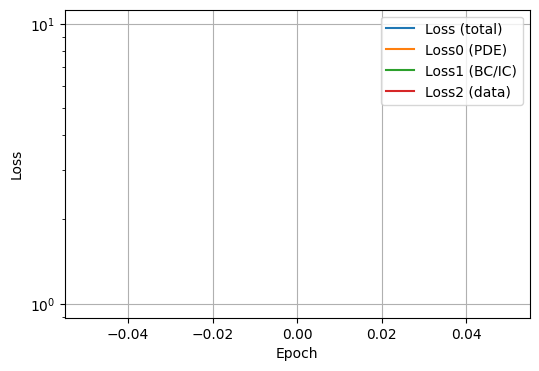

In [31]:
epochs_hist = []
loss_hist   = []
loss0_hist  = []
loss1_hist  = []
loss2_hist  = []

# ONE figure & ONE axes
fig, ax = plt.subplots(figsize=(6, 4))

(line_loss,)  = ax.plot([], [], label="Loss (total)")
(line_l0,)    = ax.plot([], [], label="Loss0 (PDE)")
(line_l1,)    = ax.plot([], [], label="Loss1 (BC/IC)")
(line_l2,)    = ax.plot([], [], label="Loss2 (data)")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.grid(True)
ax.legend()

def update_loss_plot(epoch, loss, loss0, loss1, loss2):
    # store history
    epochs_hist.append(epoch)
    loss_hist.append(loss)
    loss0_hist.append(loss0)
    loss1_hist.append(loss1)
    loss2_hist.append(loss2)

    # update line data
    line_loss.set_data(epochs_hist, loss_hist)
    line_l0.set_data(epochs_hist, loss0_hist)
    line_l1.set_data(epochs_hist, loss1_hist)
    line_l2.set_data(epochs_hist, loss2_hist)

    # rescale
    ax.relim()
    ax.autoscale_view()

    clear_output(wait=True)
    display(fig)

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.45509 | PDE: 0.54721 | BC: 0.20271 | Data: 0.19297


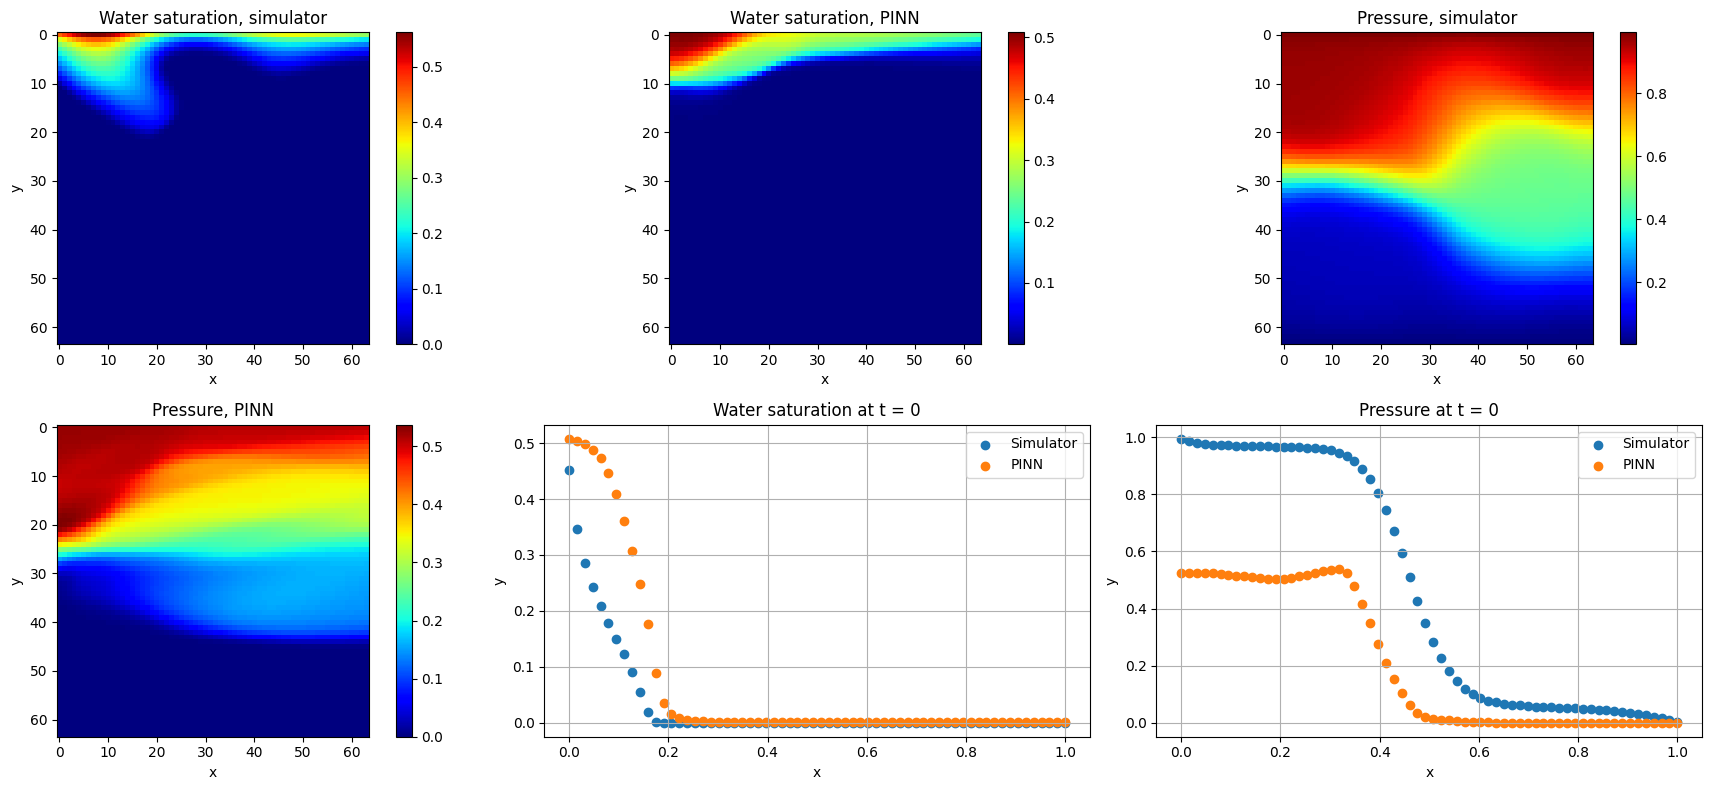

Epoch: 20 | Loss: 0.07147 | PDE: 0.11610 | BC: 0.00064 | Data: 0.02863
Epoch: 40 | Loss: 0.01398 | PDE: 0.03666 | BC: 0.00053 | Data: 0.02136
Epoch: 60 | Loss: 0.00648 | PDE: 0.01984 | BC: 0.00086 | Data: 0.01777
Epoch: 80 | Loss: 0.00437 | PDE: 0.01436 | BC: 0.00060 | Data: 0.01607
Epoch: 100 | Loss: 0.00356 | PDE: 0.01187 | BC: 0.00054 | Data: 0.01467
Epoch: 120 | Loss: 0.00311 | PDE: 0.01036 | BC: 0.00047 | Data: 0.01353
Epoch: 140 | Loss: 0.00275 | PDE: 0.00942 | BC: 0.00045 | Data: 0.01234
Epoch: 160 | Loss: 0.00255 | PDE: 0.00889 | BC: 0.00042 | Data: 0.01120
Epoch: 180 | Loss: 0.00238 | PDE: 0.00835 | BC: 0.00040 | Data: 0.01008
Epoch: 200 | Loss: 0.00217 | PDE: 0.00769 | BC: 0.00039 | Data: 0.00920


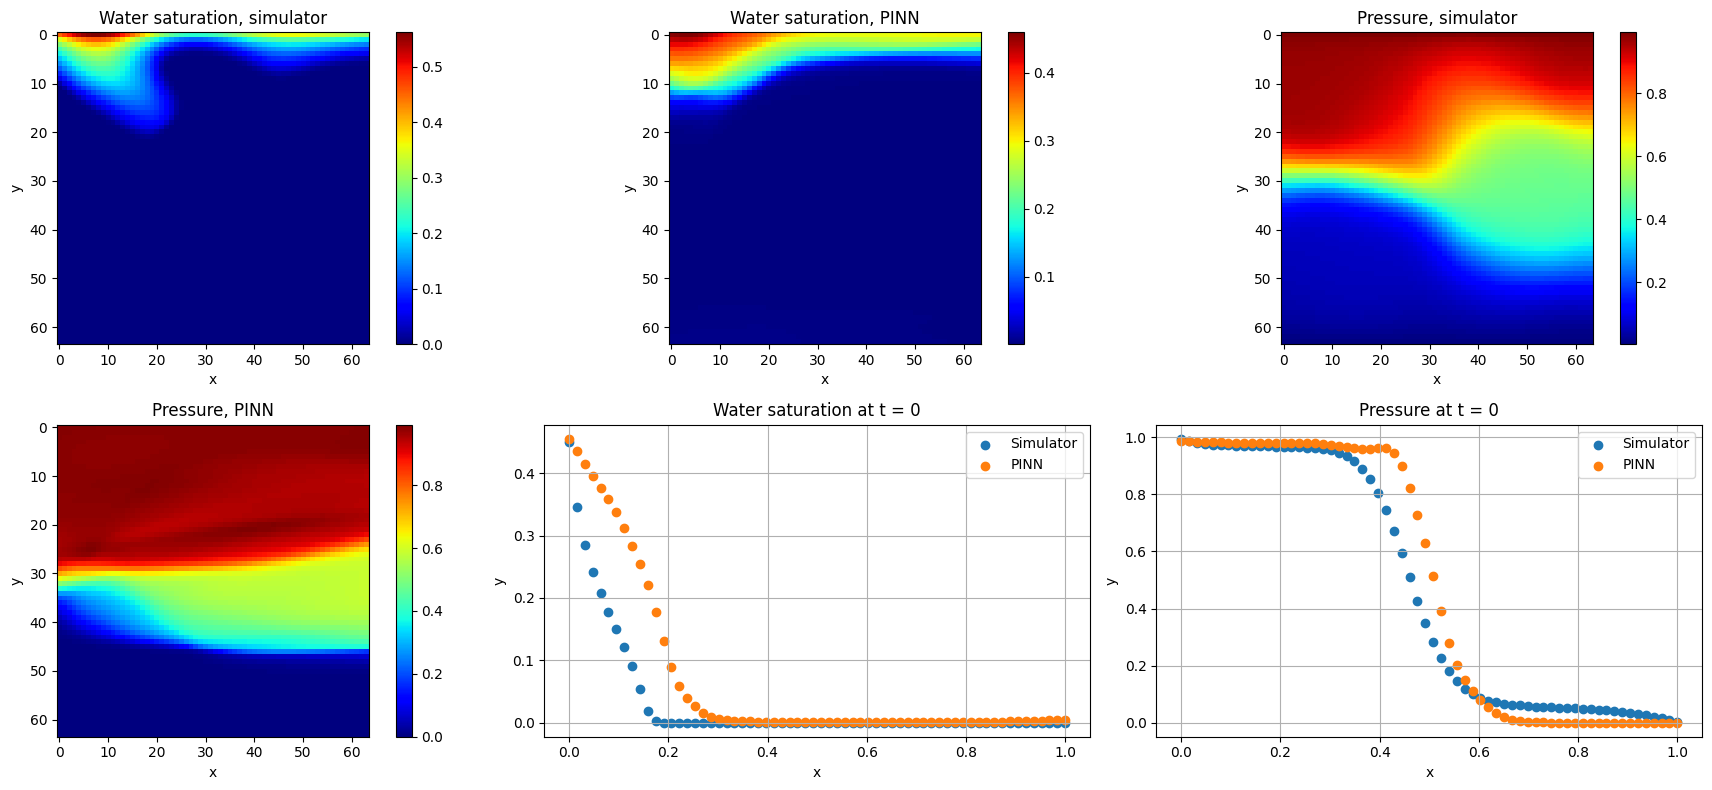

Epoch: 220 | Loss: 0.00200 | PDE: 0.00719 | BC: 0.00037 | Data: 0.00843
Epoch: 240 | Loss: 0.00184 | PDE: 0.00666 | BC: 0.00035 | Data: 0.00775
Epoch: 260 | Loss: 0.00169 | PDE: 0.00611 | BC: 0.00033 | Data: 0.00715
Epoch: 280 | Loss: 0.00158 | PDE: 0.00579 | BC: 0.00032 | Data: 0.00645
Epoch: 300 | Loss: 0.00141 | PDE: 0.00508 | BC: 0.00036 | Data: 0.00586
Epoch: 320 | Loss: 0.00150 | PDE: 0.00473 | BC: 0.00034 | Data: 0.00549
Epoch: 340 | Loss: 0.00130 | PDE: 0.00451 | BC: 0.00030 | Data: 0.00517
Epoch: 360 | Loss: 0.00126 | PDE: 0.00448 | BC: 0.00028 | Data: 0.00484
Epoch: 380 | Loss: 0.00113 | PDE: 0.00419 | BC: 0.00027 | Data: 0.00460
Epoch: 400 | Loss: 0.00835 | PDE: 0.01050 | BC: 0.00092 | Data: 0.00585


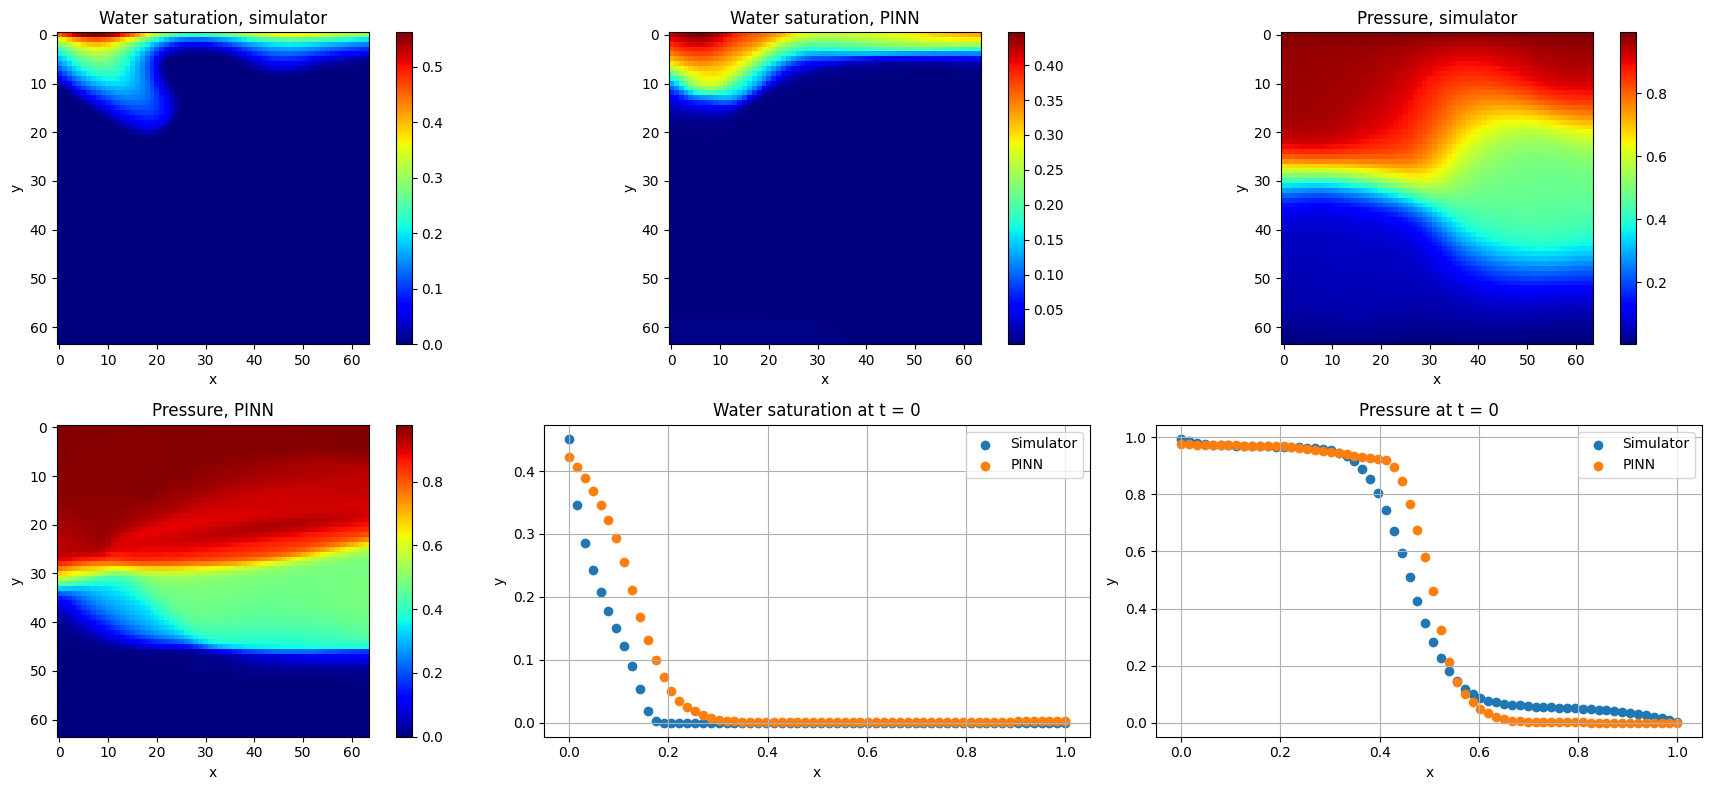

Epoch: 420 | Loss: 0.00181 | PDE: 0.00462 | BC: 0.00027 | Data: 0.00457
Epoch: 440 | Loss: 0.00111 | PDE: 0.00365 | BC: 0.00026 | Data: 0.00427
Epoch: 460 | Loss: 0.00098 | PDE: 0.00346 | BC: 0.00026 | Data: 0.00410
Epoch: 480 | Loss: 0.00091 | PDE: 0.00330 | BC: 0.00025 | Data: 0.00398
Epoch: 500 | Loss: 0.00087 | PDE: 0.00330 | BC: 0.00023 | Data: 0.00384
Epoch: 520 | Loss: 0.00085 | PDE: 0.00323 | BC: 0.00022 | Data: 0.00372
Epoch: 540 | Loss: 0.00082 | PDE: 0.00316 | BC: 0.00021 | Data: 0.00361
Epoch: 560 | Loss: 0.00080 | PDE: 0.00309 | BC: 0.00021 | Data: 0.00349
Epoch: 580 | Loss: 0.00077 | PDE: 0.00302 | BC: 0.00020 | Data: 0.00338
Epoch: 600 | Loss: 0.00075 | PDE: 0.00294 | BC: 0.00020 | Data: 0.00328


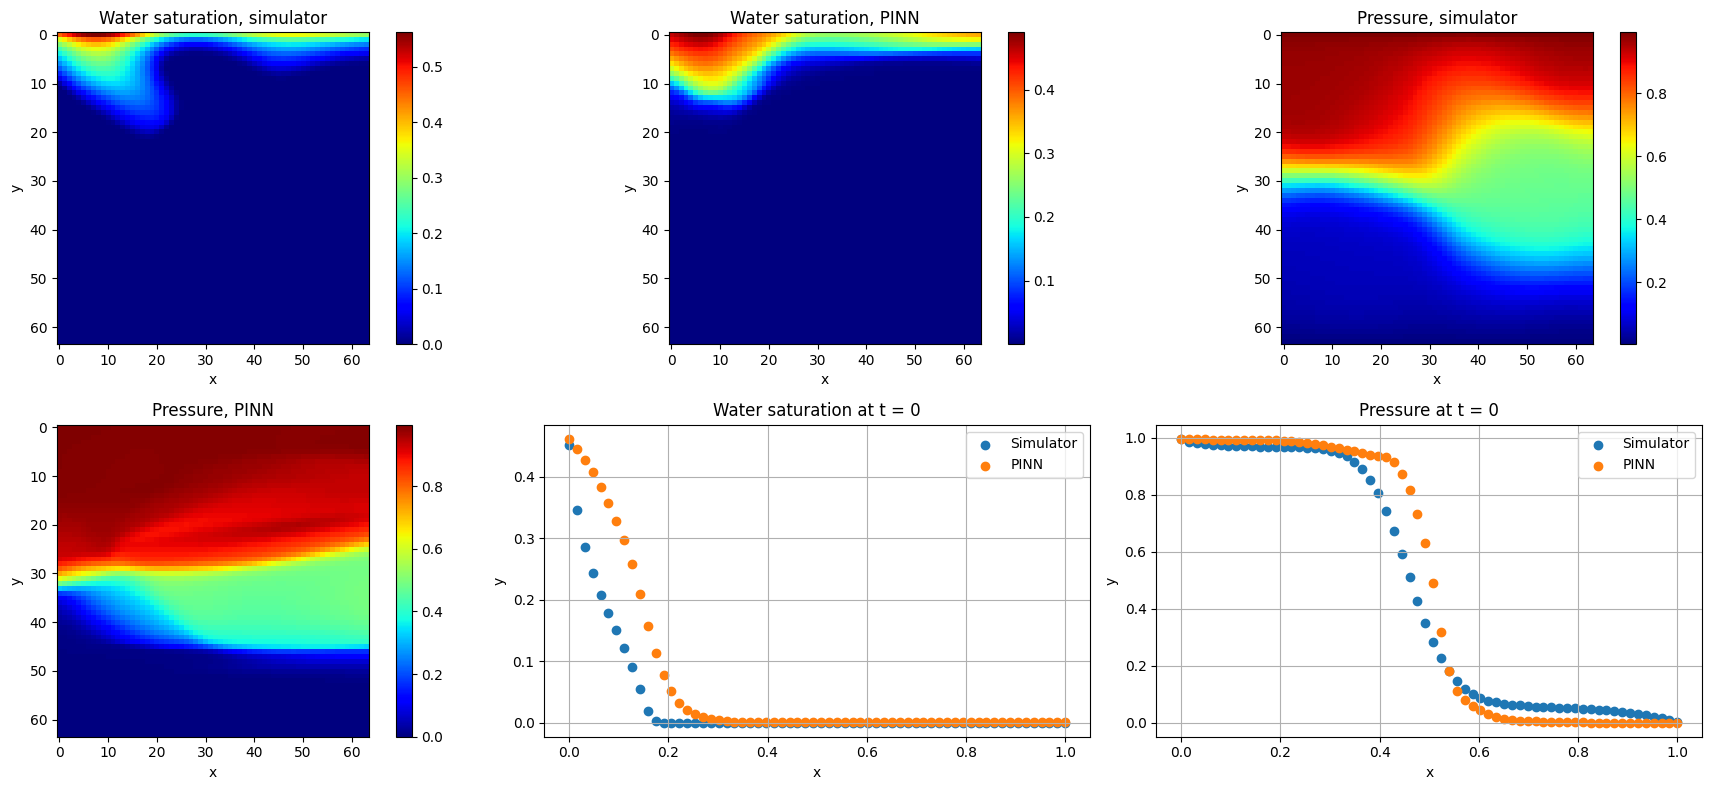

Epoch: 620 | Loss: 0.00072 | PDE: 0.00287 | BC: 0.00019 | Data: 0.00318
Epoch: 640 | Loss: 0.00070 | PDE: 0.00280 | BC: 0.00019 | Data: 0.00309
Epoch: 660 | Loss: 0.00068 | PDE: 0.00273 | BC: 0.00018 | Data: 0.00301
Epoch: 680 | Loss: 0.00066 | PDE: 0.00266 | BC: 0.00018 | Data: 0.00292
Epoch: 700 | Loss: 0.00063 | PDE: 0.00259 | BC: 0.00017 | Data: 0.00285
Epoch: 720 | Loss: 0.00062 | PDE: 0.00253 | BC: 0.00017 | Data: 0.00277
Epoch: 740 | Loss: 0.00060 | PDE: 0.00247 | BC: 0.00016 | Data: 0.00269
Epoch: 760 | Loss: 0.00058 | PDE: 0.00242 | BC: 0.00016 | Data: 0.00262
Epoch: 780 | Loss: 0.00056 | PDE: 0.00236 | BC: 0.00016 | Data: 0.00255
Epoch: 800 | Loss: 0.00055 | PDE: 0.00231 | BC: 0.00015 | Data: 0.00247


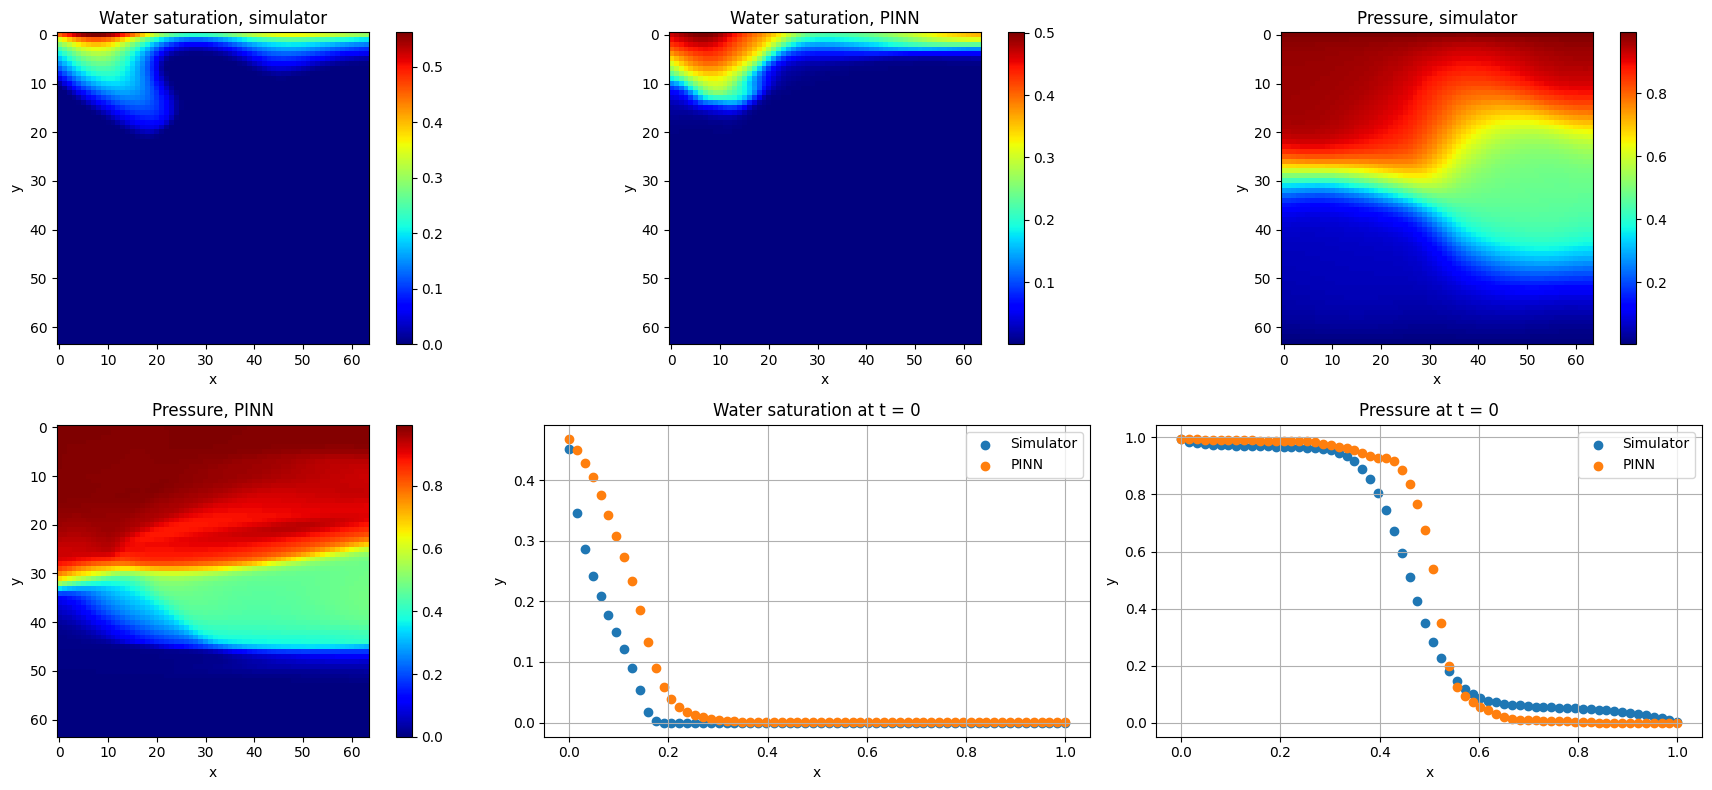

Epoch: 820 | Loss: 0.00053 | PDE: 0.00226 | BC: 0.00015 | Data: 0.00240
Epoch: 840 | Loss: 0.00052 | PDE: 0.00222 | BC: 0.00015 | Data: 0.00233
Epoch: 860 | Loss: 0.00053 | PDE: 0.00220 | BC: 0.00014 | Data: 0.00226
Epoch: 880 | Loss: 0.00051 | PDE: 0.00215 | BC: 0.00014 | Data: 0.00219
Epoch: 900 | Loss: 0.00048 | PDE: 0.00210 | BC: 0.00014 | Data: 0.00213
Epoch: 920 | Loss: 0.00048 | PDE: 0.00207 | BC: 0.00013 | Data: 0.00207
Epoch: 940 | Loss: 0.00046 | PDE: 0.00203 | BC: 0.00013 | Data: 0.00201
Epoch: 960 | Loss: 0.00045 | PDE: 0.00199 | BC: 0.00013 | Data: 0.00196
Epoch: 980 | Loss: 0.00046 | PDE: 0.00197 | BC: 0.00012 | Data: 0.00191
Epoch: 1000 | Loss: 0.00044 | PDE: 0.00193 | BC: 0.00013 | Data: 0.00186


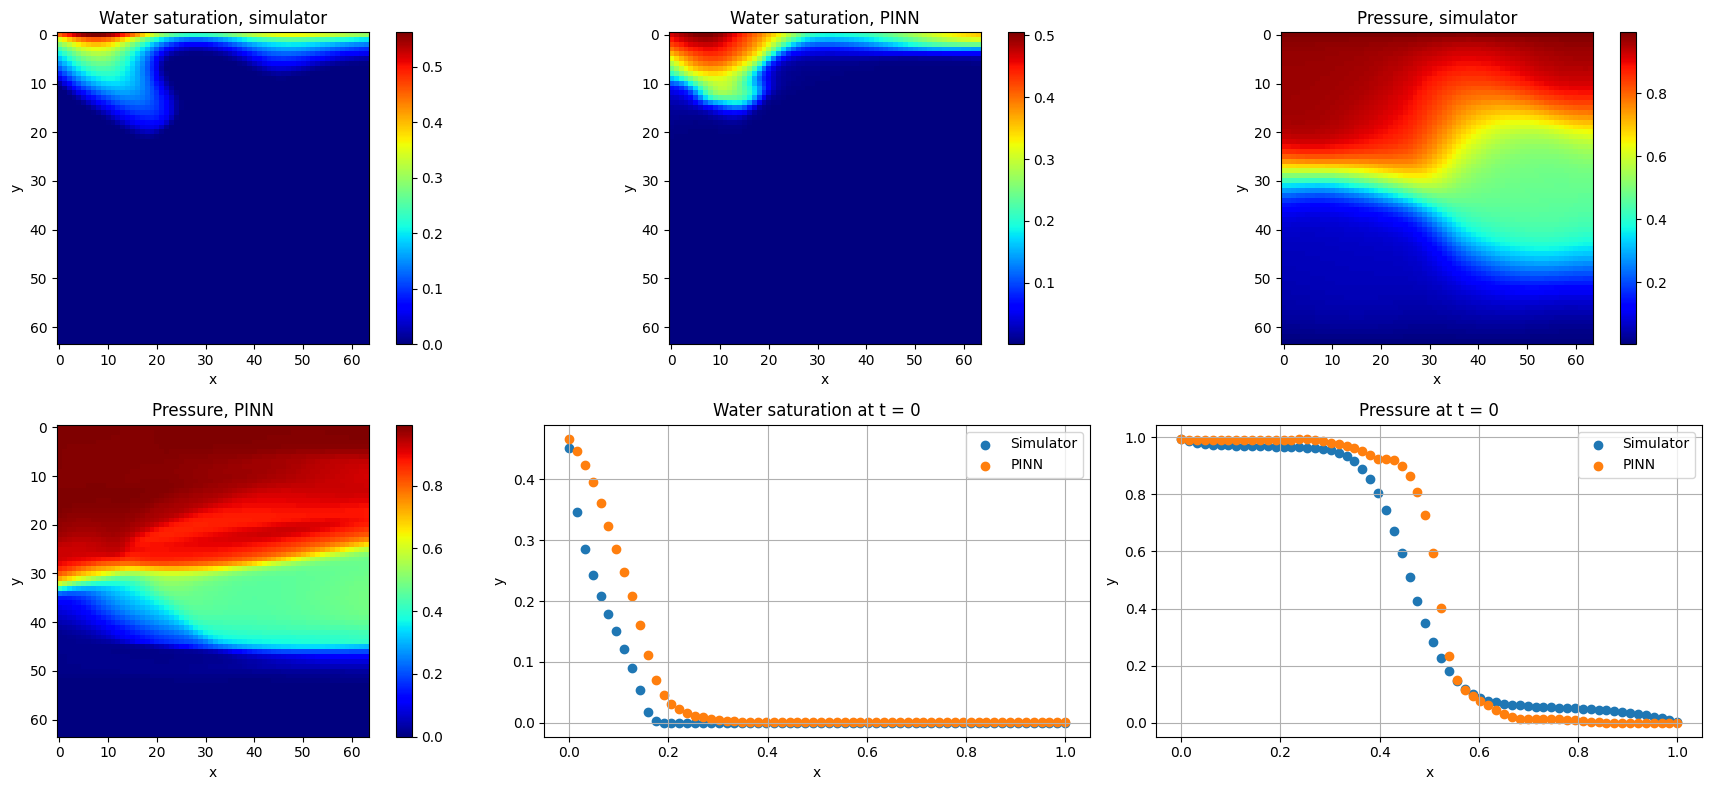

Epoch: 1020 | Loss: 0.00043 | PDE: 0.00190 | BC: 0.00012 | Data: 0.00181
Epoch: 1040 | Loss: 0.00042 | PDE: 0.00187 | BC: 0.00012 | Data: 0.00176
Epoch: 1060 | Loss: 0.00040 | PDE: 0.00183 | BC: 0.00012 | Data: 0.00171
Epoch: 1080 | Loss: 0.00042 | PDE: 0.00182 | BC: 0.00012 | Data: 0.00166
Epoch: 1100 | Loss: 0.00038 | PDE: 0.00176 | BC: 0.00012 | Data: 0.00162
Epoch: 1120 | Loss: 0.00038 | PDE: 0.00173 | BC: 0.00012 | Data: 0.00157
Epoch: 1140 | Loss: 0.00039 | PDE: 0.00171 | BC: 0.00011 | Data: 0.00153
Epoch: 1160 | Loss: 0.00037 | PDE: 0.00167 | BC: 0.00011 | Data: 0.00149
Epoch: 1180 | Loss: 0.00037 | PDE: 0.00164 | BC: 0.00011 | Data: 0.00145
Epoch: 1200 | Loss: 0.00034 | PDE: 0.00159 | BC: 0.00011 | Data: 0.00141


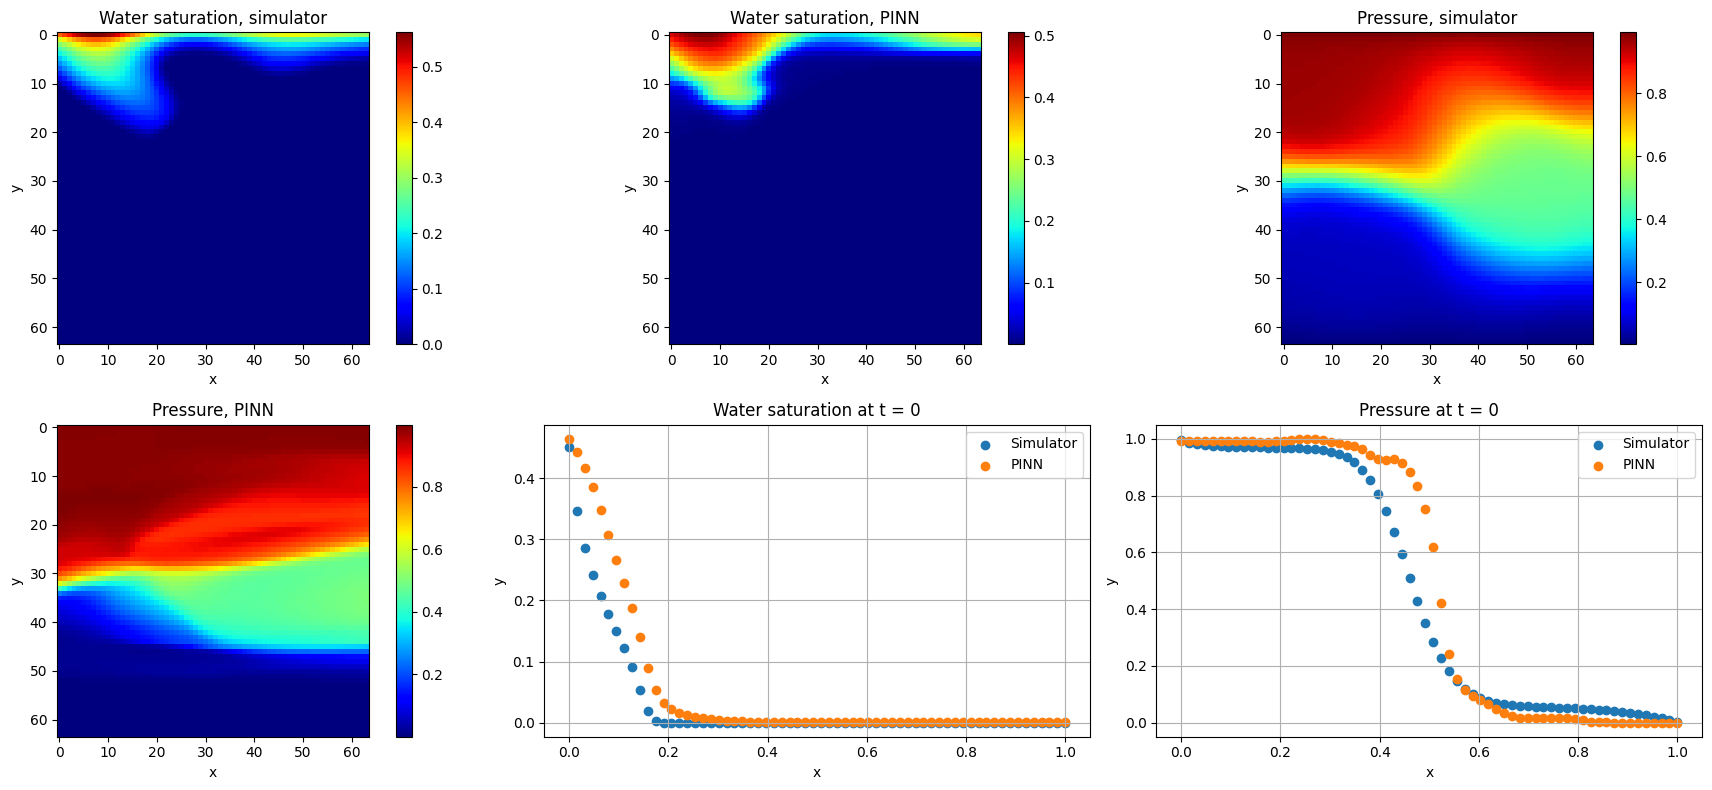

Epoch: 1220 | Loss: 0.00035 | PDE: 0.00158 | BC: 0.00011 | Data: 0.00138
Epoch: 1240 | Loss: 0.00034 | PDE: 0.00155 | BC: 0.00011 | Data: 0.00135
Epoch: 1260 | Loss: 0.00034 | PDE: 0.00153 | BC: 0.00010 | Data: 0.00132
Epoch: 1280 | Loss: 0.00033 | PDE: 0.00149 | BC: 0.00011 | Data: 0.00129
Epoch: 1300 | Loss: 0.00032 | PDE: 0.00149 | BC: 0.00010 | Data: 0.00125
Epoch: 1320 | Loss: 0.00043 | PDE: 0.00154 | BC: 0.00009 | Data: 0.00124
Epoch: 1340 | Loss: 0.01466 | PDE: 0.01694 | BC: 0.00019 | Data: 0.00133
Epoch: 1360 | Loss: 0.00066 | PDE: 0.00187 | BC: 0.00017 | Data: 0.00150
Epoch: 1380 | Loss: 0.00045 | PDE: 0.00142 | BC: 0.00016 | Data: 0.00125
Epoch: 1400 | Loss: 0.00033 | PDE: 0.00125 | BC: 0.00012 | Data: 0.00121


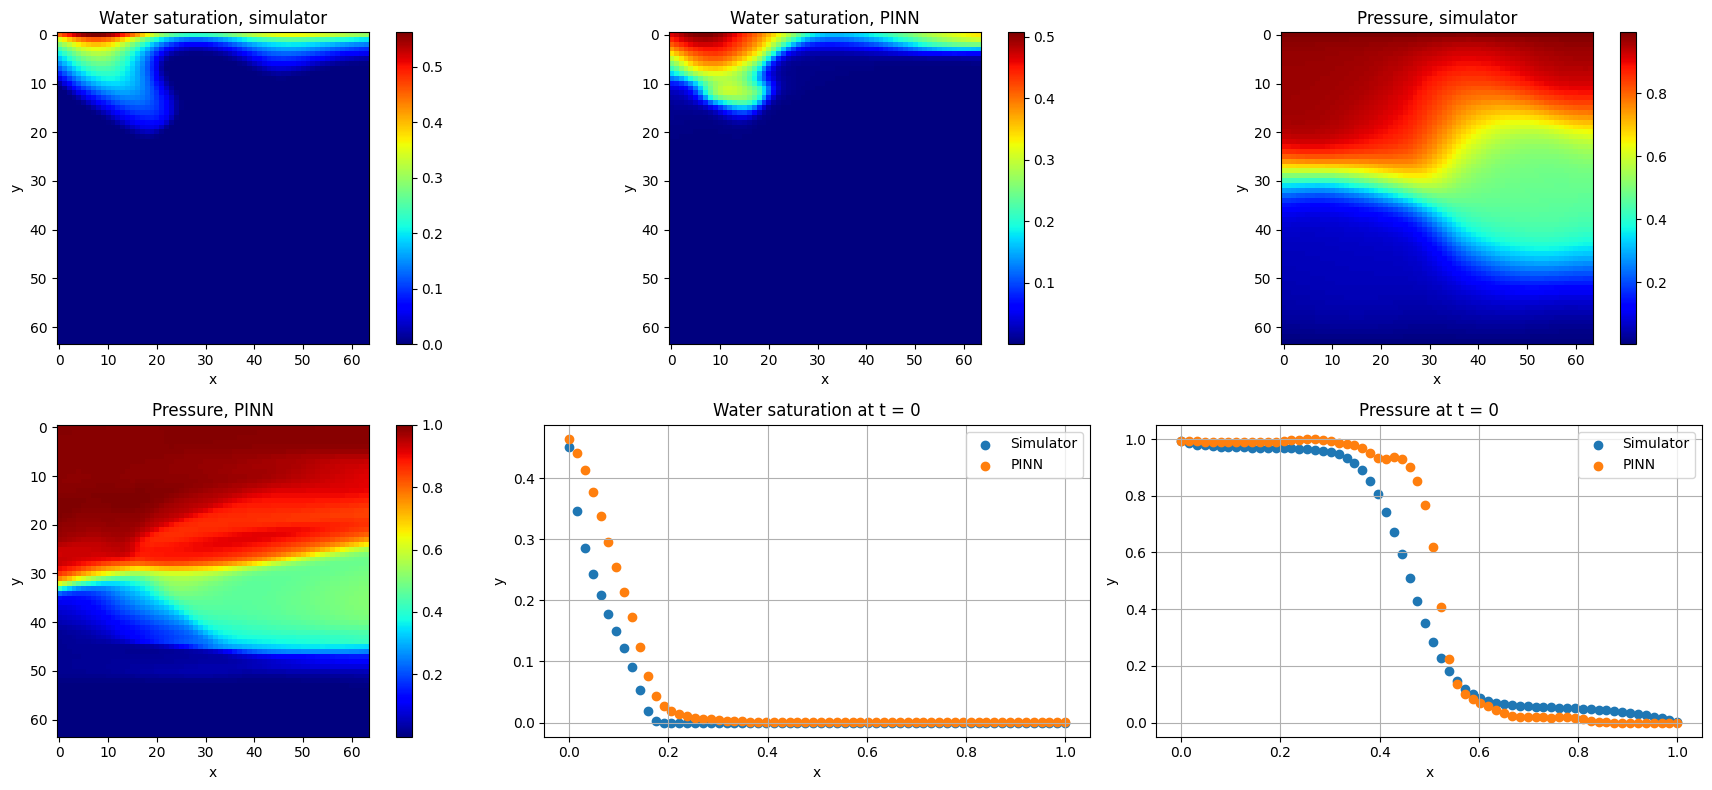

Epoch: 1420 | Loss: 0.00030 | PDE: 0.00127 | BC: 0.00011 | Data: 0.00119
Epoch: 1440 | Loss: 0.00029 | PDE: 0.00129 | BC: 0.00010 | Data: 0.00117
Epoch: 1460 | Loss: 0.00029 | PDE: 0.00130 | BC: 0.00010 | Data: 0.00115
Epoch: 1480 | Loss: 0.00029 | PDE: 0.00130 | BC: 0.00010 | Data: 0.00113
Epoch: 1500 | Loss: 0.00029 | PDE: 0.00130 | BC: 0.00010 | Data: 0.00112
Epoch: 1520 | Loss: 0.00029 | PDE: 0.00131 | BC: 0.00010 | Data: 0.00111
Epoch: 1540 | Loss: 0.00029 | PDE: 0.00131 | BC: 0.00010 | Data: 0.00109
Epoch: 1560 | Loss: 0.00029 | PDE: 0.00131 | BC: 0.00010 | Data: 0.00108
Epoch: 1580 | Loss: 0.00029 | PDE: 0.00131 | BC: 0.00010 | Data: 0.00107
Epoch: 1600 | Loss: 0.00029 | PDE: 0.00131 | BC: 0.00010 | Data: 0.00106


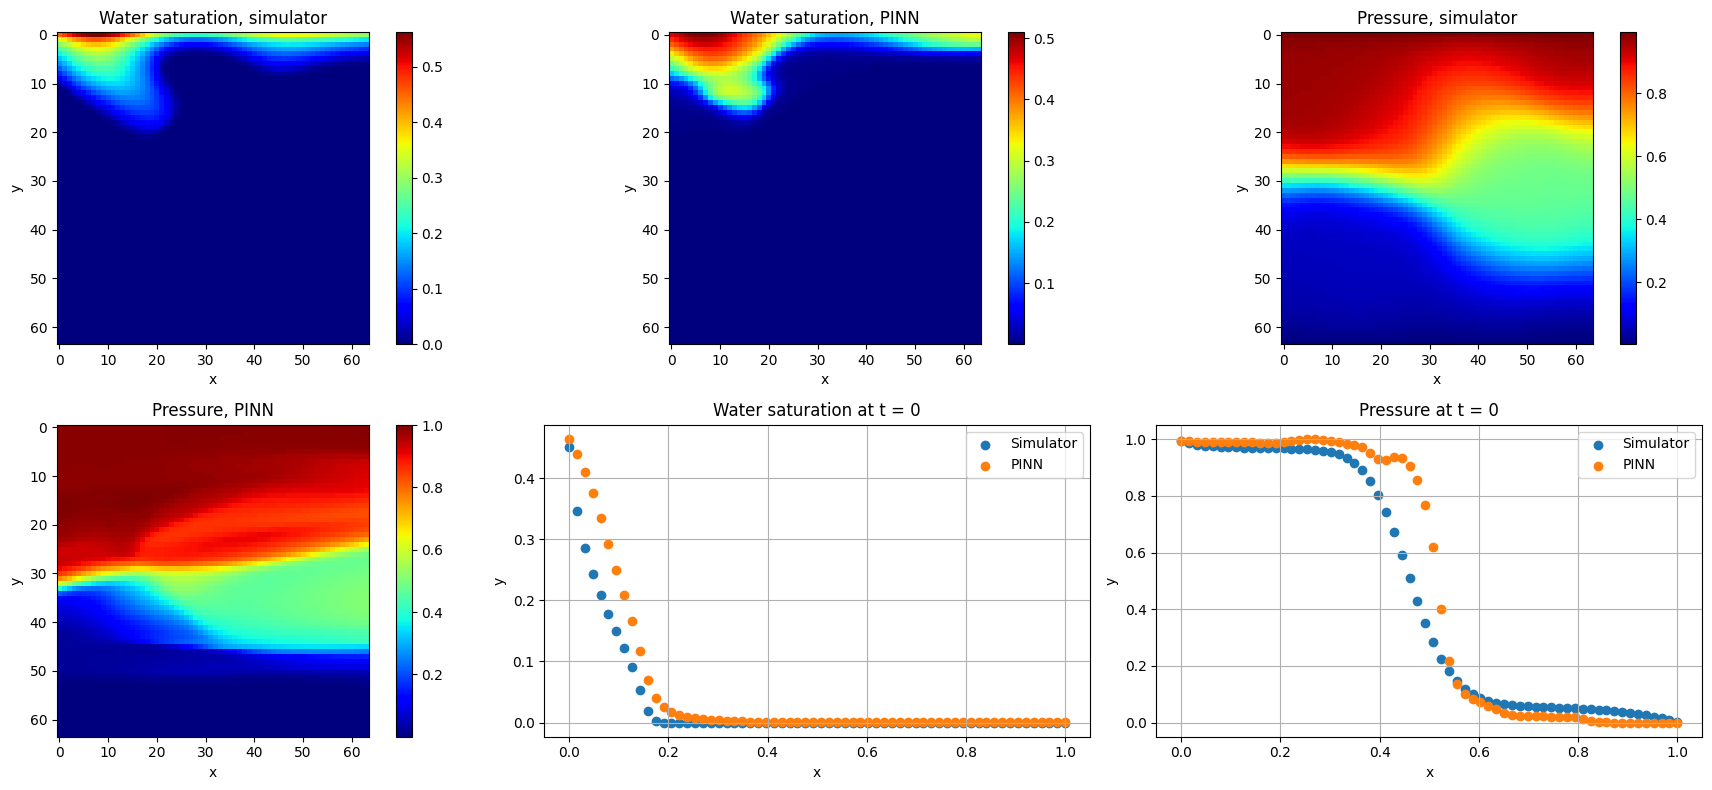

Epoch: 1620 | Loss: 0.00028 | PDE: 0.00130 | BC: 0.00010 | Data: 0.00105
Epoch: 1640 | Loss: 0.00028 | PDE: 0.00130 | BC: 0.00010 | Data: 0.00104
Epoch: 1660 | Loss: 0.00028 | PDE: 0.00129 | BC: 0.00010 | Data: 0.00103
Epoch: 1680 | Loss: 0.00028 | PDE: 0.00129 | BC: 0.00010 | Data: 0.00102
Epoch: 1700 | Loss: 0.00028 | PDE: 0.00128 | BC: 0.00010 | Data: 0.00101
Epoch: 1720 | Loss: 0.00028 | PDE: 0.00128 | BC: 0.00010 | Data: 0.00100
Epoch: 1740 | Loss: 0.00028 | PDE: 0.00127 | BC: 0.00010 | Data: 0.00099
Epoch: 1760 | Loss: 0.00027 | PDE: 0.00127 | BC: 0.00010 | Data: 0.00098
Epoch: 1780 | Loss: 0.00027 | PDE: 0.00126 | BC: 0.00010 | Data: 0.00097
Epoch: 1800 | Loss: 0.00027 | PDE: 0.00126 | BC: 0.00010 | Data: 0.00096


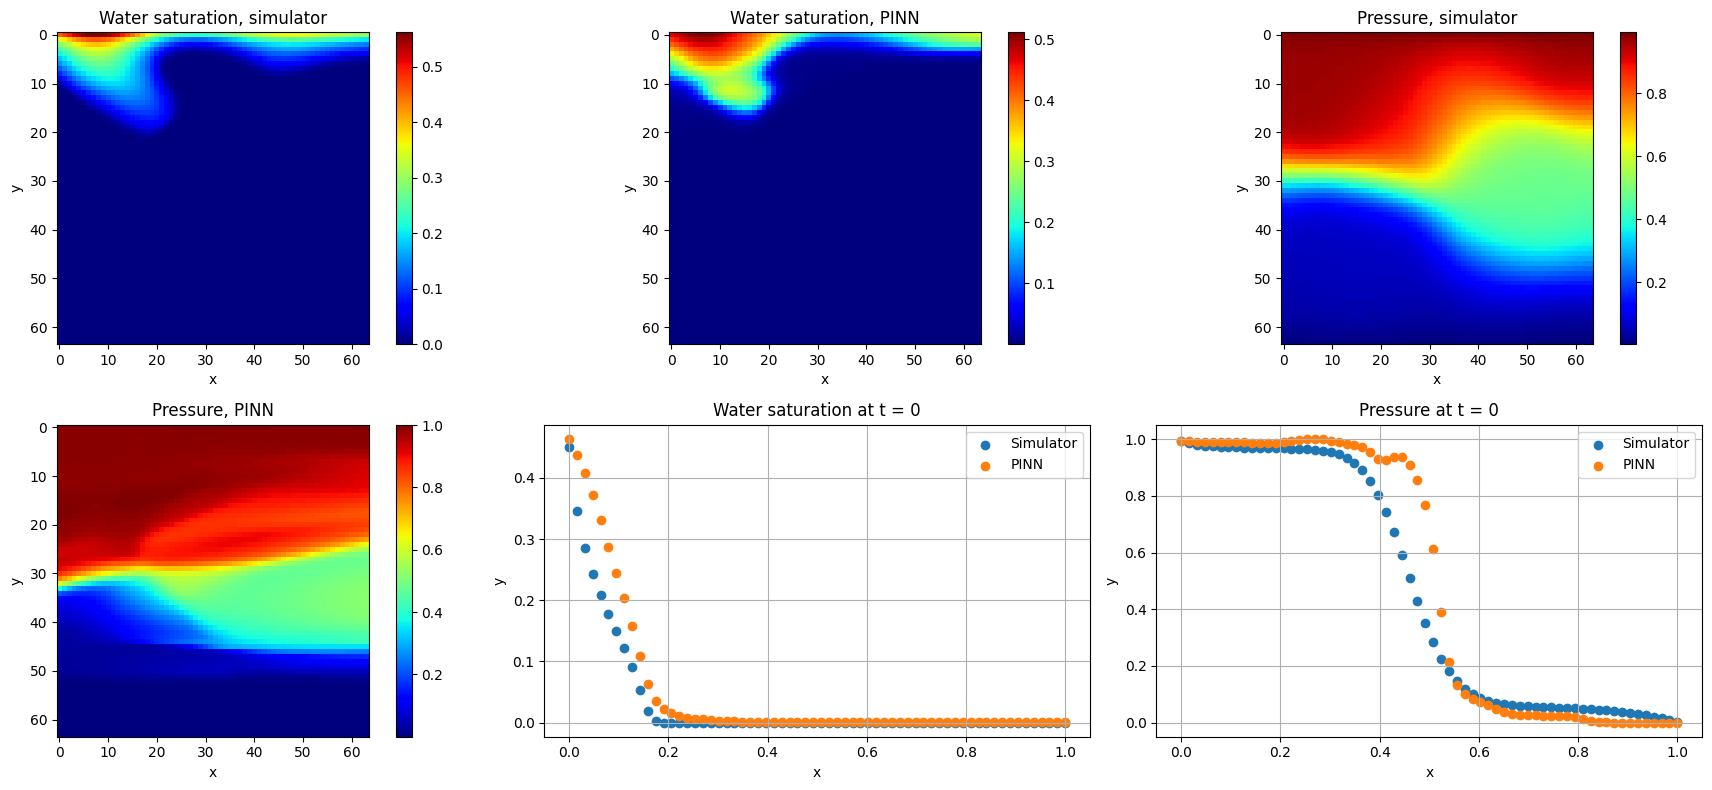

Epoch: 1820 | Loss: 0.00027 | PDE: 0.00125 | BC: 0.00009 | Data: 0.00095
Epoch: 1840 | Loss: 0.00027 | PDE: 0.00125 | BC: 0.00009 | Data: 0.00094
Epoch: 1860 | Loss: 0.00027 | PDE: 0.00124 | BC: 0.00009 | Data: 0.00093
Epoch: 1880 | Loss: 0.00027 | PDE: 0.00124 | BC: 0.00009 | Data: 0.00092
Epoch: 1900 | Loss: 0.00026 | PDE: 0.00123 | BC: 0.00009 | Data: 0.00091
Epoch: 1920 | Loss: 0.00026 | PDE: 0.00123 | BC: 0.00009 | Data: 0.00090
Epoch: 1940 | Loss: 0.00026 | PDE: 0.00122 | BC: 0.00009 | Data: 0.00090
Epoch: 1960 | Loss: 0.00026 | PDE: 0.00122 | BC: 0.00009 | Data: 0.00089
Epoch: 1980 | Loss: 0.00026 | PDE: 0.00121 | BC: 0.00009 | Data: 0.00088
Epoch: 2000 | Loss: 0.00026 | PDE: 0.00121 | BC: 0.00009 | Data: 0.00087


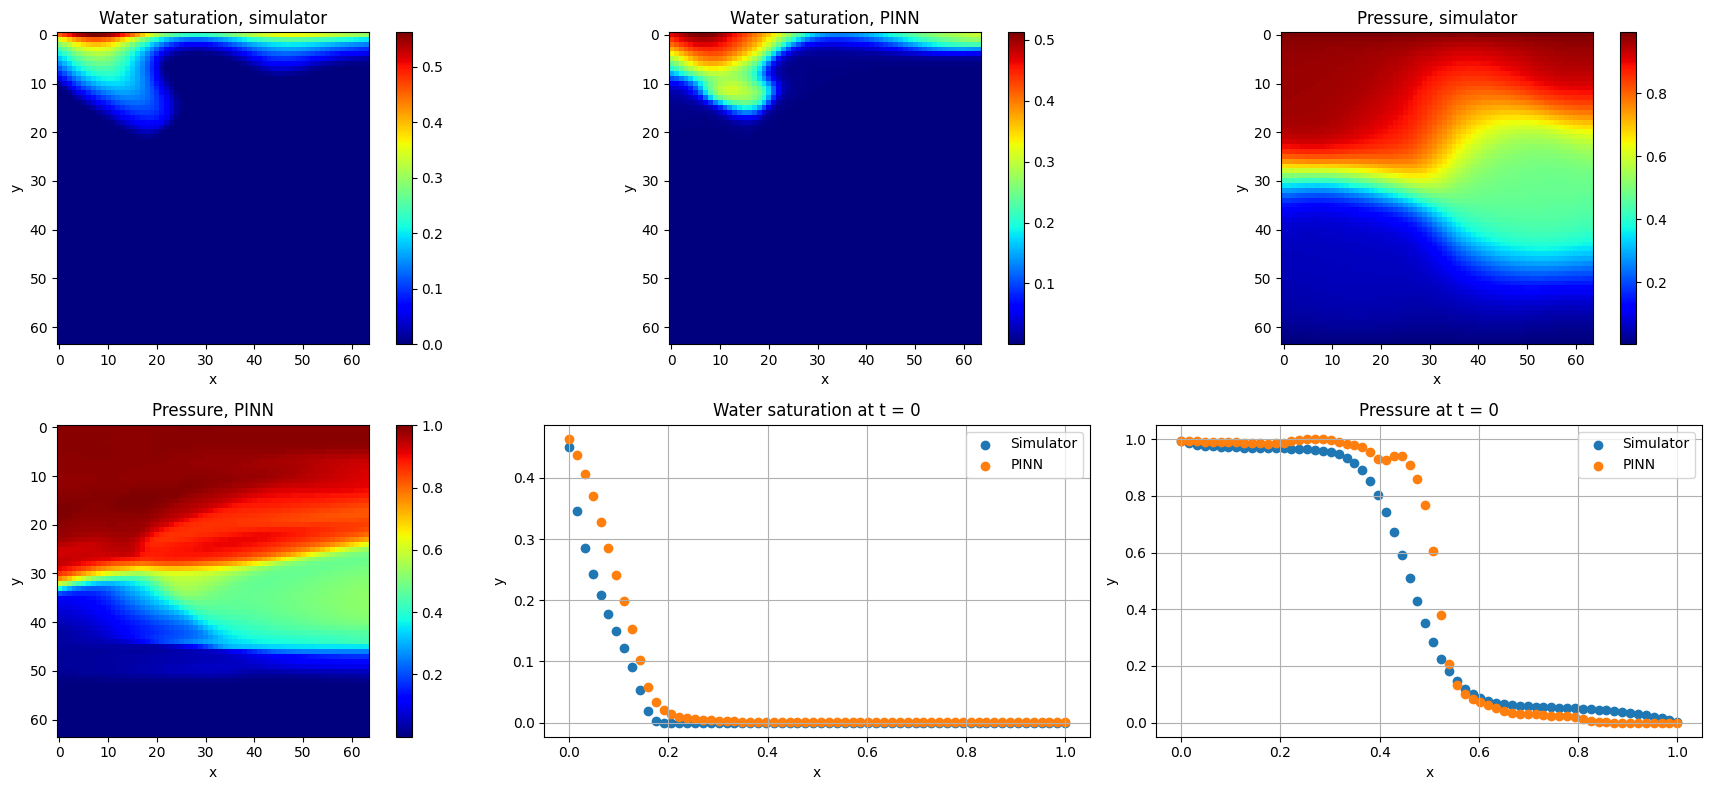

Epoch: 2020 | Loss: 0.00026 | PDE: 0.00121 | BC: 0.00009 | Data: 0.00086
Epoch: 2040 | Loss: 0.00026 | PDE: 0.00120 | BC: 0.00009 | Data: 0.00086
Epoch: 2060 | Loss: 0.00025 | PDE: 0.00120 | BC: 0.00009 | Data: 0.00085
Epoch: 2080 | Loss: 0.00025 | PDE: 0.00120 | BC: 0.00009 | Data: 0.00084
Epoch: 2100 | Loss: 0.00025 | PDE: 0.00119 | BC: 0.00009 | Data: 0.00083
Epoch: 2120 | Loss: 0.00025 | PDE: 0.00119 | BC: 0.00009 | Data: 0.00082
Epoch: 2140 | Loss: 0.00025 | PDE: 0.00119 | BC: 0.00009 | Data: 0.00082
Epoch: 2160 | Loss: 0.00025 | PDE: 0.00118 | BC: 0.00009 | Data: 0.00081
Epoch: 2180 | Loss: 0.00025 | PDE: 0.00118 | BC: 0.00009 | Data: 0.00080
Epoch: 2200 | Loss: 0.00025 | PDE: 0.00117 | BC: 0.00009 | Data: 0.00080


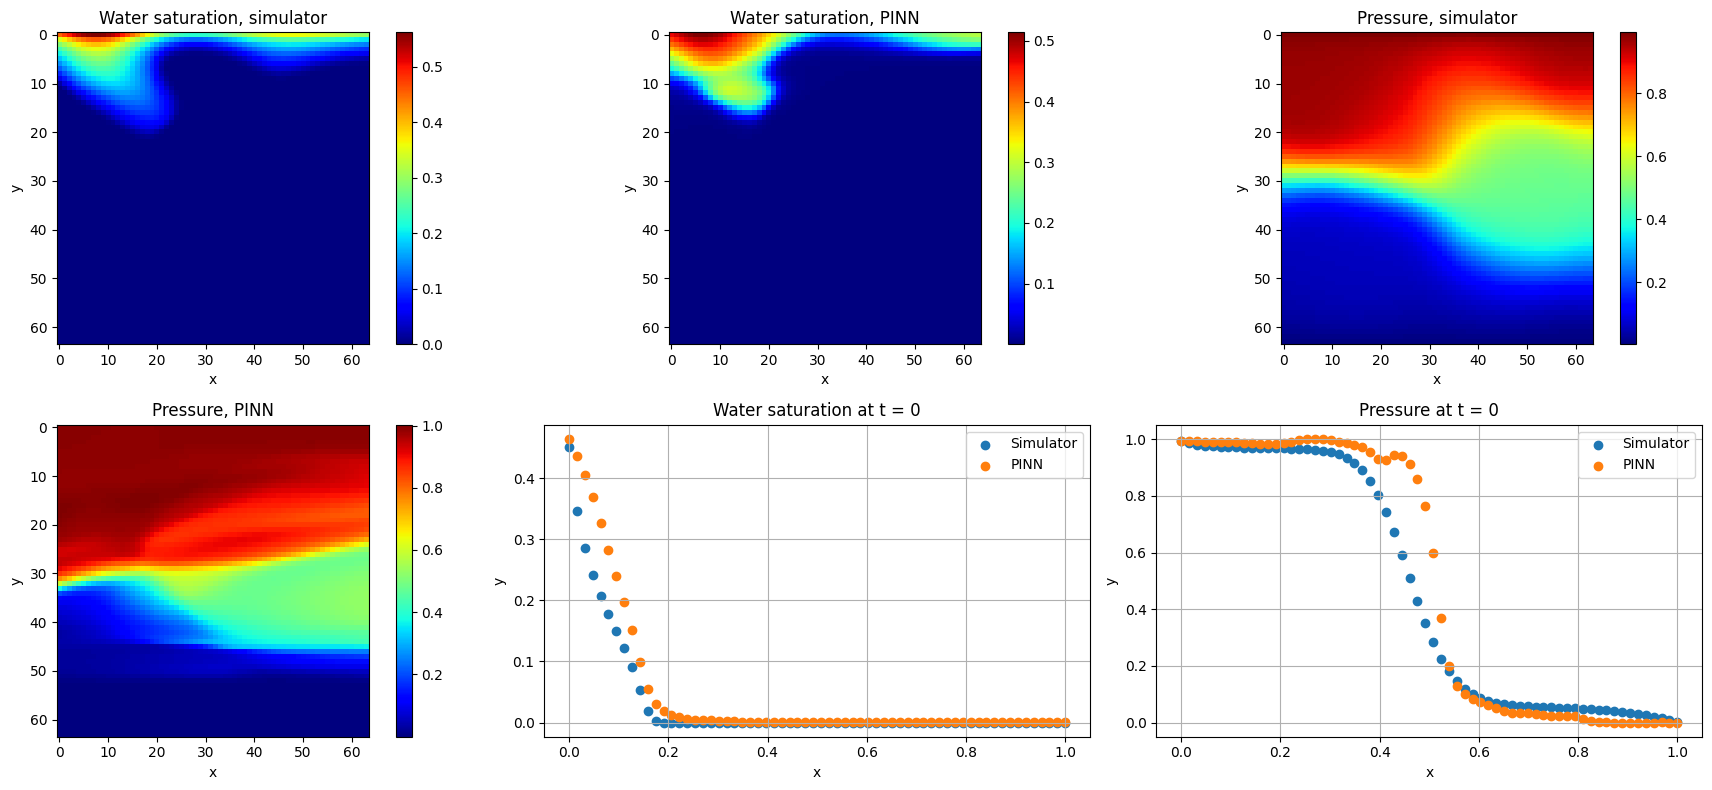

Epoch: 2220 | Loss: 0.00025 | PDE: 0.00117 | BC: 0.00009 | Data: 0.00079
Epoch: 2240 | Loss: 0.00025 | PDE: 0.00116 | BC: 0.00009 | Data: 0.00078
Epoch: 2260 | Loss: 0.00024 | PDE: 0.00116 | BC: 0.00009 | Data: 0.00077
Epoch: 2280 | Loss: 0.00024 | PDE: 0.00115 | BC: 0.00009 | Data: 0.00077
Epoch: 2300 | Loss: 0.00024 | PDE: 0.00114 | BC: 0.00009 | Data: 0.00076
Epoch: 2320 | Loss: 0.00024 | PDE: 0.00114 | BC: 0.00009 | Data: 0.00075
Epoch: 2340 | Loss: 0.00024 | PDE: 0.00113 | BC: 0.00009 | Data: 0.00075
Epoch: 2360 | Loss: 0.00024 | PDE: 0.00113 | BC: 0.00009 | Data: 0.00074
Epoch: 2380 | Loss: 0.00024 | PDE: 0.00112 | BC: 0.00008 | Data: 0.00073
Epoch: 2400 | Loss: 0.00023 | PDE: 0.00112 | BC: 0.00009 | Data: 0.00073


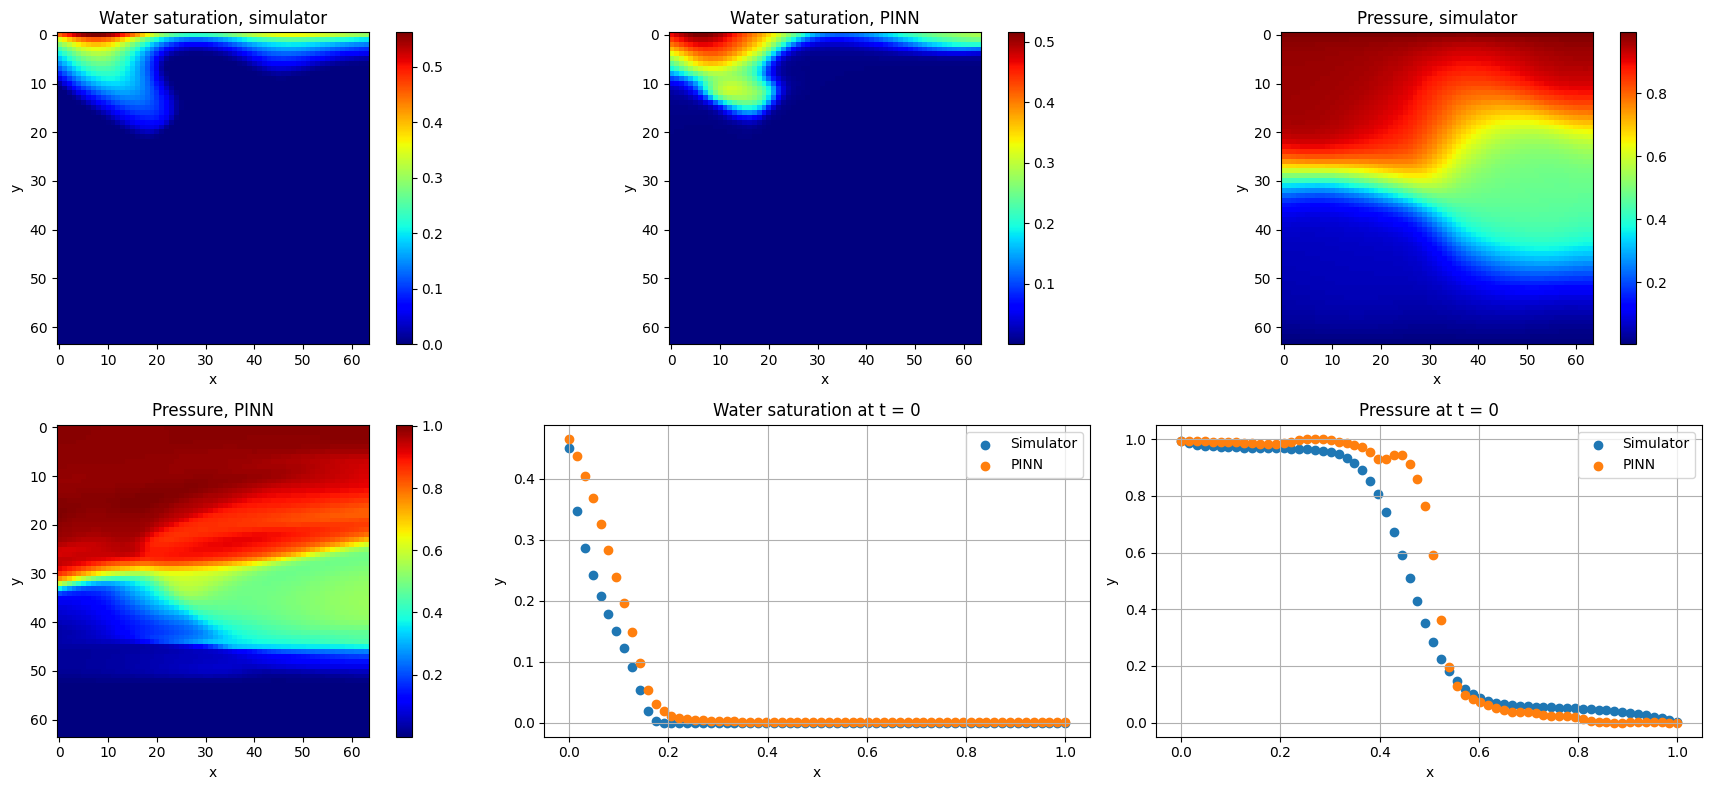

Epoch: 2420 | Loss: 0.00023 | PDE: 0.00111 | BC: 0.00008 | Data: 0.00072
Epoch: 2440 | Loss: 0.00023 | PDE: 0.00111 | BC: 0.00008 | Data: 0.00071
Epoch: 2460 | Loss: 0.00023 | PDE: 0.00110 | BC: 0.00008 | Data: 0.00071
Epoch: 2480 | Loss: 0.00023 | PDE: 0.00110 | BC: 0.00008 | Data: 0.00070
Epoch: 2500 | Loss: 0.00023 | PDE: 0.00110 | BC: 0.00008 | Data: 0.00070
Epoch: 2520 | Loss: 0.00022 | PDE: 0.00109 | BC: 0.00008 | Data: 0.00069
Epoch: 2540 | Loss: 0.00023 | PDE: 0.00109 | BC: 0.00008 | Data: 0.00069
Epoch: 2560 | Loss: 0.00022 | PDE: 0.00108 | BC: 0.00008 | Data: 0.00068
Epoch: 2580 | Loss: 0.00022 | PDE: 0.00108 | BC: 0.00008 | Data: 0.00067
Epoch: 2600 | Loss: 0.00022 | PDE: 0.00108 | BC: 0.00008 | Data: 0.00067


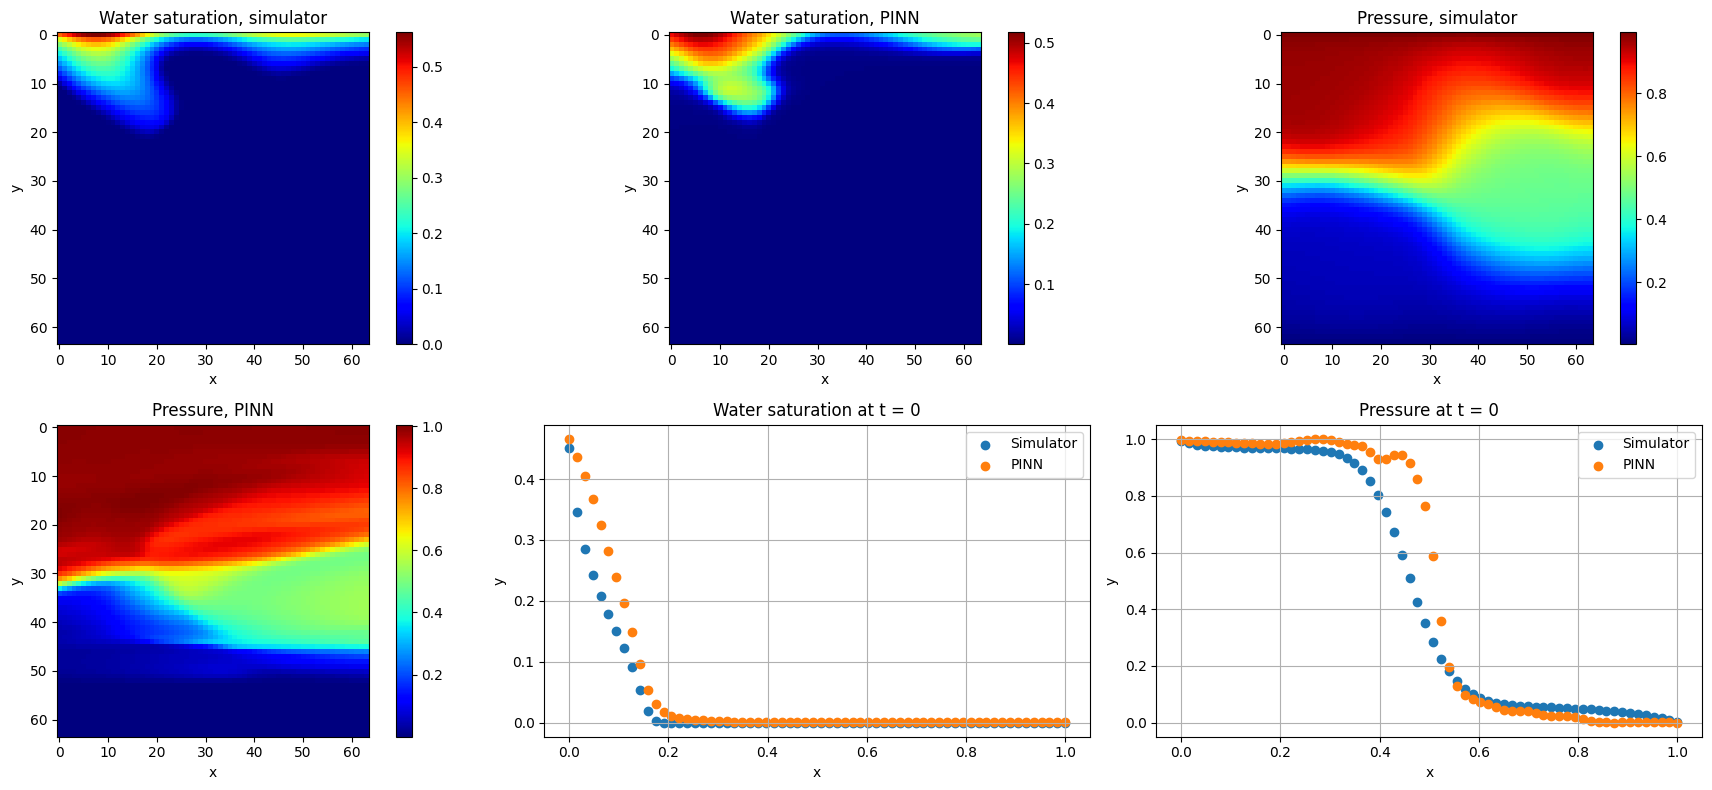

Epoch: 2620 | Loss: 0.00022 | PDE: 0.00108 | BC: 0.00008 | Data: 0.00066
Epoch: 2640 | Loss: 0.00023 | PDE: 0.00108 | BC: 0.00008 | Data: 0.00066
Epoch: 2660 | Loss: 0.00022 | PDE: 0.00107 | BC: 0.00008 | Data: 0.00065
Epoch: 2680 | Loss: 0.00022 | PDE: 0.00107 | BC: 0.00008 | Data: 0.00064
Epoch: 2700 | Loss: 0.00021 | PDE: 0.00106 | BC: 0.00008 | Data: 0.00064
Epoch: 2720 | Loss: 0.00022 | PDE: 0.00106 | BC: 0.00008 | Data: 0.00063
Epoch: 2740 | Loss: 0.00022 | PDE: 0.00106 | BC: 0.00008 | Data: 0.00063
Epoch: 2760 | Loss: 0.00021 | PDE: 0.00106 | BC: 0.00008 | Data: 0.00062
Epoch: 2780 | Loss: 0.00021 | PDE: 0.00106 | BC: 0.00008 | Data: 0.00062
Epoch: 2800 | Loss: 0.00021 | PDE: 0.00105 | BC: 0.00008 | Data: 0.00061


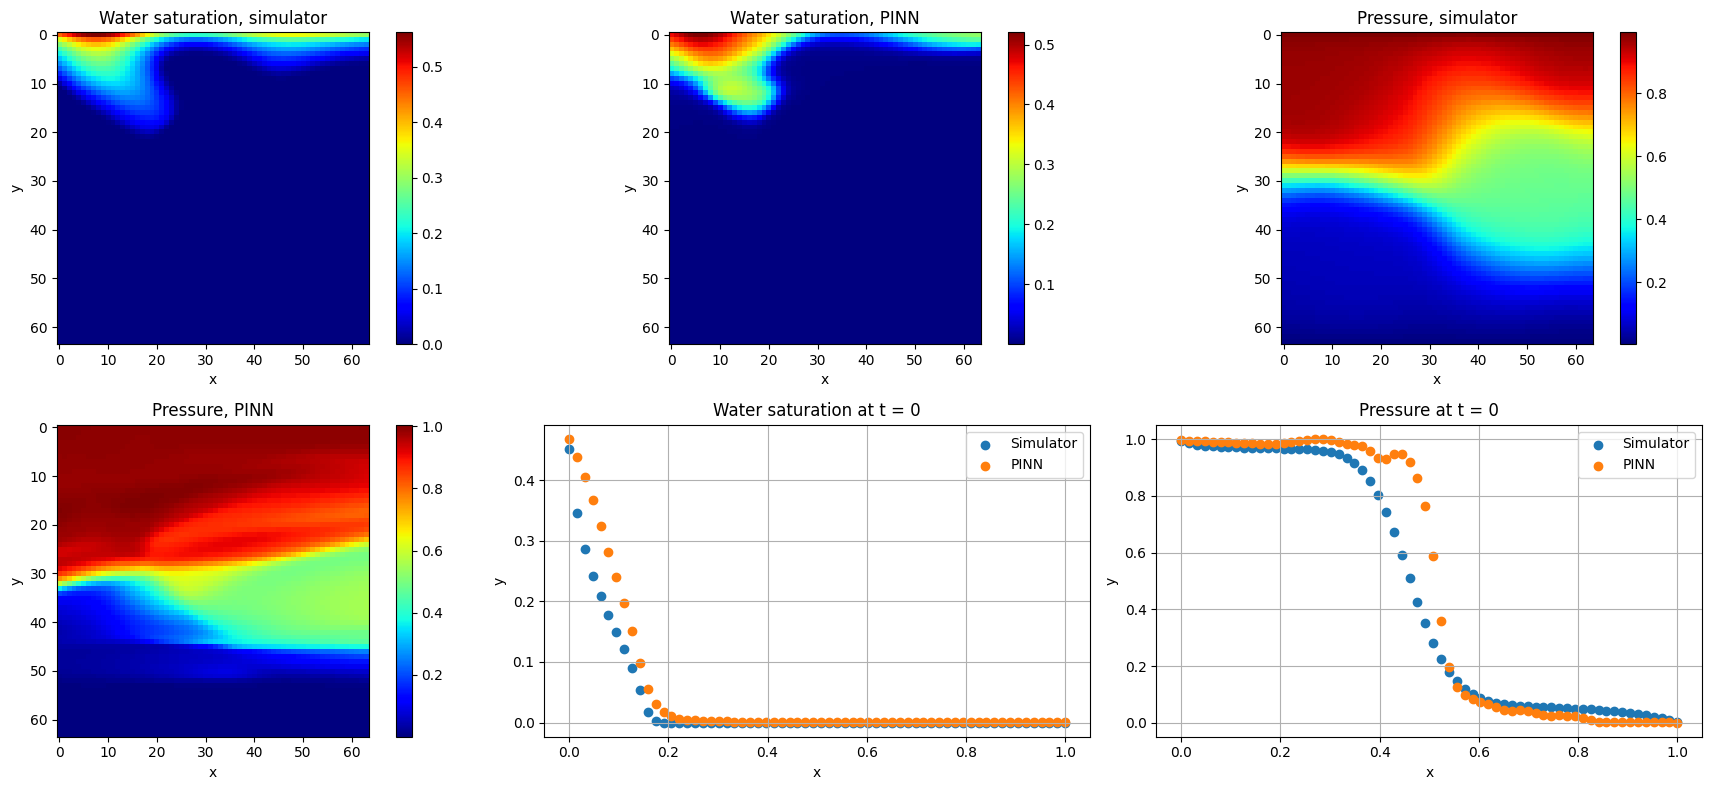

Epoch: 2820 | Loss: 0.00020 | PDE: 0.00105 | BC: 0.00008 | Data: 0.00061
Epoch: 2840 | Loss: 0.00022 | PDE: 0.00106 | BC: 0.00008 | Data: 0.00060
Epoch: 2860 | Loss: 0.00021 | PDE: 0.00105 | BC: 0.00008 | Data: 0.00060
Epoch: 2880 | Loss: 0.00021 | PDE: 0.00104 | BC: 0.00008 | Data: 0.00059
Epoch: 2900 | Loss: 0.00020 | PDE: 0.00103 | BC: 0.00008 | Data: 0.00059
Epoch: 2920 | Loss: 0.00021 | PDE: 0.00104 | BC: 0.00008 | Data: 0.00058
Epoch: 2940 | Loss: 0.00022 | PDE: 0.00105 | BC: 0.00007 | Data: 0.00058
Epoch: 2960 | Loss: 0.00078 | PDE: 0.00187 | BC: 0.00012 | Data: 0.00081
Epoch: 2980 | Loss: 0.00027 | PDE: 0.00105 | BC: 0.00009 | Data: 0.00068
Epoch: 3000 | Loss: 0.00020 | PDE: 0.00092 | BC: 0.00008 | Data: 0.00065


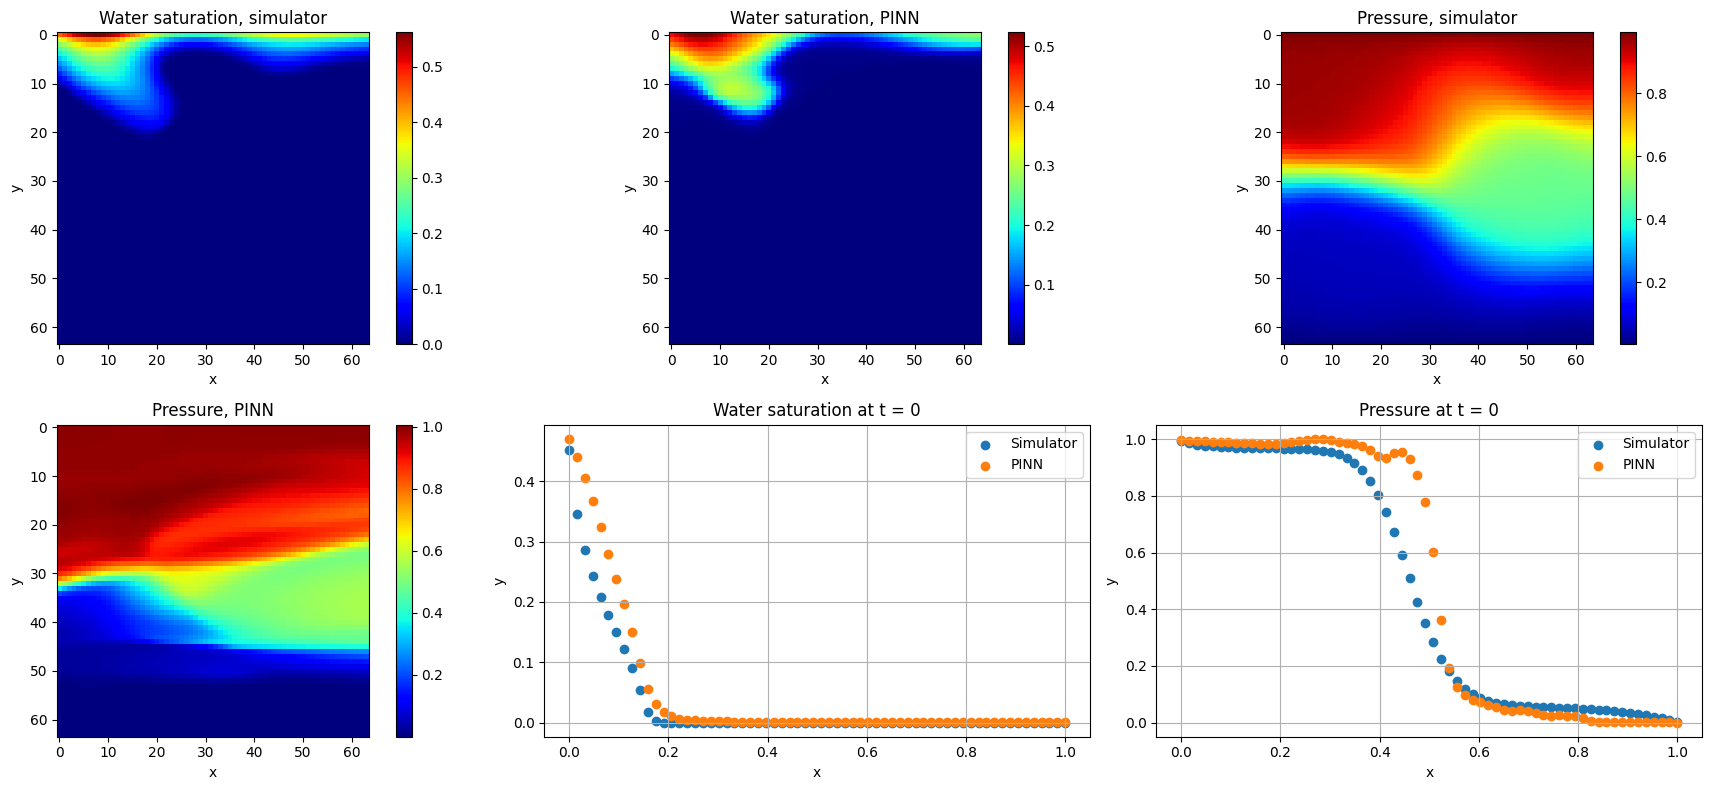

Epoch: 3020 | Loss: 0.00021 | PDE: 0.00095 | BC: 0.00008 | Data: 0.00062
Epoch: 3040 | Loss: 0.00020 | PDE: 0.00097 | BC: 0.00007 | Data: 0.00061
Epoch: 3060 | Loss: 0.00020 | PDE: 0.00098 | BC: 0.00008 | Data: 0.00060
Epoch: 3080 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00059
Epoch: 3100 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00059
Epoch: 3120 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00058
Epoch: 3140 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00058
Epoch: 3160 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00057
Epoch: 3180 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00057
Epoch: 3200 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00057


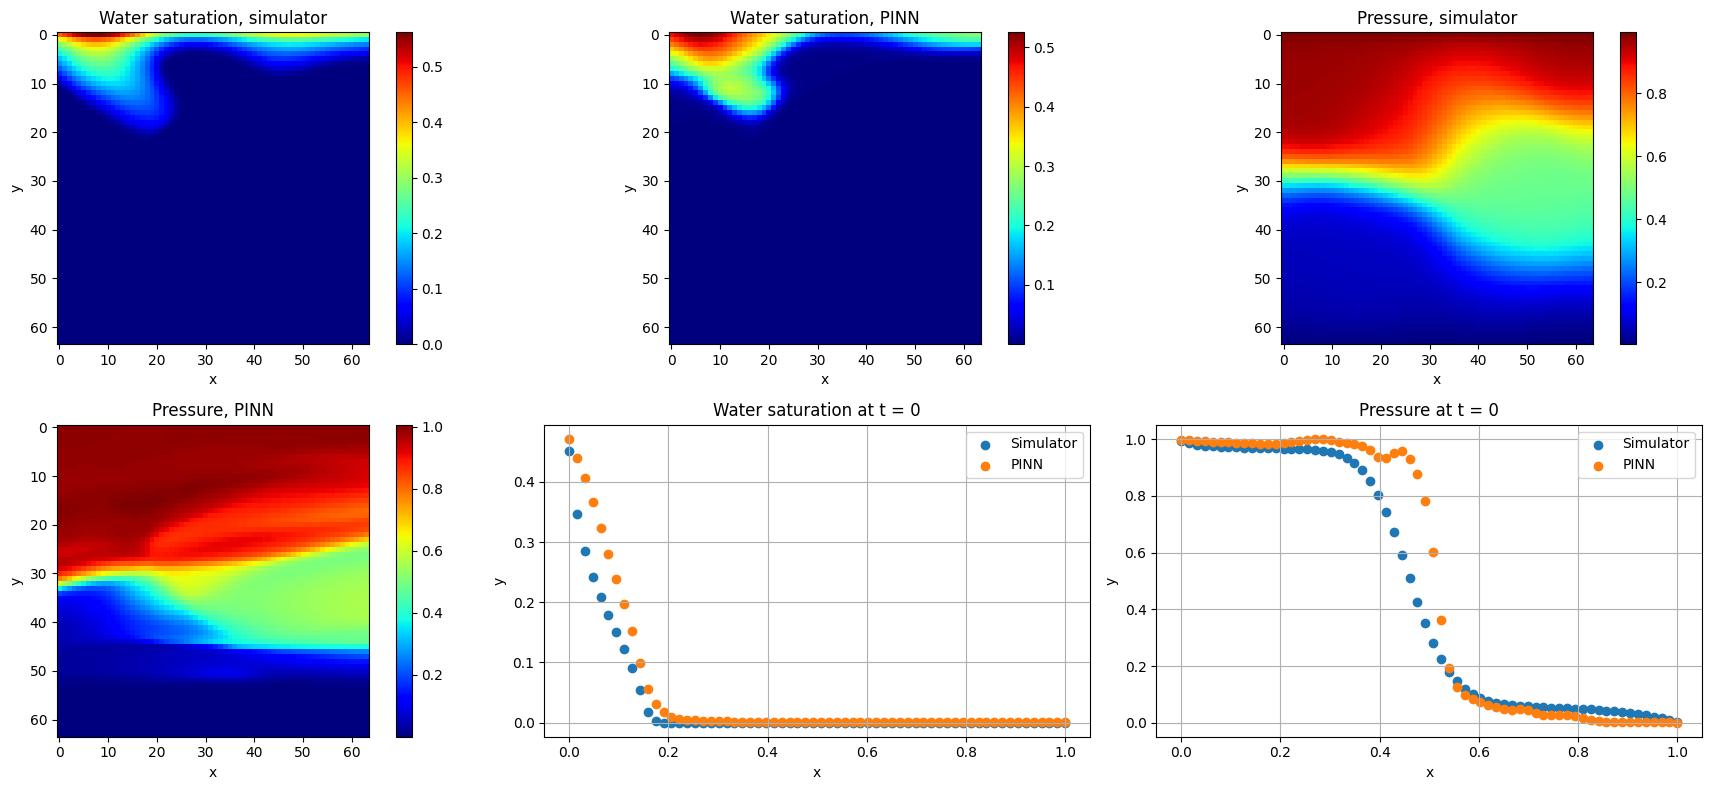

Epoch: 3220 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00056
Epoch: 3240 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00056
Epoch: 3260 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00056
Epoch: 3280 | Loss: 0.00020 | PDE: 0.00100 | BC: 0.00007 | Data: 0.00055
Epoch: 3300 | Loss: 0.00020 | PDE: 0.00100 | BC: 0.00007 | Data: 0.00055
Epoch: 3320 | Loss: 0.00020 | PDE: 0.00100 | BC: 0.00007 | Data: 0.00055
Epoch: 3340 | Loss: 0.00020 | PDE: 0.00100 | BC: 0.00007 | Data: 0.00055
Epoch: 3360 | Loss: 0.00020 | PDE: 0.00100 | BC: 0.00007 | Data: 0.00054
Epoch: 3380 | Loss: 0.00020 | PDE: 0.00100 | BC: 0.00007 | Data: 0.00054
Epoch: 3400 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00054


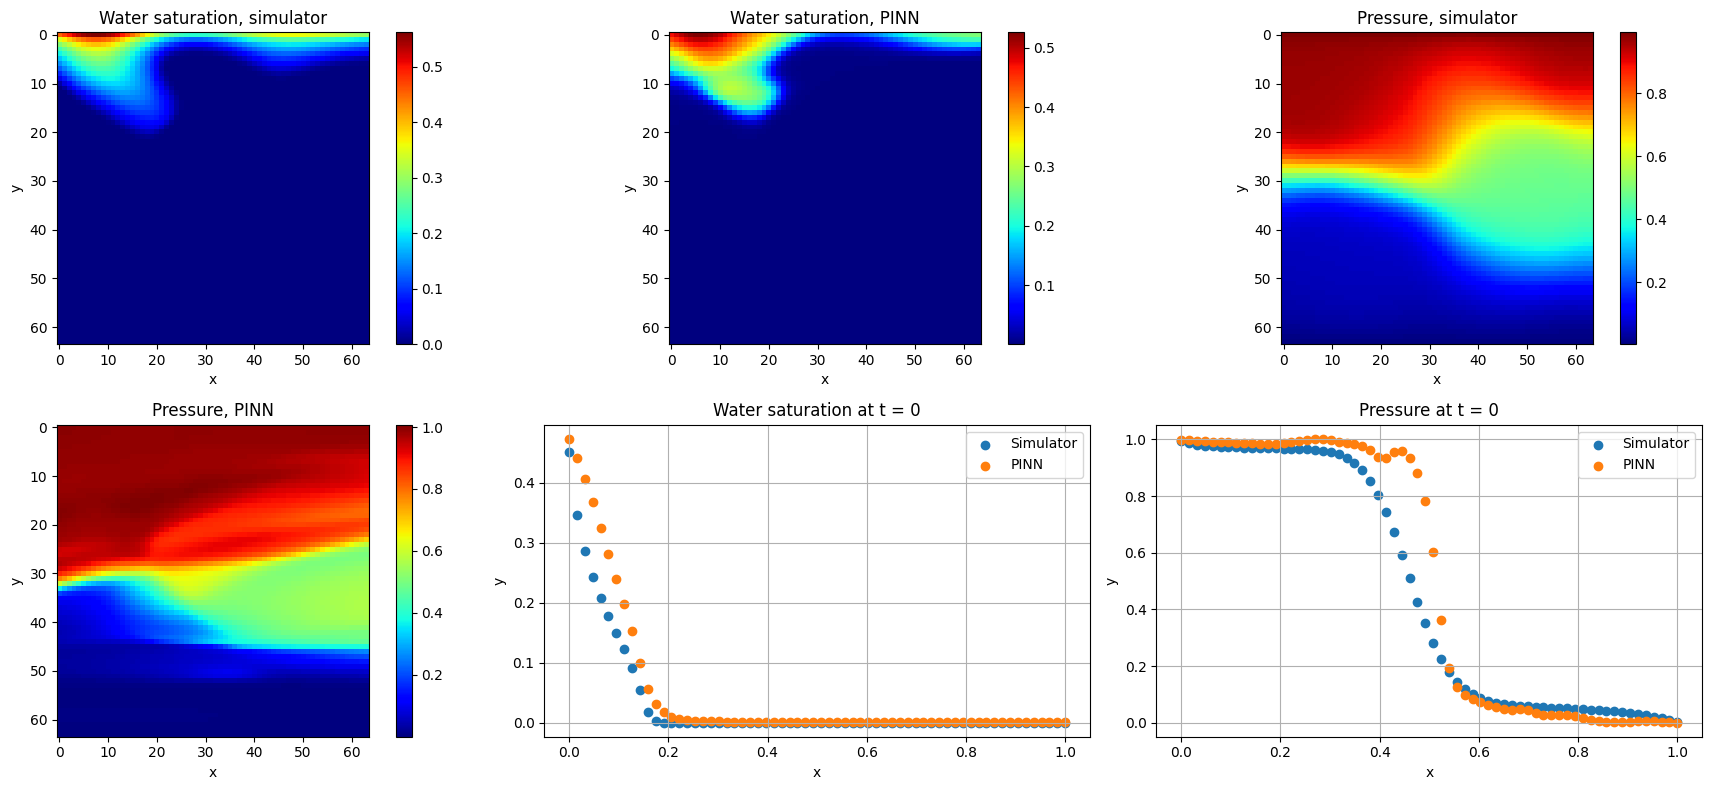

Epoch: 3420 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00054
Epoch: 3440 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00053
Epoch: 3460 | Loss: 0.00020 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00053
Epoch: 3480 | Loss: 0.00019 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00053
Epoch: 3500 | Loss: 0.00019 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00053
Epoch: 3520 | Loss: 0.00019 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00052
Epoch: 3540 | Loss: 0.00019 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00052
Epoch: 3560 | Loss: 0.00019 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00052
Epoch: 3580 | Loss: 0.00019 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00052
Epoch: 3600 | Loss: 0.00019 | PDE: 0.00099 | BC: 0.00007 | Data: 0.00052


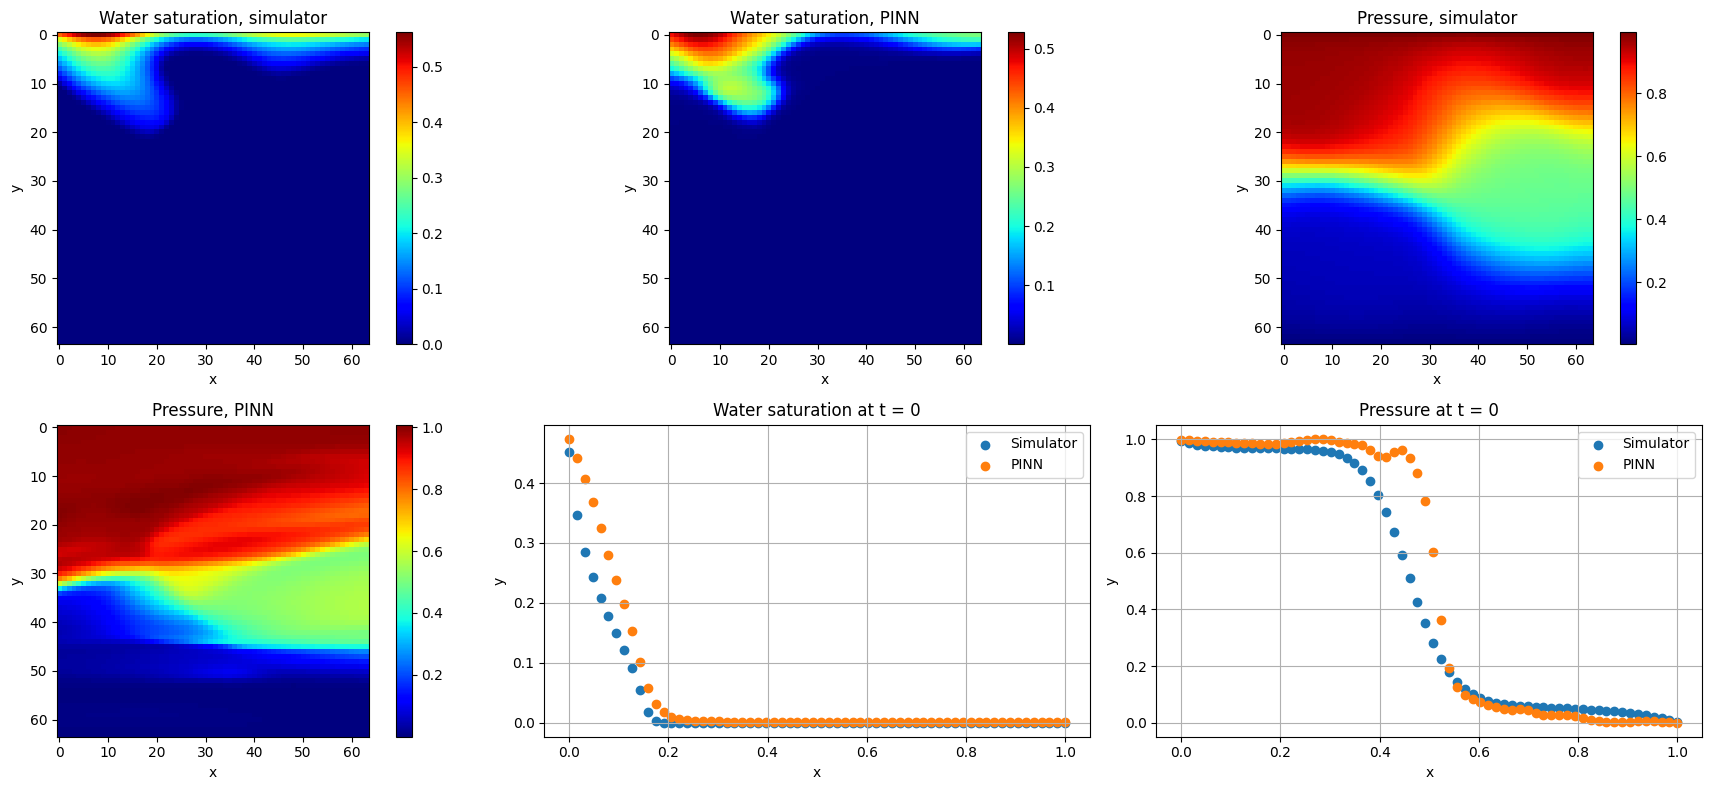

KeyboardInterrupt: 

In [32]:
epochs = 20_000

# Initialize Model
# model = pinn_model().to(DEVICE)
# model = ModifiedPINN(
#    input_dim=7,
#    hidden_dim=128,
#    num_layers=5,
#    output_dim=7
# ).to(DEVICE)
DEVICE = 'cpu'
model = ModifiedPINN(
   input_dim=7,
   hidden_dim=128,  # Try 128, 256
   num_layers=6,    # Try 5-8
   output_dim=7
).to(DEVICE)
model.load_state_dict(torch.load('pinn-test4-250-batched-new.pth',map_location=DEVICE))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
min_loss = float('inf')  # Renamed from max_dist for clarity

# ============================================================================
# PREPARE FULL DATASETS ON DEVICE (Done once before loop)
# ============================================================================

# 1. PDE / Collocation Points (All points)
points_full = points.to(DEVICE)

# 2. Permeability Vector (All points)
# Assuming 'perm', 'x', and 'y' are aligned with 'points'
perm_vec_full = torch.tensor(
    perm[list(x.cpu().detach().numpy().astype(int)), 
         list(y.cpu().detach().numpy().astype(int)), -1].astype(np.float32)
).to(DEVICE)

# 3. Boundary Condition Points (All points)
pres0_pts = pres0_x1_points.to(DEVICE)
pres1_pts = pres1_x1_points.to(DEVICE)
soil0_pts = soil0_x1_points.to(DEVICE)
swat0_pts = swat0_x1_points.to(DEVICE)

# 4. Simulation / Data Fitting Points (All points)
data_points_full = points.to(DEVICE) # Assuming simulation data aligns with points
sim_data_full = simulation_data_train.to(DEVICE)

# ============================================================================
# MAIN TRAINING LOOP (FULL BATCH)
# ============================================================================

for cur_epoch in trange(epochs):
    
    optimizer.zero_grad()
    
    # --------------------------------------------------------------------
    # 1. PDE RESIDUALS (Full Dataset)
    # --------------------------------------------------------------------
    # Compute residuals on all points at once
    
    
    r1, r2, r3_x1, r3_x2, r4_x1, r4_x2, r5, _ = \
        compute_pde_residuals(model, points_full, perm_vec_full)
    
    loss0 = torch.mean(
        r1**2 + r2**2 + r3_x1**2 + r3_x2**2 + r4_x1**2 + r4_x2**2 + r5**2
    )
    
    # --------------------------------------------------------------------
    # 2. BOUNDARY CONDITIONS (Full Dataset)
    # --------------------------------------------------------------------
    # Predict on all boundary points
    press0 = model(pres0_pts)[:, 0]
    press1 = model(pres1_pts)[:, 0]
    soil0 = model(soil0_pts)[:, 1]
    swat0 = model(swat0_pts)[:, 2]
    
    loss1 = torch.mean(
        (press0 - 1.0)**2 + press1**2 + 
        (soil0 - 1.0)**2 + swat0**2
    )
    
    # --------------------------------------------------------------------
    # 3. DATA LOSS (Full Dataset)
    # --------------------------------------------------------------------
    # Predict on all data points
    model_res_data = model(data_points_full)
    
    loss2 = torch.mean(
        (model_res_data[:, 0] - sim_data_full[:, 0])**2 + 
        (model_res_data[:, 2] - sim_data_full[:, 1])**2 + 
        (model_res_data[:, 1] - sim_data_full[:, 2])**2
    )
    
    # --------------------------------------------------------------------
    # DYNAMIC WEIGHTS & BACKWARD
    # --------------------------------------------------------------------
    # Compute weights based on the full-batch gradients/losses
    w_ic, w_pde, w_data = compute_weights_grad_orthogonal_autograd(
        model, loss1, loss0, loss2, kappa=8.0
    )
    
    loss = w_pde * loss0 + w_ic * loss1 + w_data * loss2
    
    loss.backward()
    
    # Optional: Gradient clipping usually helps stability even in full batch
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    # --------------------------------------------------------------------
    # LOGGING & SAVING
    # --------------------------------------------------------------------
    # Current unweighted total loss for comparison
    current_total_dist = loss0.item() + loss1.item() + loss2.item()
    
    if cur_epoch % 20 == 0:
        print(f'Epoch: {cur_epoch} | Loss: {loss.item():.5f} | PDE: {loss0.item():.5f} | BC: {loss1.item():.5f} | Data: {loss2.item():.5f}')
        
    if cur_epoch % 200 == 0:
         # Assuming plot_validation handles moving data to CPU internally if needed
        plot_validation(model, PRES, SWAT, SOIL, device=DEVICE)

    if current_total_dist < min_loss:
        torch.save(model.state_dict(), 'pinn_fullbatch_500-pre-trained-3.pth')
        min_loss = current_total_dist
        
    # Learning rate scheduler
    if cur_epoch % 300 == 0 and cur_epoch > 0:
        optimizer.param_groups[0]['lr'] *= 0.9

  0%|          | 0/30000 [00:00<?, ?it/s]

epoch: 0	loss: (0.6933379854474749, 1.1463757114750999, 0.6158218894686017, 0.6158218894686017)	


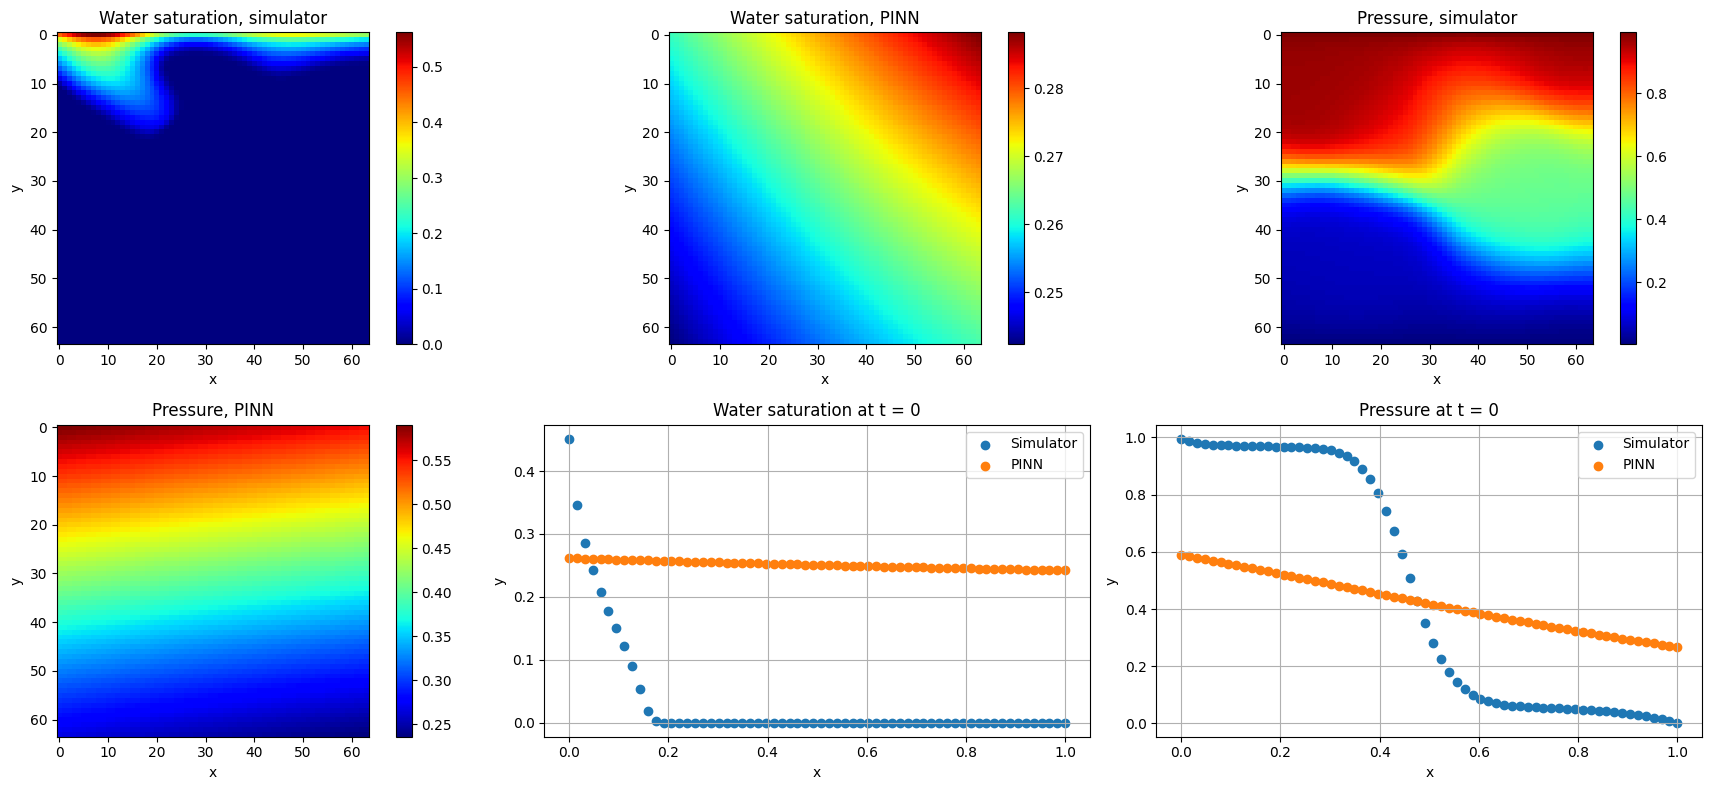

epoch: 20	loss: (0.02771469418491636, 0.04088718311062881, 0.008934009221515484, 0.008934009221515484)	
epoch: 40	loss: (0.023214551753231456, 0.03895445114799908, 0.004787326391254153, 0.004787326391254153)	
epoch: 60	loss: (0.021747976009334837, 0.03808748535811901, 0.002744870027527213, 0.002744870027527213)	
epoch: 80	loss: (0.02211980920817171, 0.04078688605555466, 0.003753155203802245, 0.003753155203802245)	
epoch: 100	loss: (0.020000170916318893, 0.03664397355169058, 0.0033369211346975397, 0.0033369211346975397)	
epoch: 120	loss: (0.01794455260304468, 0.034879687508302074, 0.002478445164992341, 0.002478445164992341)	
epoch: 140	loss: (0.0508675267919898, 0.06333463452756405, 0.0018205449284453476, 0.0018205449284453476)	
epoch: 160	loss: (0.02044402195938996, 0.033383714966475964, 0.0030103170179894994, 0.0030103170179894994)	
epoch: 180	loss: (0.01793556467496923, 0.03116572887769767, 0.0006862148501178515, 0.0006862148501178515)	
epoch: 200	loss: (0.022205342738223926, 0.03283

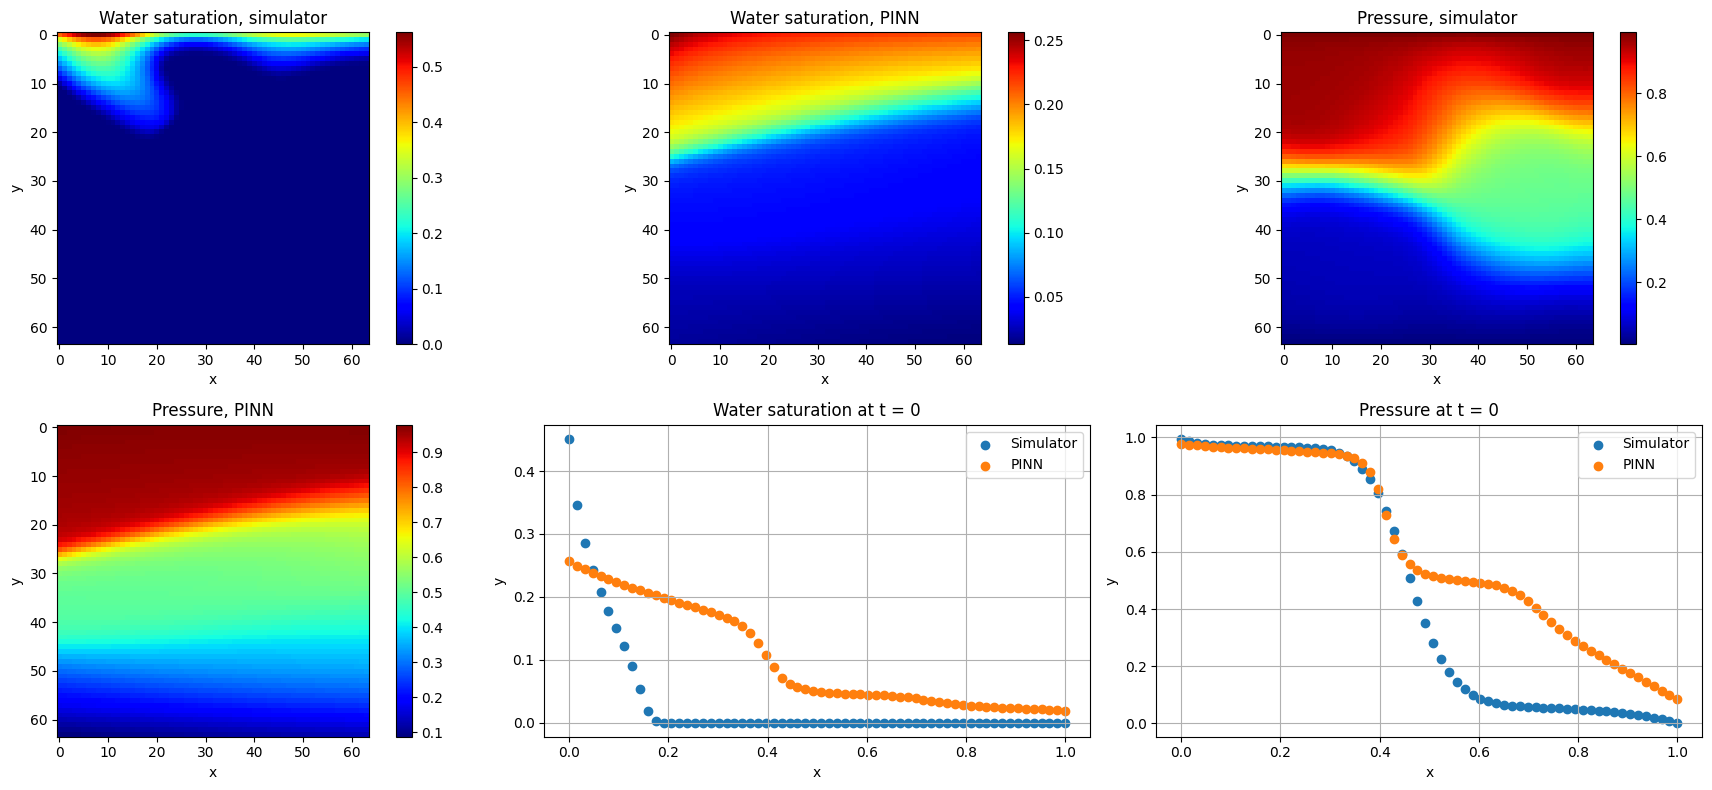

epoch: 220	loss: (0.022018377669155598, 0.046252774340765815, 0.0011335705889255873, 0.0011335705889255873)	
epoch: 240	loss: (0.051784113847783635, 0.07404583373240062, 0.0011413840319229557, 0.0011413840319229557)	
epoch: 260	loss: (0.04165391464318548, 0.0644628924450704, 0.006209590272711856, 0.006209590272711856)	
epoch: 280	loss: (0.006330392589526517, 0.01689861249178648, 0.00025852160719555935, 0.00025852160719555935)	
epoch: 300	loss: (0.0033006712162335005, 0.005546469607257417, 0.00029584745061583817, 0.00029584745061583817)	
epoch: 320	loss: (0.004322880496537047, 0.012028634016002928, 0.00047492686384690126, 0.00047492686384690126)	
epoch: 340	loss: (0.007254689133593014, 0.014484854015920843, 0.0012954867145578777, 0.0012954867145578777)	
epoch: 360	loss: (0.040804075343268256, 0.05834994252238955, 0.018998158496937582, 0.018998158496937582)	
epoch: 380	loss: (0.03364051505923271, 0.054934621921607425, 0.011227003431745939, 0.011227003431745939)	
epoch: 400	loss: (0.13295

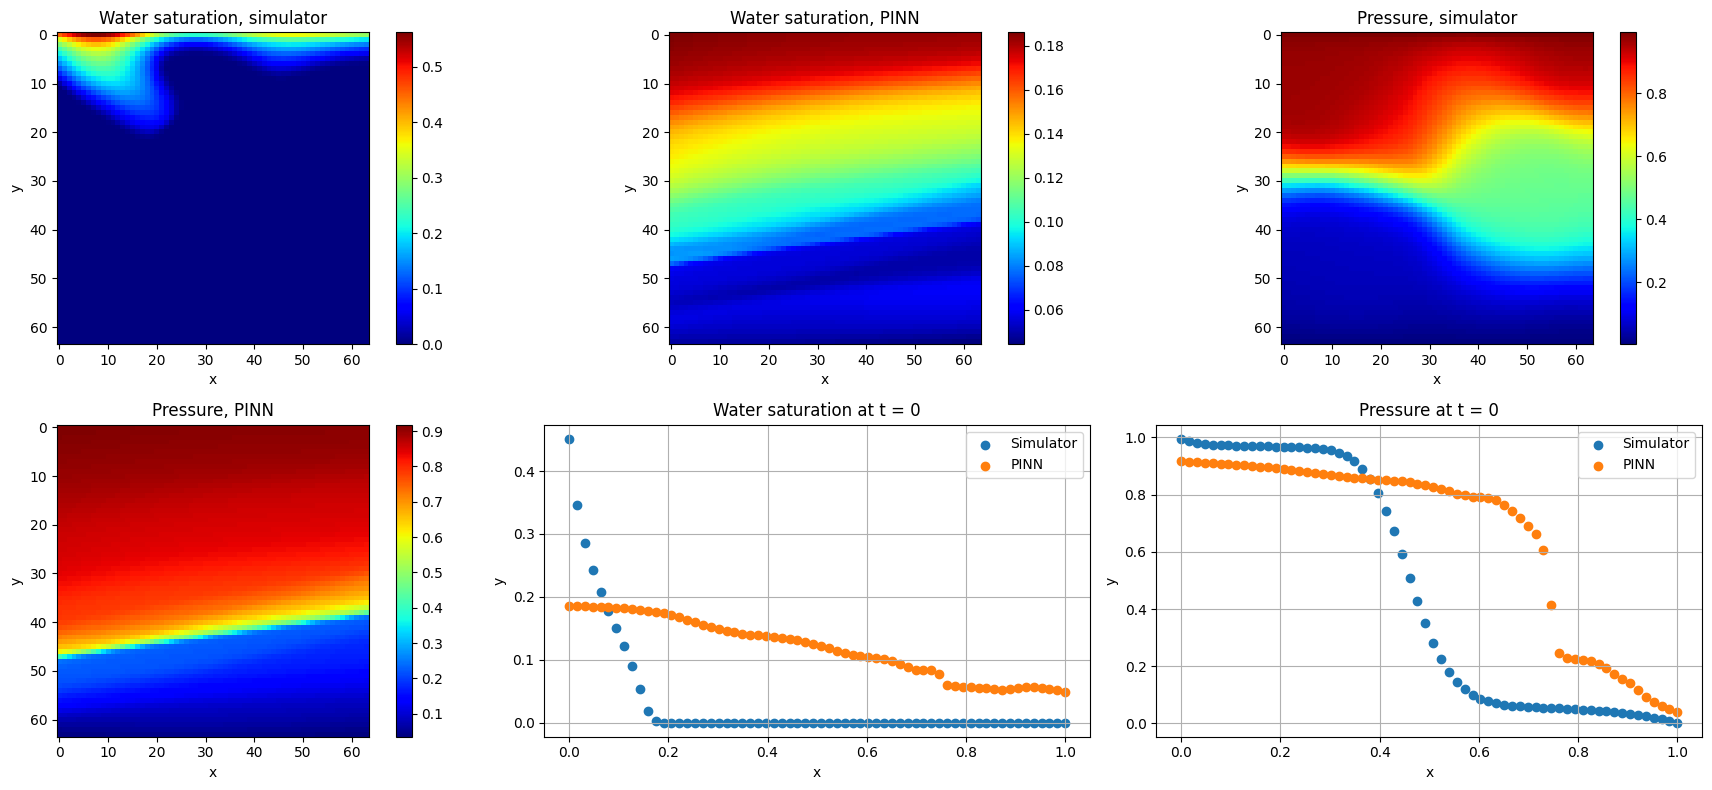

epoch: 420	loss: (0.0604102619524513, 0.08346028998494148, 0.008454381222171443, 0.008454381222171443)	
epoch: 440	loss: (0.03616862105471747, 0.054539287995014875, 0.011289754948977913, 0.011289754948977913)	
epoch: 460	loss: (0.026924822479486465, 0.050998971930571964, 0.004245448857545853, 0.004245448857545853)	
epoch: 480	loss: (0.04123048271451678, 0.06122116505035332, 0.004578342594738517, 0.004578342594738517)	
epoch: 500	loss: (0.15724520784403598, 0.18338897079229355, 0.014290850742587022, 0.014290850742587022)	
epoch: 520	loss: (0.0594793331942388, 0.0763384633298431, 0.026629235595464706, 0.026629235595464706)	
epoch: 540	loss: (0.10159677692822047, 0.11989206182105201, 0.009530612267553806, 0.009530612267553806)	
epoch: 560	loss: (0.025632080755063465, 0.0463771963758128, 0.004287365241907537, 0.004287365241907537)	
epoch: 580	loss: (0.04526545612939766, 0.06411442479916982, 0.004232856145660792, 0.004232856145660792)	
epoch: 600	loss: (0.05735064963144915, 0.08541320370776

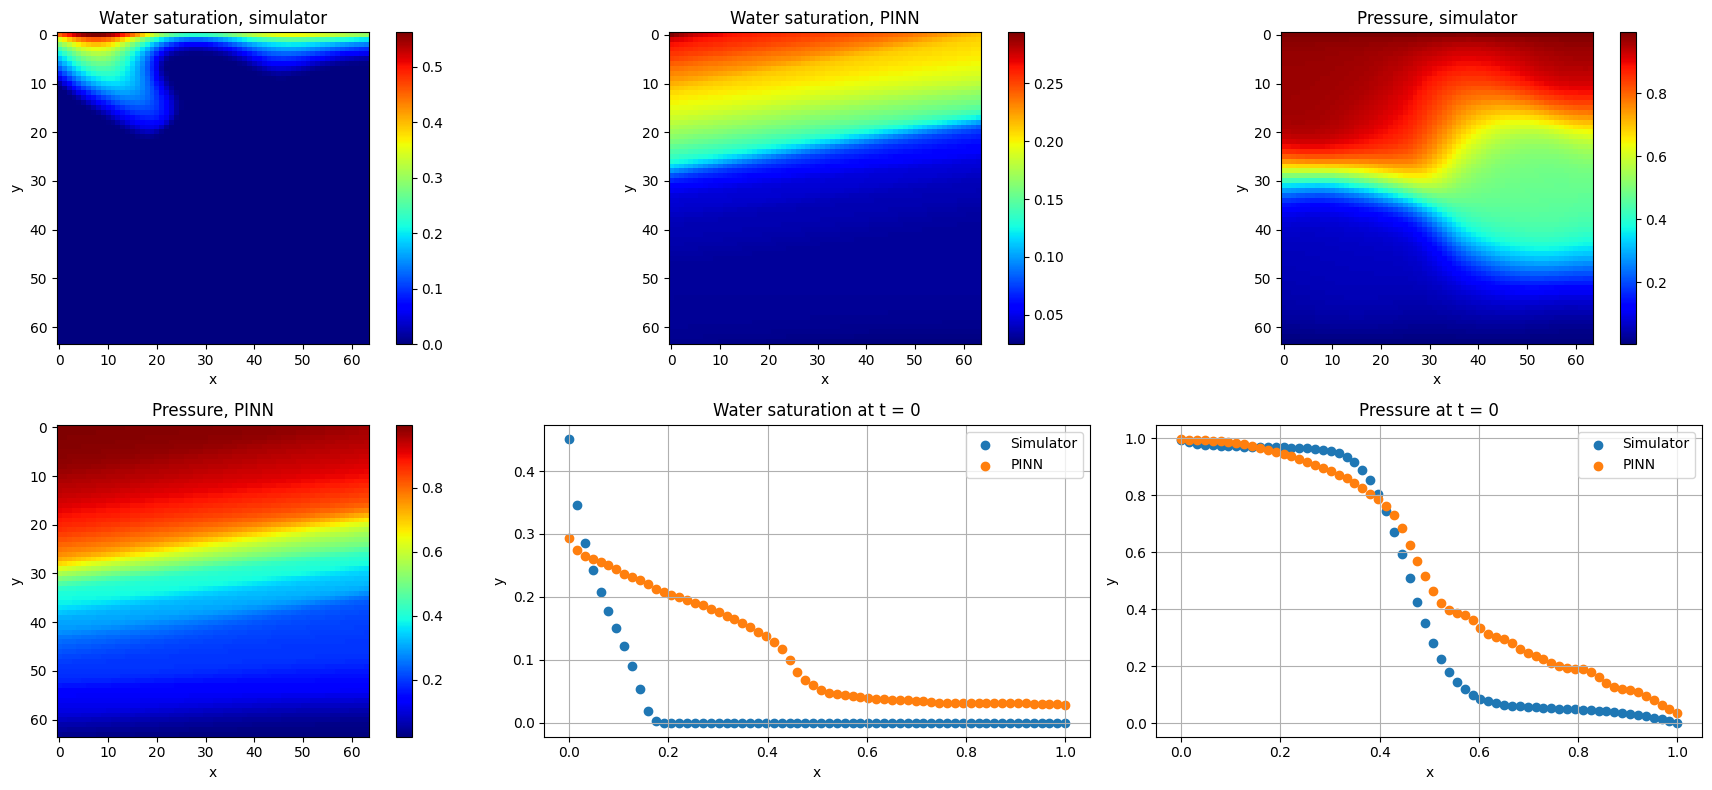

epoch: 620	loss: (0.03129202925733158, 0.05552805534430912, 0.0018064854167667882, 0.0018064854167667882)	
epoch: 640	loss: (0.09498711582273245, 0.10556614212691784, 0.002691549265624157, 0.002691549265624157)	
epoch: 660	loss: (0.02689501510134765, 0.0472881623676845, 0.00772520387545228, 0.00772520387545228)	
epoch: 680	loss: (0.019292217546275685, 0.03386272782725947, 0.004167126990588648, 0.004167126990588648)	
epoch: 700	loss: (0.020358975444521223, 0.03216452111623117, 0.0019170098987940168, 0.0019170098987940168)	
epoch: 720	loss: (0.002584624619755362, 0.00821874789627535, 0.00046255170101565976, 0.00046255170101565976)	
epoch: 740	loss: (0.0024665763235784005, 0.007881381415895053, 0.0003530081989343411, 0.0003530081989343411)	
epoch: 760	loss: (0.0016851788386702538, 0.006356803434235709, 0.00027601586771197617, 0.00027601586771197617)	
epoch: 780	loss: (0.002268784829149289, 0.006326535117945501, 0.0003271101616389517, 0.0003271101616389517)	
epoch: 800	loss: (0.00218069006

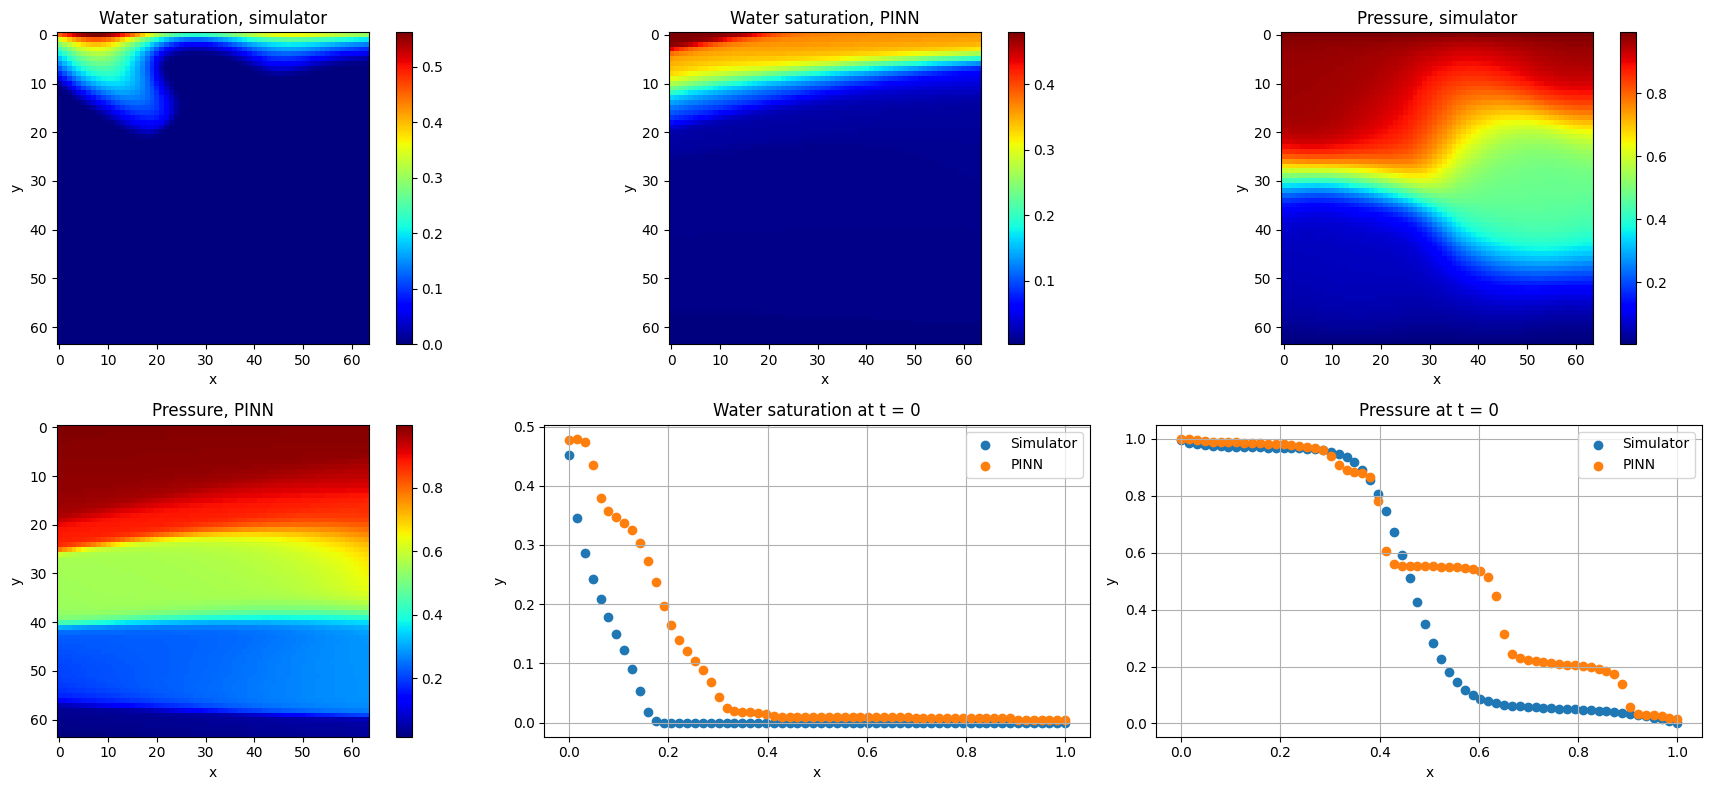

epoch: 820	loss: (0.0015199018026968198, 0.006373033858835697, 0.0003297638613730669, 0.0003297638613730669)	
epoch: 840	loss: (0.008469707315920718, 0.016394308901258876, 0.0001956736502636756, 0.0001956736502636756)	
epoch: 860	loss: (0.0017992510360532574, 0.007097363738077027, 0.0002462144766468555, 0.0002462144766468555)	
epoch: 880	loss: (0.0019665979613949147, 0.00680312913443361, 0.00022231163165997714, 0.00022231163165997714)	
epoch: 900	loss: (3.660922186715262, 3.6995749303272794, 0.016446180774697235, 0.016446180774697235)	
epoch: 920	loss: (0.031371528814945905, 0.05616335730467524, 0.006919977122119495, 0.006919977122119495)	
epoch: 940	loss: (0.0272872620927436, 0.051354305020400455, 0.0040040535386651754, 0.0040040535386651754)	
epoch: 960	loss: (0.04369409927832229, 0.05777816953403609, 0.0038236839630241904, 0.0038236839630241904)	
epoch: 980	loss: (0.061549878280077665, 0.08895539811679296, 0.0028485016830797705, 0.0028485016830797705)	
epoch: 1000	loss: (0.059244491

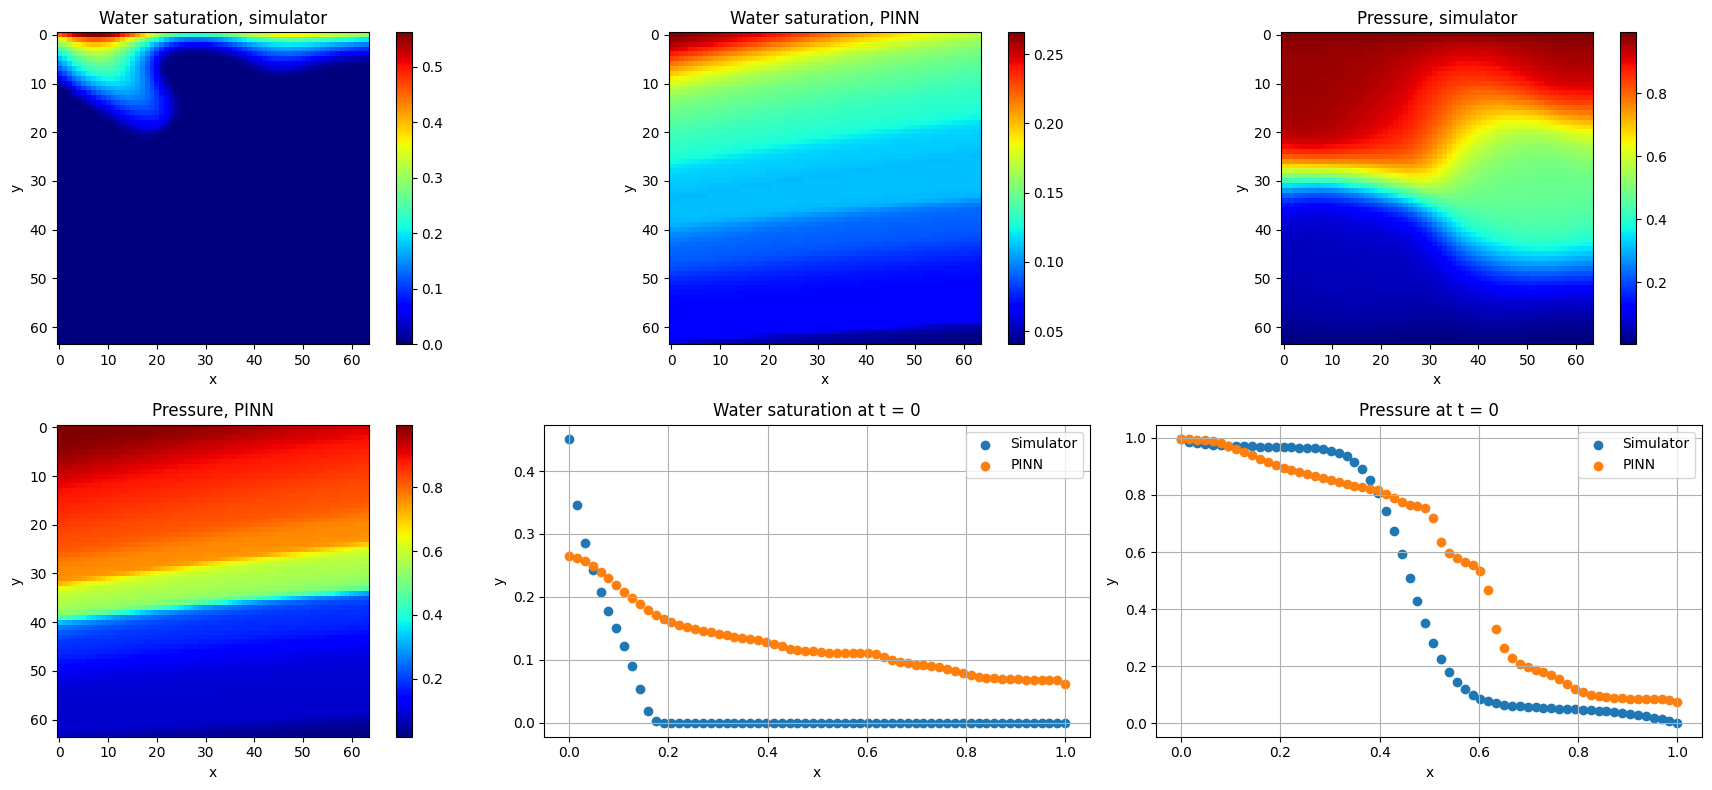

epoch: 1020	loss: (0.10833738265292985, 0.1231444568506309, 0.016829205943005427, 0.016829205943005427)	
epoch: 1040	loss: (0.026274300047329495, 0.042252875066229274, 0.008116539734016572, 0.008116539734016572)	
epoch: 1060	loss: (0.031811340911579986, 0.05175011817898069, 0.00570717962857868, 0.00570717962857868)	
epoch: 1080	loss: (2.413882613182068, 2.449265020234244, 0.0029221105089943323, 0.0029221105089943323)	
epoch: 1100	loss: (0.01882938528433442, 0.028104820155671666, 0.004131709059168186, 0.004131709059168186)	
epoch: 1120	loss: (0.04530939240274685, 0.05115374104518976, 0.0003684119146782905, 0.0003684119146782905)	
epoch: 1140	loss: (0.003995574511853712, 0.010740574316254683, 0.001402590939375971, 0.001402590939375971)	
epoch: 1160	loss: (0.00317960578416075, 0.008521806315651961, 0.001297611211027418, 0.001297611211027418)	
epoch: 1180	loss: (0.00261897620345865, 0.00860920422045248, 0.0009223455646341401, 0.0009223455646341401)	
epoch: 1200	loss: (0.0031138556078076363

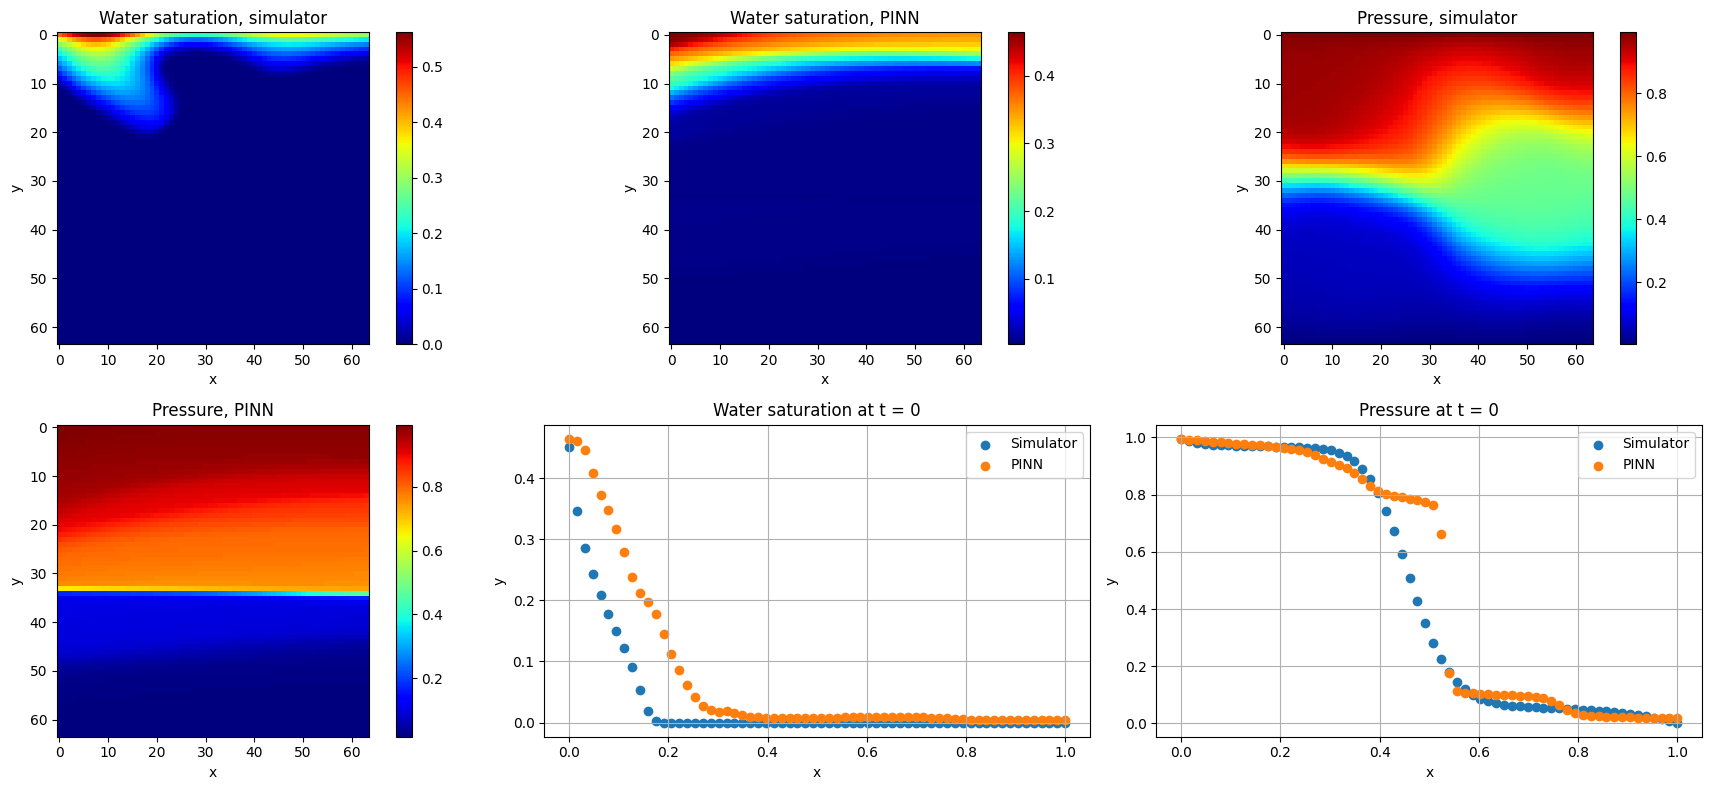

epoch: 1220	loss: (0.0032026030988033327, 0.008137778245976992, 0.0007424399123660155, 0.0007424399123660155)	
epoch: 1240	loss: (0.002592193228857858, 0.009882762895098754, 0.0005026116019247898, 0.0005026116019247898)	
epoch: 1260	loss: (0.002184829258892153, 0.006263964609908206, 0.00034387834187197896, 0.00034387834187197896)	
epoch: 1280	loss: (0.0020547862098153147, 0.0054281288757920265, 0.0008218624030372926, 0.0008218624030372926)	
epoch: 1300	loss: (0.0016510347237012216, 0.005403012635984591, 0.0008458033137555633, 0.0008458033137555633)	
epoch: 1320	loss: (0.006065952558336514, 0.009392358894859041, 0.0013511592322694404, 0.0013511592322694404)	
epoch: 1340	loss: (0.002292712950812919, 0.005621901912880796, 0.0012838700037848736, 0.0012838700037848736)	
epoch: 1360	loss: (0.0019141129284564937, 0.0059914264961012775, 0.0005760008685423859, 0.0005760008685423859)	
epoch: 1380	loss: (0.0019849997146853377, 0.006749028938689402, 0.0006920044044298786, 0.0006920044044298786)	
e

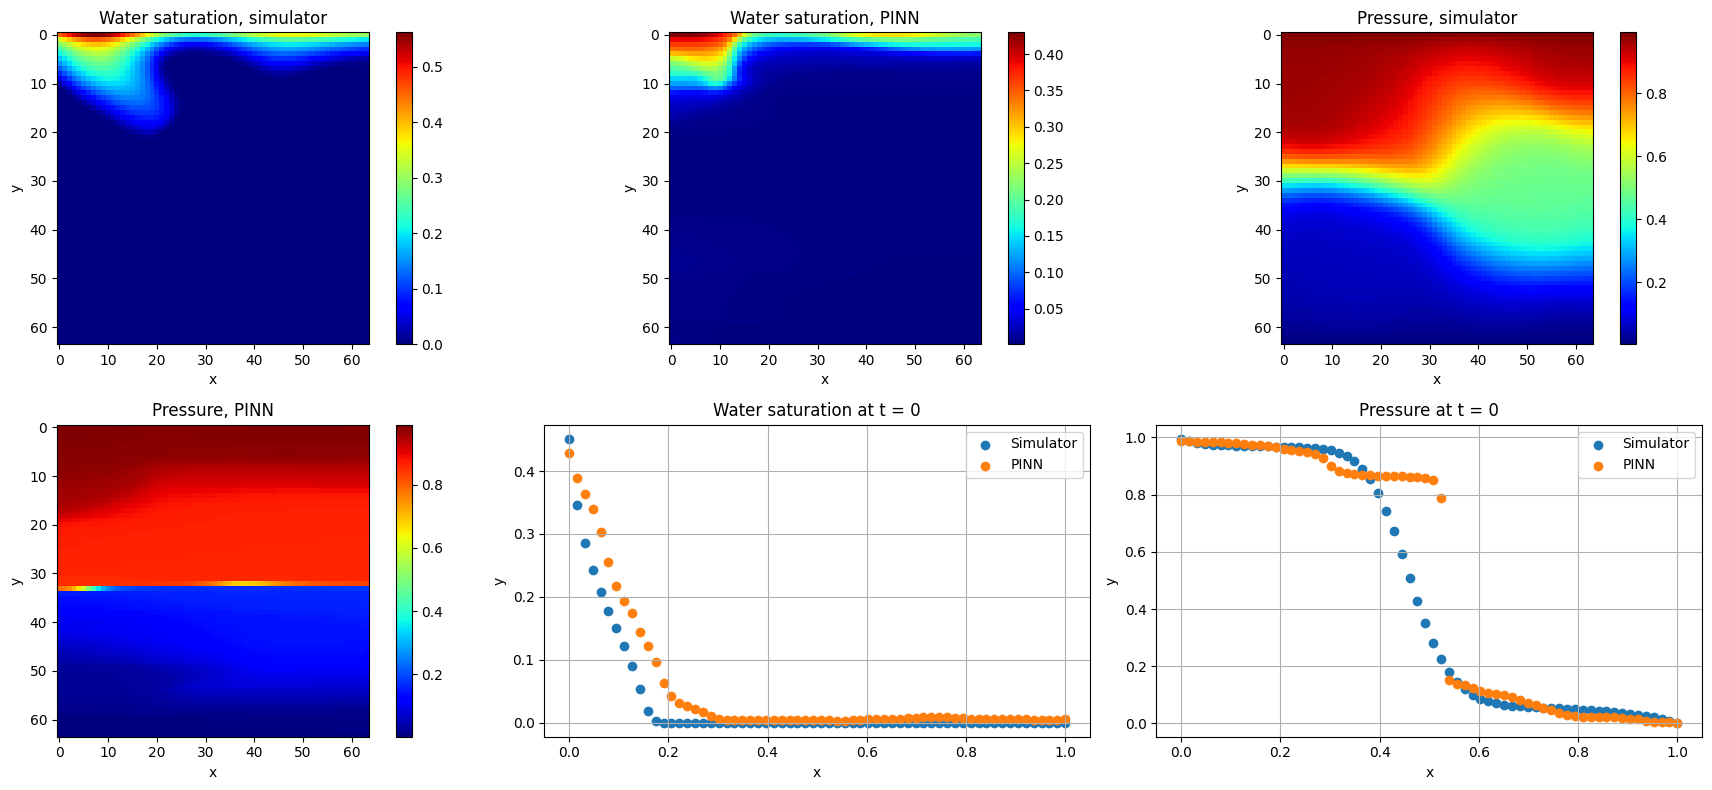

epoch: 1420	loss: (0.005077079138053315, 0.010482047551444598, 0.0008591556522463049, 0.0008591556522463049)	
epoch: 1440	loss: (0.0037011212137128624, 0.011810863324041878, 0.000542340862531481, 0.000542340862531481)	
epoch: 1460	loss: (0.1409918125718832, 0.1624449768236705, 0.004615740950352379, 0.004615740950352379)	
epoch: 1480	loss: (0.03573093616536686, 0.05728188582829067, 0.011811486445367336, 0.011811486445367336)	
epoch: 1500	loss: (0.09829033033124038, 0.11211761433098998, 0.014577089542789119, 0.014577089542789119)	
epoch: 1520	loss: (0.06282499166471618, 0.08704174629279546, 0.010232431681028433, 0.010232431681028433)	
epoch: 1540	loss: (0.17033243791333266, 0.19044367037713528, 0.005640650168061256, 0.005640650168061256)	
epoch: 1560	loss: (0.01872323067592723, 0.034746257322175164, 0.0046191534493118525, 0.0046191534493118525)	
epoch: 1580	loss: (0.02215775102376938, 0.0334800910204649, 0.005480543710291386, 0.005480543710291386)	
epoch: 1600	loss: (0.04754794069698879,

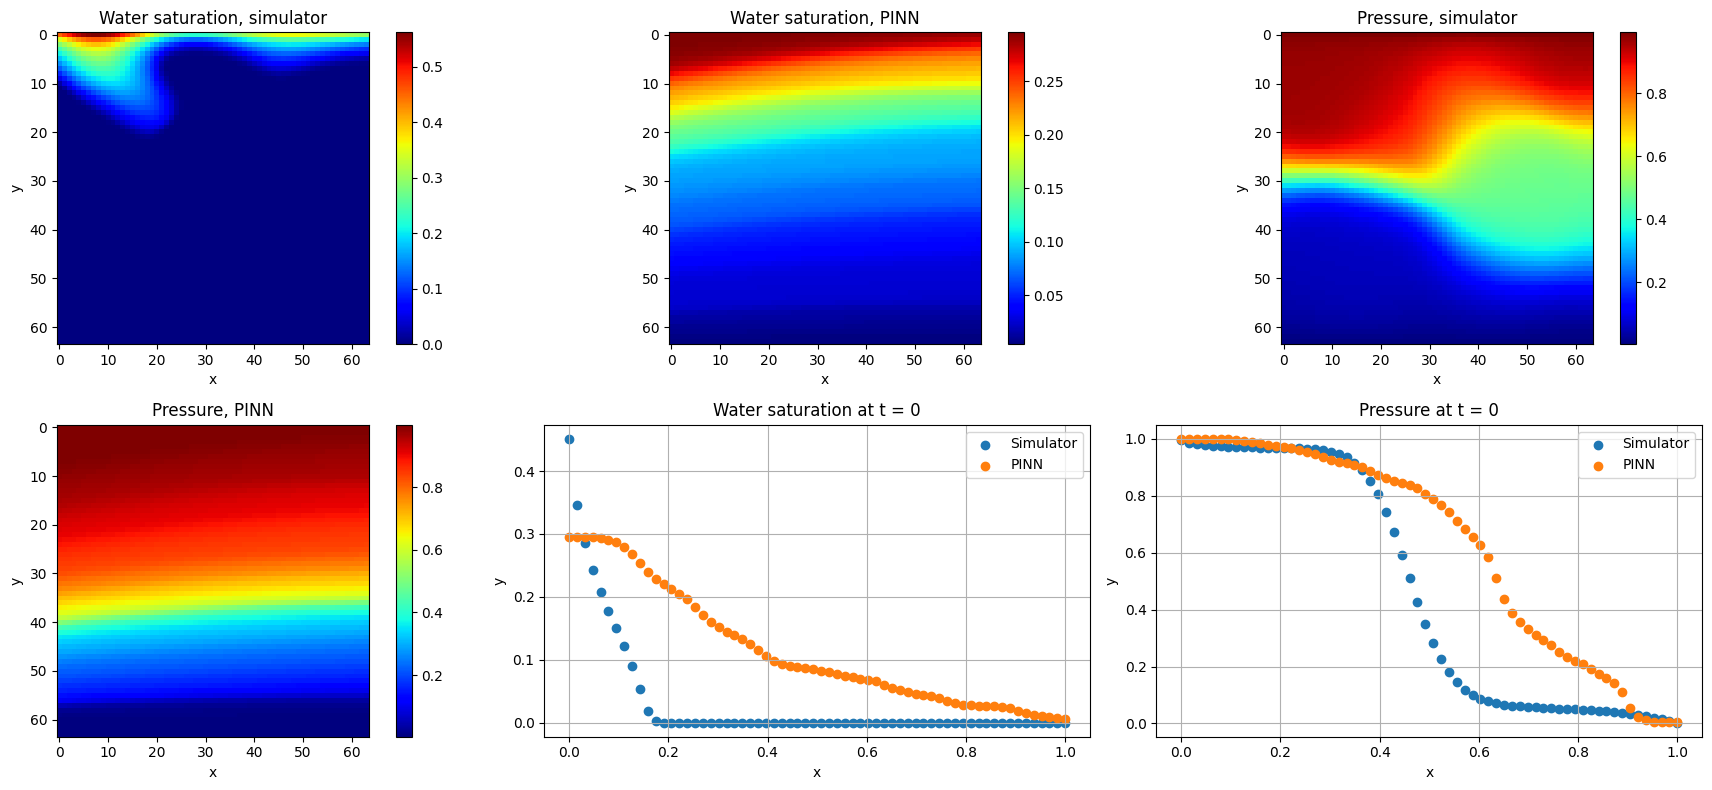

epoch: 1620	loss: (0.04120338535202401, 0.06372257508337498, 0.010969089011528663, 0.010969089011528663)	
epoch: 1640	loss: (0.026348764742059366, 0.051213309700999944, 0.00946333259344101, 0.00946333259344101)	
epoch: 1660	loss: (0.02509314247540065, 0.049324530575956614, 0.005776412053299802, 0.005776412053299802)	
epoch: 1680	loss: (0.022239319447960173, 0.04649592483682292, 0.005806846477623496, 0.005806846477623496)	
epoch: 1700	loss: (0.0234870192195688, 0.04571623541414738, 0.004791780275159648, 0.004791780275159648)	
epoch: 1720	loss: (0.024718455305056914, 0.04813542536326817, 0.00443952444142529, 0.00443952444142529)	
epoch: 1740	loss: (0.023801999565746104, 0.04029808619192669, 0.007373369032783168, 0.007373369032783168)	
epoch: 1760	loss: (0.012675488899861063, 0.022966408170759678, 0.006654439227921622, 0.006654439227921622)	
epoch: 1780	loss: (0.005595306732824871, 0.016210051386484077, 0.0014396786905958184, 0.0014396786905958184)	
epoch: 1800	loss: (0.004653326368757656

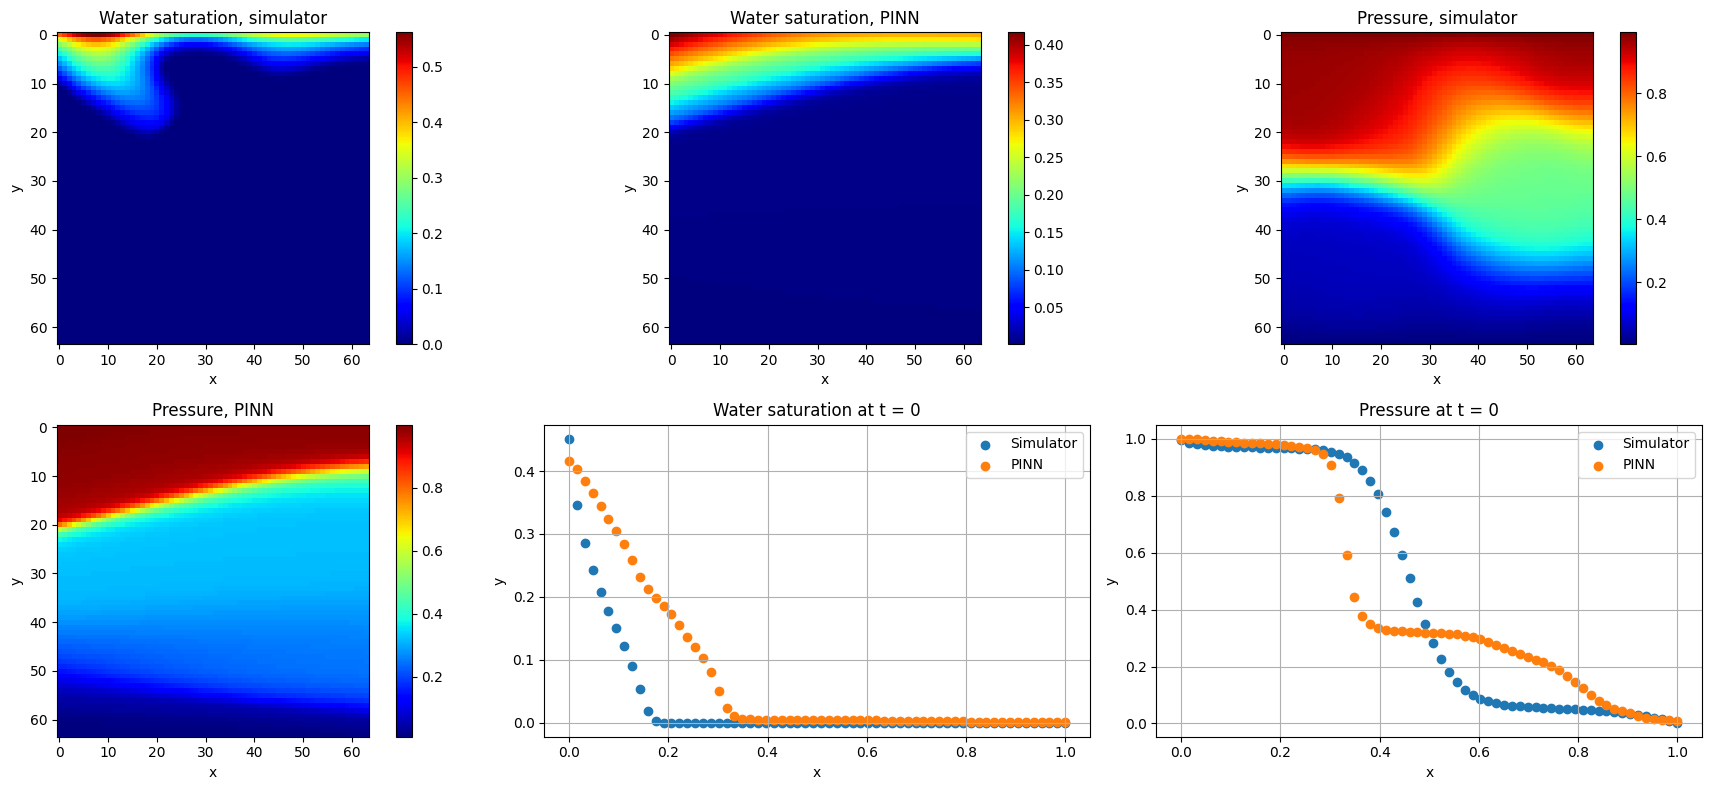

epoch: 1820	loss: (0.004229749852259245, 0.011466626077890396, 0.001131009909191302, 0.001131009909191302)	
epoch: 1840	loss: (0.0075402627033846715, 0.013054020636315857, 0.001920229838495808, 0.001920229838495808)	
epoch: 1860	loss: (0.0031992915152971235, 0.009850652755371161, 0.000976775523408183, 0.000976775523408183)	
epoch: 1880	loss: (0.0033379588276147842, 0.009531571795897824, 0.0007986593575749014, 0.0007986593575749014)	
epoch: 1900	loss: (0.0030234670931739466, 0.00974999022270952, 0.0005728148140146264, 0.0005728148140146264)	
epoch: 1920	loss: (0.04937350696751049, 0.0771833775298936, 0.012682746164500713, 0.012682746164500713)	
epoch: 1940	loss: (0.027795011975935528, 0.05060009179370744, 0.006540873420557806, 0.006540873420557806)	
epoch: 1960	loss: (0.021095324041587964, 0.036876607952373366, 0.0026549959522006767, 0.0026549959522006767)	
epoch: 1980	loss: (0.004945873881557158, 0.012634345396820987, 0.0011502385355665215, 0.0011502385355665215)	
epoch: 2000	loss: (0.

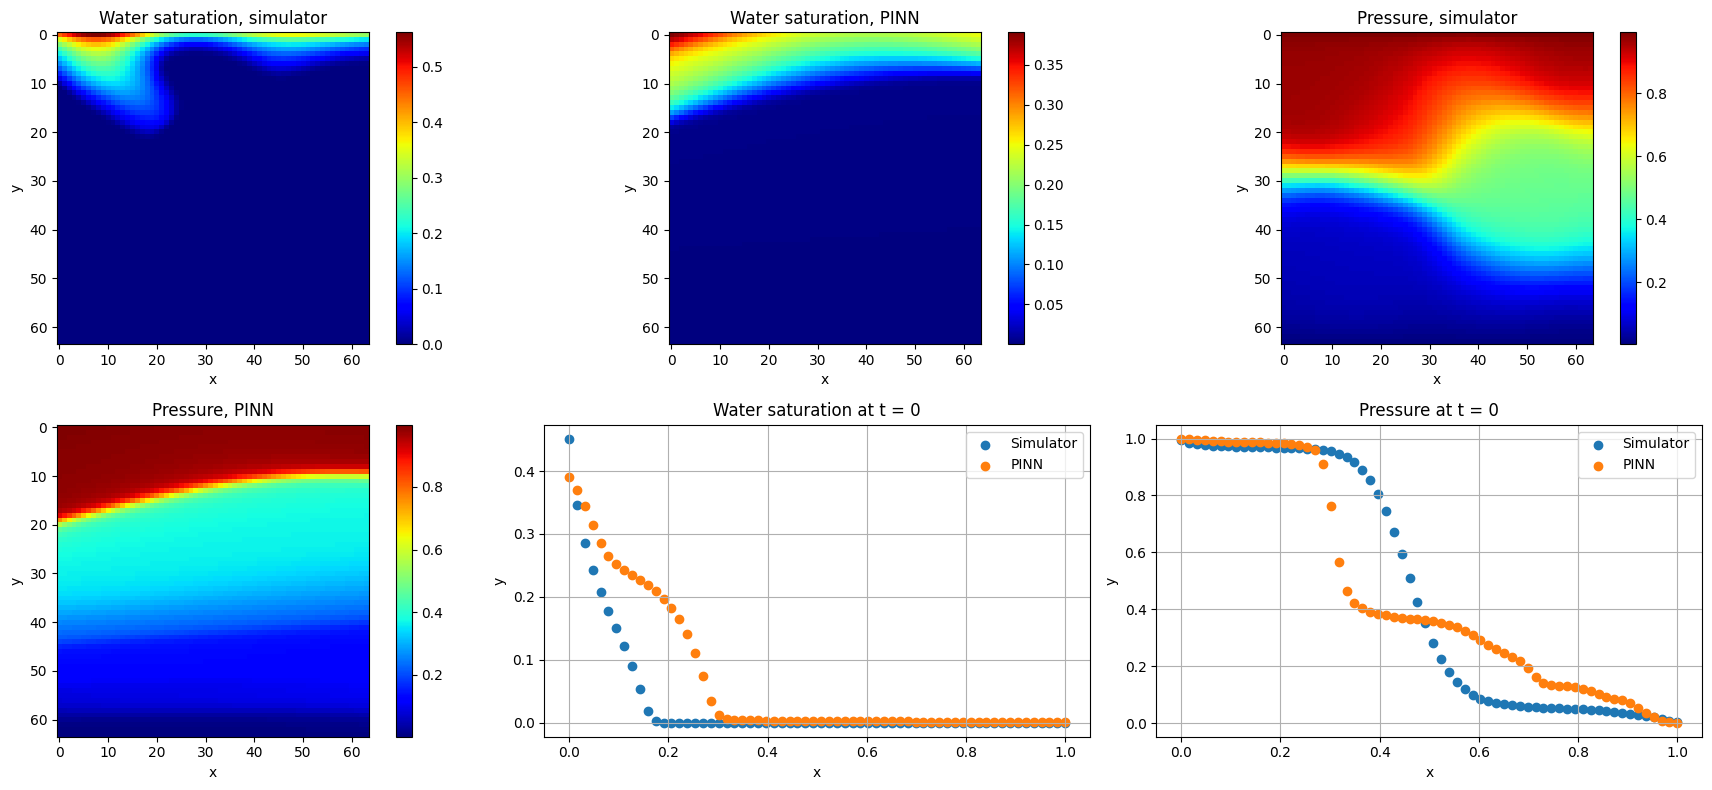

epoch: 2020	loss: (0.00457808847672173, 0.011318347483341182, 0.0011553052380414946, 0.0011553052380414946)	
epoch: 2040	loss: (0.00251533165906689, 0.00837694461058293, 0.00048122934198805263, 0.00048122934198805263)	
epoch: 2060	loss: (0.0034596950614026616, 0.006191231310367584, 0.0019724975572898984, 0.0019724975572898984)	
epoch: 2080	loss: (0.0033595209409083638, 0.00932093130956803, 0.0007760408001818828, 0.0007760408001818828)	
epoch: 2100	loss: (0.004711348031248365, 0.011855719478002616, 0.0007694839649567646, 0.0007694839649567646)	
epoch: 2120	loss: (0.0034864330996892284, 0.009936275758913584, 0.0008935081173798867, 0.0008935081173798867)	
epoch: 2140	loss: (0.003249060645300363, 0.008709905868662255, 0.0005716431811119296, 0.0005716431811119296)	
epoch: 2160	loss: (0.0028013090403484447, 0.009505256877413817, 0.000419053018309309, 0.000419053018309309)	
epoch: 2180	loss: (0.0030209871474653482, 0.010542317825768675, 0.0003526770825763898, 0.0003526770825763898)	
epoch: 22

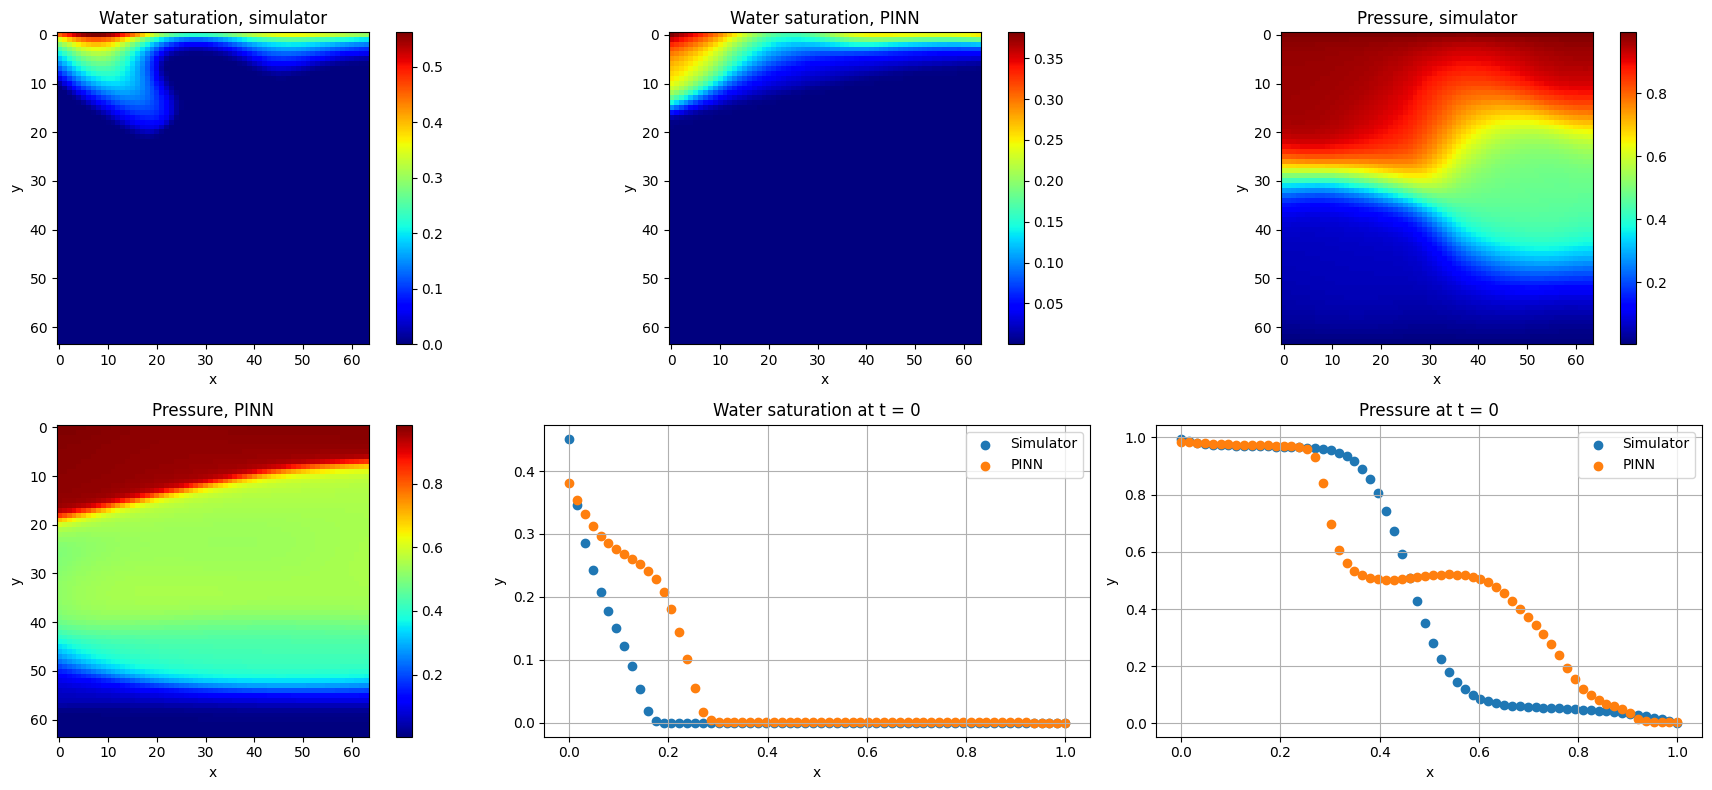

epoch: 2220	loss: (0.0026842465990089943, 0.008355650319052594, 0.0003266927586602313, 0.0003266927586602313)	
epoch: 2240	loss: (0.004049329053876656, 0.009357410782415952, 0.00036801184926714214, 0.00036801184926714214)	
epoch: 2260	loss: (0.2573250191552298, 0.27895694438900265, 0.02684395361159529, 0.02684395361159529)	
epoch: 2280	loss: (0.0334415856216635, 0.058129485696554184, 0.005916312536490815, 0.005916312536490815)	
epoch: 2300	loss: (0.02985855018986123, 0.04673498310148716, 0.004934732303289431, 0.004934732303289431)	
epoch: 2320	loss: (0.0185640917292663, 0.03639363843415465, 0.0037357822792338474, 0.0037357822792338474)	
epoch: 2340	loss: (0.020023184828460217, 0.03434806463441679, 0.004201342152165515, 0.004201342152165515)	
epoch: 2360	loss: (0.028592301133487905, 0.04499285002904279, 0.0016309323587587901, 0.0016309323587587901)	
epoch: 2380	loss: (0.01199000162471618, 0.02260217779049916, 0.0011204431565212353, 0.0011204431565212353)	
epoch: 2400	loss: (0.0074066327

KeyboardInterrupt: 

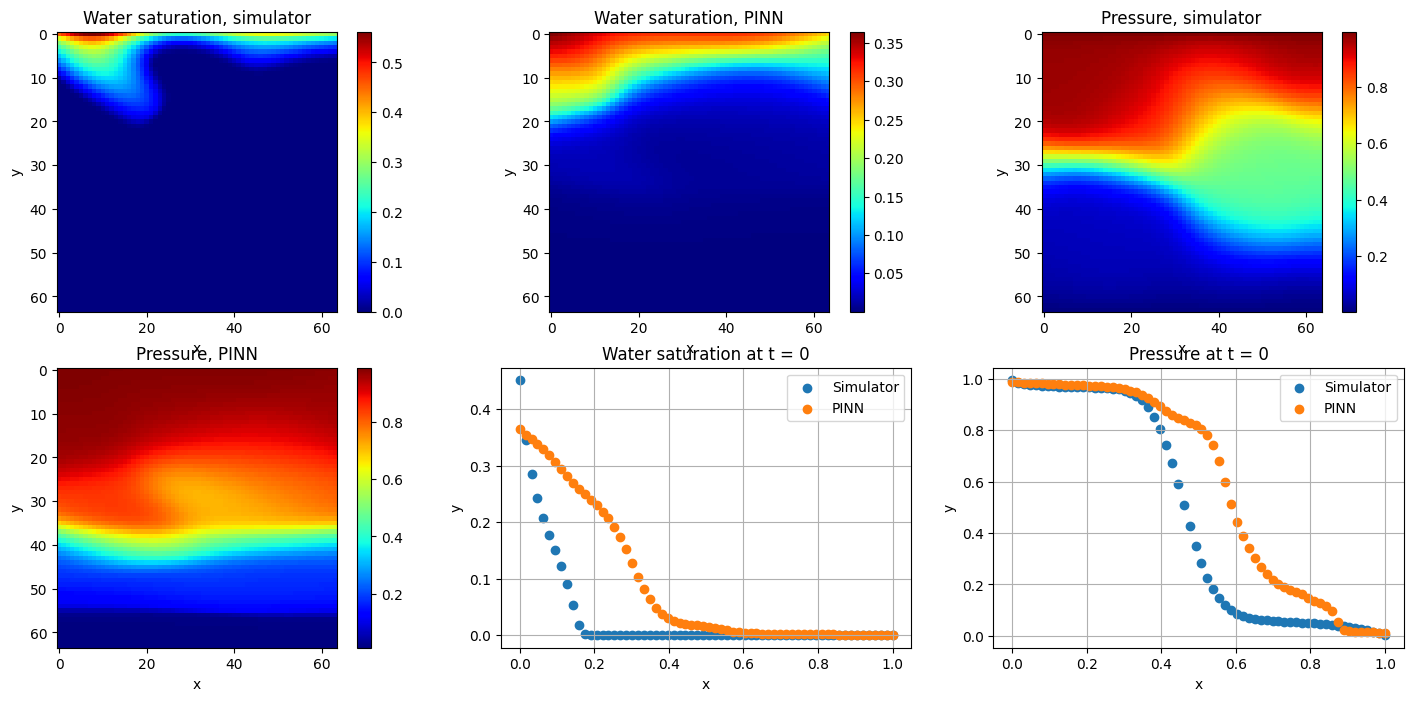

In [48]:
# epochs = 30_000
# BATCH_SIZE = 256
# RESAMPLE_EVERY = 100

# # model = pinn_model().to(DEVICE)
# model = ModifiedPINN(
#    input_dim=7,
#    hidden_dim=128,  # Try 128, 256
#    num_layers=6,    # Try 5-8
#    output_dim=7
# ).to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
# max_dist = float('inf')

# # Initialize permeability vector
# perm_vec = torch.tensor(
#     perm[list(x.cpu().detach().numpy().astype(int)), 
#          list(y.cpu().detach().numpy().astype(int)), -1].astype(np.float32)
# ).to(DEVICE)


# # ============================================================================
# # MAIN TRAINING LOOP WITH BATCHING (FIXED)
# # ============================================================================

# for cur_epoch in trange(epochs):
    
#     epoch_loss = 0.0
#     epoch_loss0 = 0.0
#     epoch_loss1 = 0.0
#     epoch_loss2 = 0.0
#     num_batches = 0
    
#     # ========================================================================
#     # MINI-BATCH TRAINING
#     # ========================================================================
#     for batch_indices in get_batch_indices(points.shape[0], BATCH_SIZE, shuffle=True):
        
#         optimizer.zero_grad()
        
#         # Get batch data
#         points_batch = points[batch_indices].to(DEVICE)
#         perm_vec_batch = perm_vec[batch_indices]
        
#         # --------------------------------------------------------------------
#         # PDE RESIDUALS - Using fixed function
#         # --------------------------------------------------------------------
#         r1, r2, r3_x1, r3_x2, r4_x1, r4_x2, r5, model_res = \
#             compute_pde_residuals(model, points_batch, perm_vec_batch)
        
#         # PDE loss
#         loss0 = torch.mean(
#             r1**2 + r2**2 + r3_x1**2 + r3_x2**2 + r4_x1**2 + r4_x2**2 + r5**2
#         )
        
#         # --------------------------------------------------------------------
#         # BOUNDARY CONDITIONS - Sample subset
#         # --------------------------------------------------------------------
#         bc_batch_size = min(BATCH_SIZE // 4, 
#                            pres0_x1_points.shape[0],
#                            pres1_x1_points.shape[0],
#                            soil0_x1_points.shape[0],
#                            swat0_x1_points.shape[0])
        
#         bc_idx_pres0 = torch.randperm(pres0_x1_points.shape[0])[:bc_batch_size]
#         bc_idx_pres1 = torch.randperm(pres1_x1_points.shape[0])[:bc_batch_size]
#         bc_idx_soil0 = torch.randperm(soil0_x1_points.shape[0])[:bc_batch_size]
#         bc_idx_swat0 = torch.randperm(swat0_x1_points.shape[0])[:bc_batch_size]
        
#         # Get predictions at boundary points
#         press0 = model(pres0_x1_points[bc_idx_pres0].to(DEVICE))[:, 0]
#         press1 = model(pres1_x1_points[bc_idx_pres1].to(DEVICE))[:, 0]
#         soil0 = model(soil0_x1_points[bc_idx_soil0].to(DEVICE))[:, 1]
#         swat0 = model(swat0_x1_points[bc_idx_swat0].to(DEVICE))[:, 2]
        
#         # Boundary condition loss
#         loss1 = torch.mean(
#             (press0 - 1.0)**2 + press1**2 + 
#             (soil0 - 1.0)**2 + swat0**2
#         )
        
#         # --------------------------------------------------------------------
#         # DATA LOSS - Sample from simulation data
#         # --------------------------------------------------------------------
#         data_batch_size = min(BATCH_SIZE, simulation_data_train.shape[0])
#         data_indices = torch.randperm(simulation_data_train.shape[0])[:data_batch_size]
        
#         # Get corresponding points and simulation data
#         data_points = points[data_indices].to(DEVICE)
#         sim_data = simulation_data_train[data_indices].to(DEVICE)
        
#         # Model predictions on data points
#         model_res_data = model(data_points)
        
#         # Data loss
#         loss2 = torch.mean(
#             (model_res_data[:, 0] - sim_data[:, 0])**2 + 
#             (model_res_data[:, 2] - sim_data[:, 1])**2 + 
#             (model_res_data[:, 1] - sim_data[:, 2])**2
#         )
        
#         # --------------------------------------------------------------------
#         # DYNAMIC WEIGHTS
#         # --------------------------------------------------------------------
#         w_ic, w_pde, w_data = compute_weights_grad_orthogonal_autograd(
#             model, loss1, loss0, loss2, kappa=10.0
#         )
        
#         # Combined loss
#         loss = w_pde * loss0 + w_ic * loss1 + w_data * loss2
        
#         # --------------------------------------------------------------------
#         # BACKWARD PASS
#         # --------------------------------------------------------------------
#         loss.backward()
        
#         # Optional: Gradient clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
#         optimizer.step()
        
#         # Accumulate losses
#         epoch_loss += loss.item()
#         epoch_loss0 += loss0.item()
#         epoch_loss1 += loss1.item()
#         epoch_loss2 += loss2.item()
#         num_batches += 1
    
#     # ========================================================================
#     # EPOCH SUMMARY
#     # ========================================================================
#     epoch_loss /= num_batches
#     epoch_loss0 /= num_batches
#     epoch_loss1 /= num_batches
#     epoch_loss2 /= num_batches
    
#     dist = epoch_loss0 + epoch_loss1 + epoch_loss2
    
#     # Visualization
#     if cur_epoch % 20 == 0:
#         print(f'epoch: {cur_epoch}\tloss: {epoch_loss, epoch_loss0, epoch_loss1, epoch_loss1}\t')
#         # update_loss_plot(cur_epoch, epoch_loss, epoch_loss0, epoch_loss1, epoch_loss2)
#         # plot_validation(model, PRES, SWAT, SOIL, device='mps')
#     if cur_epoch % 200 == 0:
#         plot_validation(model, PRES, SWAT, SOIL, device=DEVICE)
#     # Save best model
#     if dist < max_dist:
#         torch.save(model.state_dict(), 'pinn_model_weights_500.pth')
#         max_dist = dist
    
#     # Learning rate decay
#     if cur_epoch % 500 == 0 and cur_epoch > 0:
#         optimizer.param_groups[0]['lr'] *= 0.9

In [34]:
torch.save(model.state_dict(), 'pinn_fullbatch_500-pre-trained-4.pth')

In [41]:
model = ModifiedPINN(
   input_dim=7,
   hidden_dim=128,  # Try 128, 256
   num_layers=6,    # Try 5-8
   output_dim=7
).to(DEVICE)

model.load_state_dict(torch.load('pinn-test4-250-batched-new-kaggle2.pth', map_location=torch.device('cpu')))
model = model.to(DEVICE)

In [42]:
def set_big_plot_style(scale: float = 1.2):
    """Global matplotlib style for bigger text/ticks/legend and sharper saved figs."""
    base = 18 * scale
    title = 22 * scale
    label = 20 * scale
    ticks = 16 * scale
    legend = 16 * scale

    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,

        "font.size": base,
        "axes.titlesize": title,
        "axes.labelsize": label,
        "xtick.labelsize": ticks,
        "ytick.labelsize": ticks,
        "legend.fontsize": legend,

        "axes.titlepad": 12,
        "axes.labelpad": 10,
    })

def _add_colorbar_big(im):
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=plt.rcParams.get("ytick.labelsize", 16))
    return cbar

def main_new(model, pwat=1.5, poil=2.0, kwat=1.5, koil=0.3):
    # ---- make ALL plot text bigger ----
    set_big_plot_style(scale=1.3)  # try 1.0 .. 1.6

    perm = np.load('/Users/kirill/Desktop/perm_2.npy')
    nx0, nx1 = perm.shape
    nx2 = 1
    perm = np.reshape(perm, (nx0, nx1, nx2))
    poro = 0.1 + np.zeros((nx0, nx1, nx2))

    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    vr = 0.3

    # total number of spatial points used for the PINN query
    npts = nx0 * nx1

    # Make constant property fields if floats are provided
    if isinstance(pwat, float):
        pwat_list = pwat * torch.ones(npts)
        poil_list = poil * torch.ones(npts)
        kwat_list = kwat * torch.ones(npts)
        koil_list = koil * torch.ones(npts)
    else:
        # If you pass tensors/arrays, ensure they are flattened to length npts
        pwat_list = torch.as_tensor(pwat).reshape(-1)[:npts]
        poil_list = torch.as_tensor(poil).reshape(-1)[:npts]
        kwat_list = torch.as_tensor(kwat).reshape(-1)[:npts]
        koil_list = torch.as_tensor(koil).reshape(-1)[:npts]

    pmin = 0.0
    pmax = 1.0

    dt = 0.15e-1
    niter = 100

    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))

    pres, swat, soil = compute_solution(
        perm, poro,
        dx0, dx1, dx2, dt * niter, niter,
        pwat, kwat, poil, koil, vr,
        pmin=pmin, pmax=pmax
    )

    # Build inputs for the model: (t, x, y, pwat, poil, kwat, koil)
    time_for_model = (niter * dt) * torch.ones(npts)
    x_for_model = dx0 * torch.arange(nx0)
    y_for_model = dx1 * torch.arange(nx1)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)  # (npts, 2)

    X = torch.stack(
        (
            time_for_model,
            cartesian_points[:, 0],
            cartesian_points[:, 1],
            pwat_list,
            poil_list,
            kwat_list,
            koil_list,
        ),
        dim=-1
    ).to(DEVICE)

    model_prediction = model(X).detach().cpu().numpy()

    # Convenience arrays for plotting (squeeze nx2=1)
    swat_sim_2d = np.squeeze(swat[:, :, 0, -1])   # (nx0, nx1)
    pres_sim_2d = np.squeeze(pres[:, :, 0, -1])   # (nx0, nx1)

    swat_pinn_2d = np.squeeze(model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, :, 0])
    pres_pinn_2d = np.squeeze(model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, :, 0])

    # ---- Plots ----
    # Water saturation, simulator
    plt.figure(figsize=(8, 6))
    plt.title('Water saturation, simulator')
    im = plt.imshow(swat_sim_2d)
    _add_colorbar_big(im)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('graphs/color_swat_sim.png', bbox_inches="tight")
    plt.show()

    # Water saturation, PINN
    plt.figure(figsize=(8, 6))
    plt.title('Water saturation, PINN')
    im = plt.imshow(swat_pinn_2d)
    _add_colorbar_big(im)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('graphs/color_swat_pinn4.png', bbox_inches="tight")
    plt.show()

    # Pressure, simulator
    plt.figure(figsize=(8, 6))
    plt.title('Pressure, simulator')
    im = plt.imshow(pres_sim_2d)
    _add_colorbar_big(im)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('graphs/color_pressure_sim.png', bbox_inches="tight")
    plt.show()

    # Pressure, PINN
    plt.figure(figsize=(8, 6))
    plt.title('Pressure, PINN')
    im = plt.imshow(pres_pinn_2d)
    _add_colorbar_big(im)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('graphs/color_pressure_pinn4.png', bbox_inches="tight")
    plt.show()

    # Water saturation scatter (using your original slice logic)
    plt.figure(figsize=(8, 6))
    plt.title('Water saturation at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0),
                model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0],
                label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
    plt.savefig('graphs/swat_scatter4.png', bbox_inches="tight")
    plt.show()

    # Pressure scatter (using your original slice logic)
    plt.figure(figsize=(8, 6))
    plt.title('Pressure at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0),
                model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0],
                label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
    plt.savefig('graphs/pres_scatter4.png', bbox_inches="tight")
    plt.show()

    return 0


In [43]:
pd.DataFrame(model(points).cpu().detach().numpy(), columns=['pres', 'soil', 'swat', 'uoil_x', 'uoil_y', 'uwat_x', 'uwat_y']).describe()

pres        soil        swat      uoil_x      uoil_y      uwat_x  \
count  250.000000  250.000000  250.000000  250.000000  250.000000  250.000000   
mean     0.841208    0.790842    0.209158    0.012465    0.001427    0.019117   
std      0.293685    0.146857    0.146857    0.006006    0.002854    0.015035   
min      0.000920    0.409894    0.000015   -0.003586   -0.008754   -0.017363   
25%      0.912564    0.680259    0.110228    0.008933   -0.000369    0.008877   
50%      0.982029    0.792765    0.207235    0.011312    0.001178    0.018384   
75%      0.991577    0.889772    0.319741    0.013096    0.002978    0.028317   
max      1.000092    0.999985    0.590106    0.026905    0.013037    0.096328   

           uwat_y  
count  250.000000  
mean     0.001600  
std      0.006444  
min     -0.027083  
25%     -0.001699  
50%      0.002380  
75%      0.006029  
max      0.024601

In [44]:
pd.DataFrame(simulation_data_train.cpu().detach().numpy(), columns=['pres', 'swat', 'soil']).describe()

pres          swat        soil
count  250.000000  2.500000e+02  250.000000
mean     0.841486  2.058850e-01    0.794115
std      0.287343  1.479325e-01    0.147933
min      0.003952  9.642727e-40    0.409828
25%      0.909738  1.069702e-01    0.681492
50%      0.975265  2.046573e-01    0.795343
75%      0.987484  3.185083e-01    0.893030
max      0.998812  5.901717e-01    1.000000

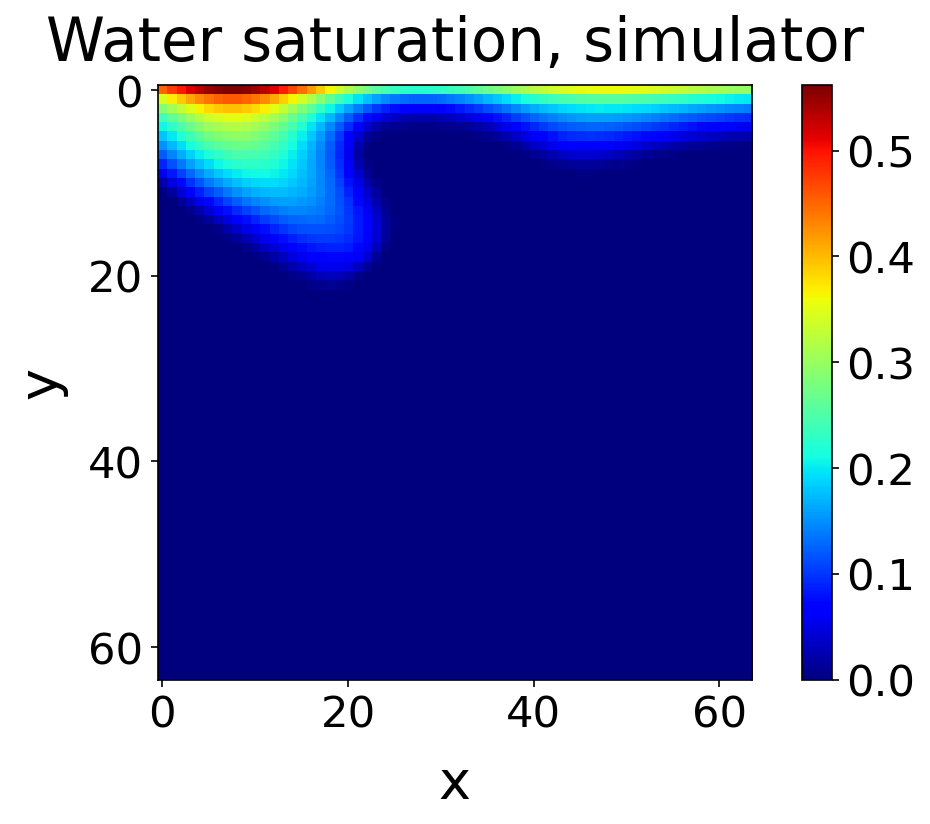

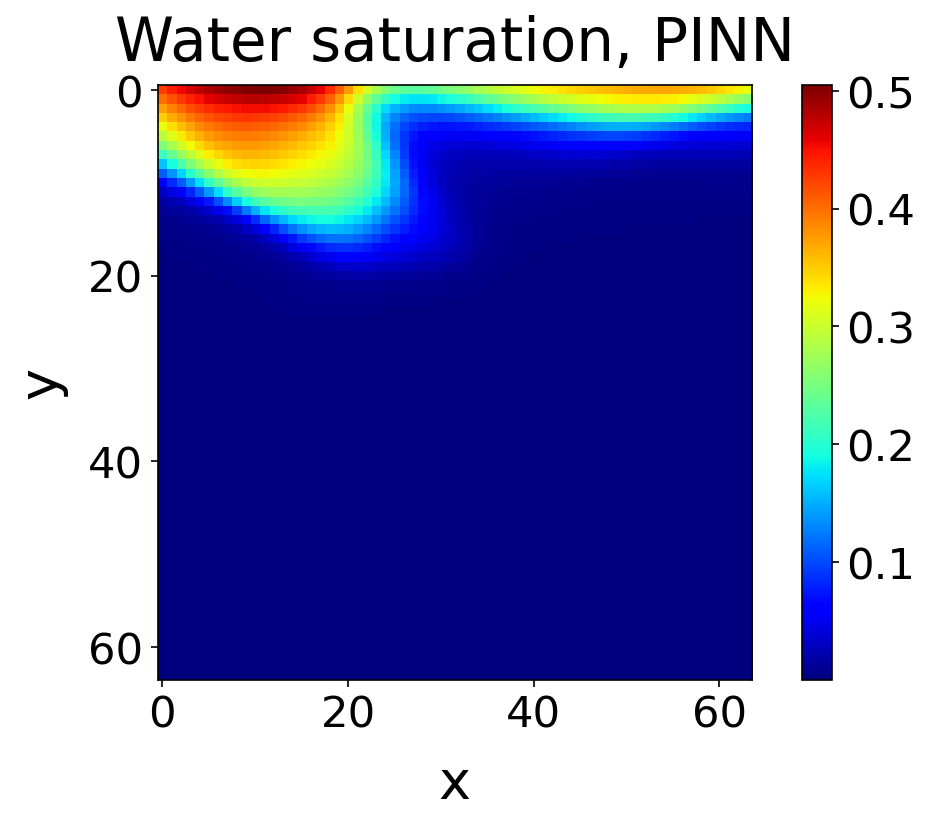

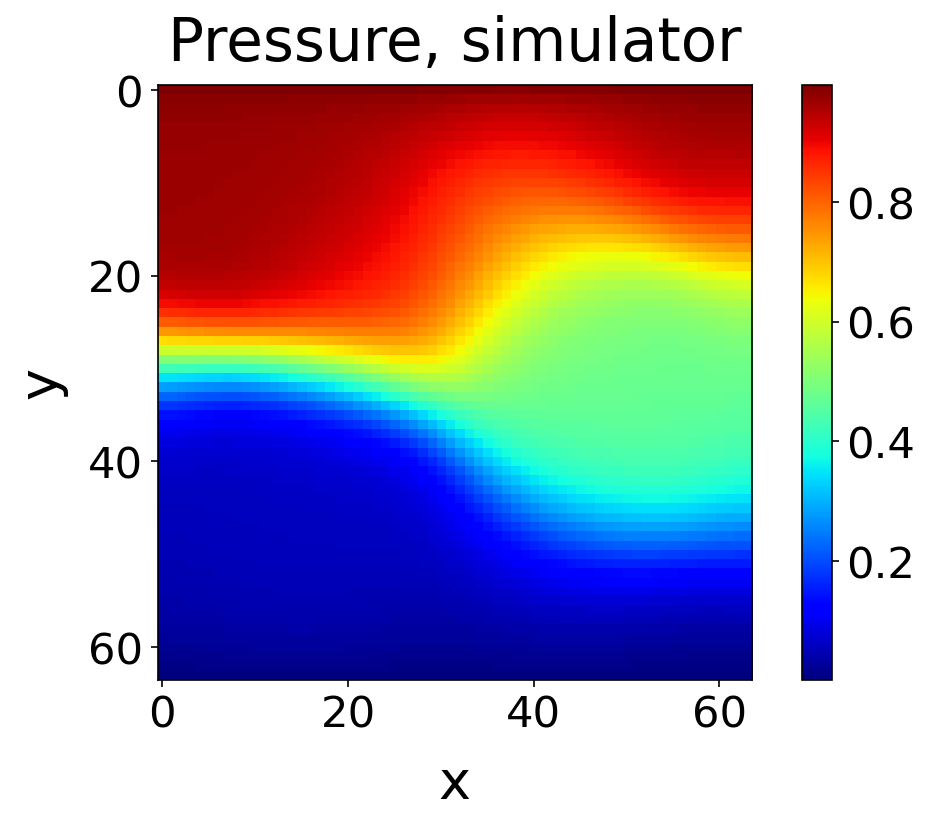

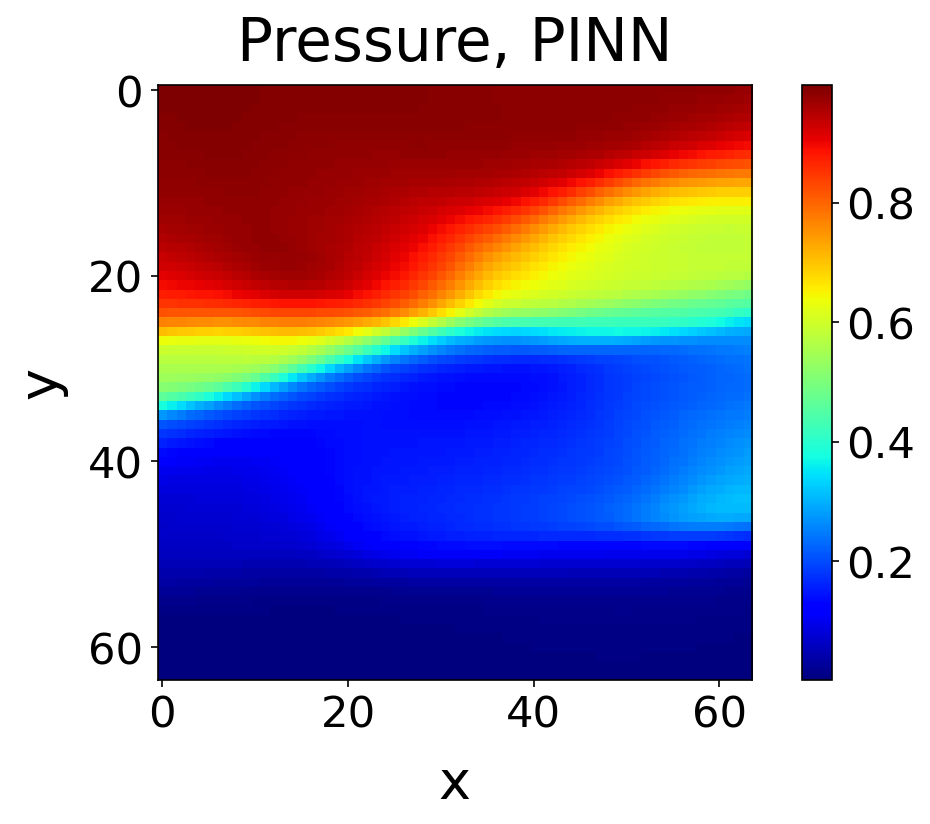

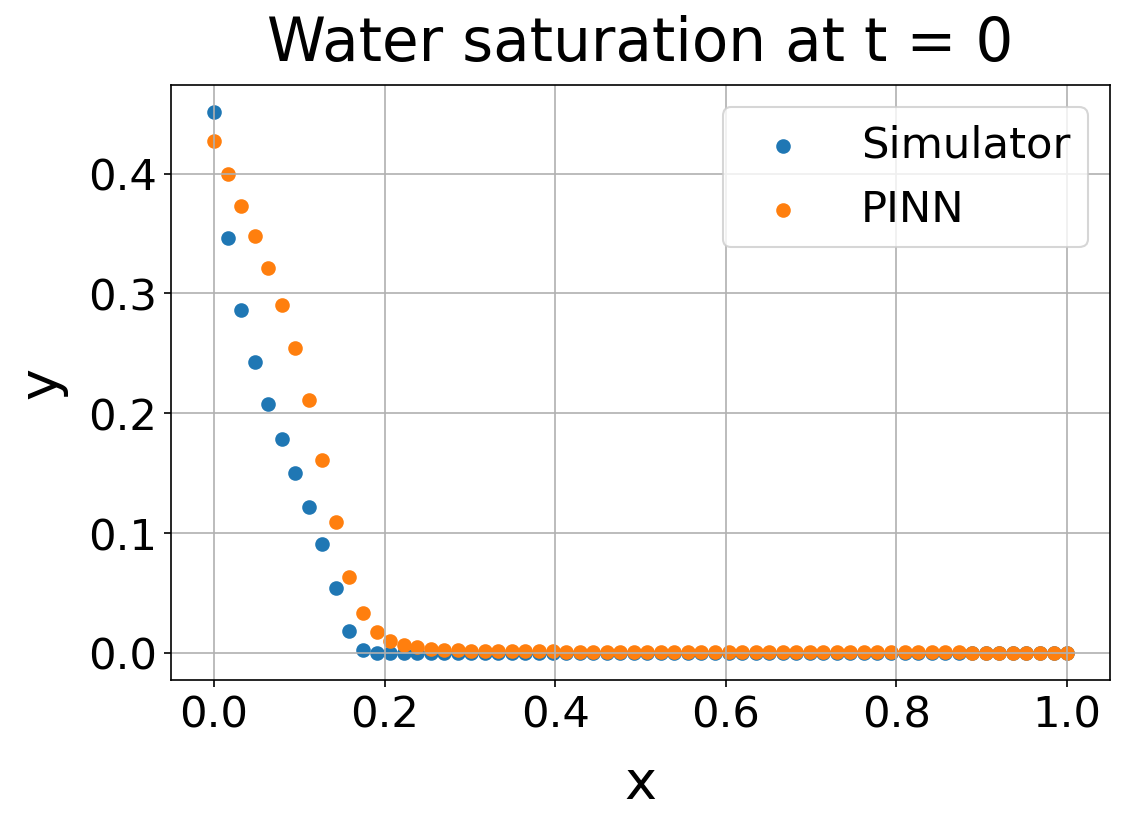

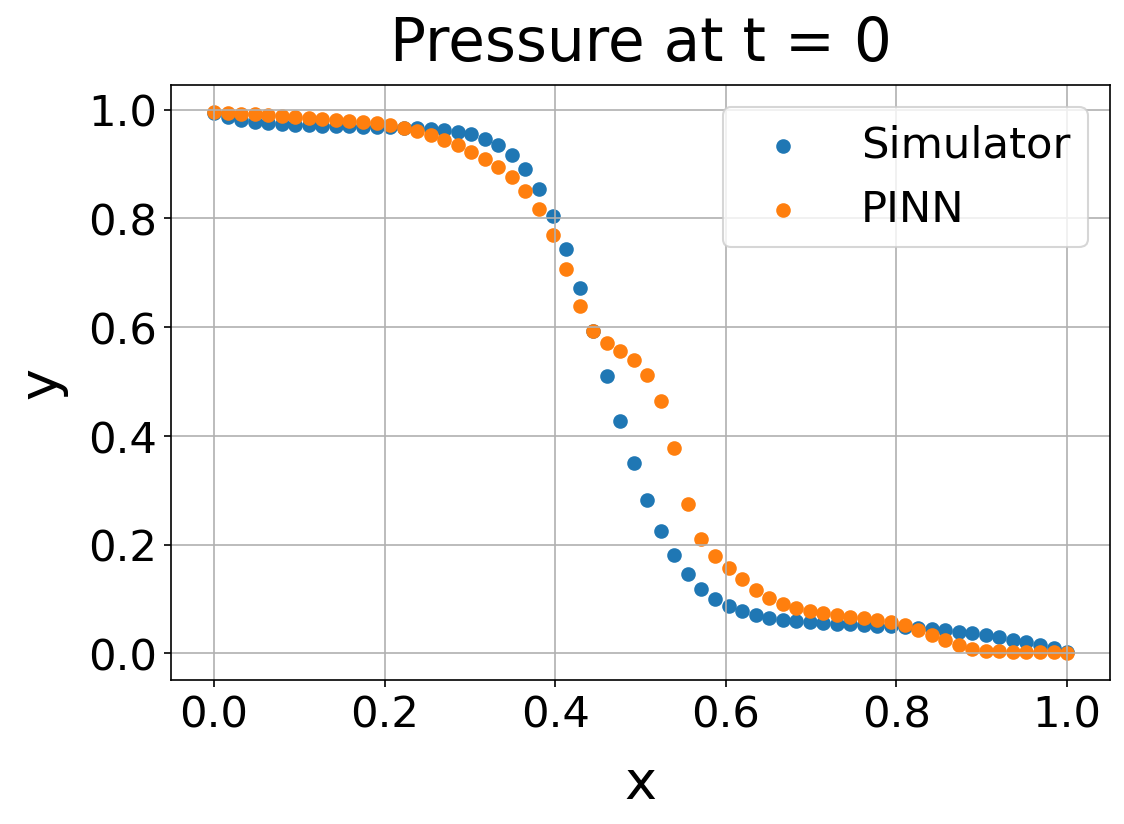

0

In [45]:
# model = pinn_model().to(DEVICE)
# model.load_state_dict(torch.load('pinn-test4-500.pth'))
model.eval()

main_new(model)

# SVR

# Test results random from simulation

In [50]:
def build_metrics(model_prediction, pres, swat, soil, process):

    metrics = ['MSE', 'MAE', 'R_2', 'RMSE', 'MAPE']
    
    # Saturation water
    satur = [
        np.mean((model_prediction[:, 2] - swat) ** 2),  # MSE
        np.mean(np.abs(model_prediction[:, 2] - swat)), # MAE
        r2_score(swat, model_prediction[:, 2]),         # R^2
        np.sqrt(np.mean((model_prediction[:, 2] - swat) ** 2)), # RMSE
        np.mean(np.abs((swat - model_prediction[:, 2]) / (swat + 1e-8))) * 100  # MAPE (%)
    ]
    
    # Pressure
    press = [
        np.mean((model_prediction[:, 0] - pres) ** 2),
        np.mean(np.abs(model_prediction[:, 0] - pres)),
        r2_score(pres, model_prediction[:, 0]),
        np.sqrt(np.mean((model_prediction[:, 0] - pres) ** 2)),
        np.mean(np.abs((pres - model_prediction[:, 0]) / (pres + 1e-8))) * 100
    ]
    
    # Saturation oil
    sat_oil = [
        np.mean((model_prediction[:, 1] - soil) ** 2),
        np.mean(np.abs(model_prediction[:, 1] - soil)),
        r2_score(soil, model_prediction[:, 1]),
        np.sqrt(np.mean((model_prediction[:, 1] - soil) ** 2)),
        np.mean(np.abs((soil - model_prediction[:, 1]) / (soil + 1e-8))) * 100
    ]
    
    # Combine into dataframe
    metrics_df = pd.DataFrame({
        f'Metrics {process}': metrics,
        f'Saturation water {process}': satur,
        f'Saturation oil {process}': sat_oil,
        f'Pressure {process}': press
    })
    
    return metrics_df


In [51]:
def build_test_random(model, x_list=x_list, y_list=y_list, 
               t_list=t_list, pwat_rand=pwat_rand,
               poil_rand=poil_rand, kwat_rand=kwat_rand, 
               koil_rand=koil_rand, simulation_data=simulation_data, 
               dx=dx, dy=dy, dt=dt, rand_indexes=rand_indexes, test_size=100):

    N = simulation_data.shape[0] - rand_indexes.shape[0]
    test_indexes = np.random.randint(0, N, test_size)
    pres = np.delete(simulation_data[:, 0], rand_indexes)[test_indexes]
    swat = np.delete(simulation_data[:, 1], rand_indexes)[test_indexes]
    soil = np.delete(simulation_data[:, 2], rand_indexes)[test_indexes]

    x_list = np.delete(x_list, rand_indexes)[test_indexes] * dx
    y_list = np.delete(y_list, rand_indexes)[test_indexes] * dy
    t_list = np.delete(t_list, rand_indexes)[test_indexes] * dt

    pwat_rand = np.delete(pwat_rand, rand_indexes)[test_indexes]
    poil_rand = np.delete(poil_rand, rand_indexes)[test_indexes]
    kwat_rand = np.delete(kwat_rand, rand_indexes)[test_indexes]
    koil_rand = np.delete(koil_rand, rand_indexes)[test_indexes]

    X = np.column_stack([
        t_list.astype(np.float32),
        x_list.astype(np.float32),
        y_list.astype(np.float32),
        pwat_rand.astype(np.float32),
        poil_rand.astype(np.float32),
        kwat_rand.astype(np.float32),
        koil_rand.astype(np.float32),
    ])

    with torch.no_grad():
        X_t = torch.from_numpy(X).to(DEVICE)      # (N, 7)
        model_prediction = model(X_t).cpu().numpy()

    return model_prediction, pres, swat, soil


In [52]:
model_prediction, pres, swat, soil = build_test_random(model)
build_metrics(model_prediction, pres, swat, soil, 'test random')

Metrics test random  Saturation water test random  \
0                 MSE                  5.784008e-02   
1                 MAE                  1.968842e-01   
2                 R_2                 -1.855489e+00   
3                RMSE                  2.404996e-01   
4                MAPE                  8.231407e+06   

   Saturation oil test random  Pressure test random  
0                    0.057840              0.086780  
1                    0.196884              0.181964  
2                   -1.855489             -0.027535  
3                    0.240500              0.294585  
4                   28.942998            361.946637

# Test result real sim

In [46]:
def build_test_sim(model, dt=0.15e-1, niter=100, 
                   perm=perm, dx=dx, dy=dy,
                   pwat=1.5, poil=2.0, 
                   kwat=1.5, koil=0.3,
                   vr=0.3):
    
    pwat_list = pwat * torch.ones(64 * 64)
    poil_list = poil * torch.ones(64 * 64)
    kwat_list = kwat * torch.ones(64 * 64)
    koil_list = koil * torch.ones(64 * 64)
    
    
    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))
    
    
    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    
    model_prediction = model(
        torch.stack(
            (time_for_model, 
             cartesian_points[:, 0], 
             cartesian_points[:, 1],
             pwat_list,
             poil_list,
             kwat_list,
             koil_list), -1).to(DEVICE))
    
    model_prediction = model_prediction.cpu().detach().numpy()

    return model_prediction, pres, swat, soil

In [53]:
model_prediction, pres, swat, soil = build_test_sim(model, dt=0.15e-1, niter=100,)


sw_pred = model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0]
sw_true = swat[:, 0, 0, -1]

so_pred = model_prediction[:, 1].reshape(nx0, nx1, nx2)[:, 0, 0]
so_true = soil[:, 0, 0, -1]

p_pred  = model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0]
p_true  = pres[:, 0, 0, -1]

metrics = ['MSE', 'MAE', 'R_2', 'RMSE', 'MAPE']

# Helper to compute all metrics with safe MAPE
def all_metrics(y_true, y_pred, eps=1e-8):
    mse  = np.mean((y_pred - y_true) ** 2)
    mae  = np.mean(np.abs(y_pred - y_true))
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0
    return [mse, mae, r2, rmse, mape]

# Build columns
satur = all_metrics(sw_true, sw_pred)   # Saturation water
sat_oil = all_metrics(so_true, so_pred)   # Saturation oil
press = all_metrics(p_true,  p_pred)    # Pressure

# Combine into dataframe
metrics_df = pd.DataFrame({
    f'Metrics test': metrics,
    f'Saturation test': satur,
    f'Saturation oil test': sat_oil,
    f'Pressure test': press
})

metrics_df

Metrics test  Saturation test  Saturation oil test  Pressure test
0          MSE     1.217314e-03             0.001217       0.004235
1          MAE     1.494888e-02             0.014949       0.038398
2          R_2     8.488651e-01             0.848865       0.976372
3         RMSE     3.489002e-02             0.034890       0.065080
4         MAPE     6.550856e+06             1.826609      31.609208